In [1]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import pickle
from tqdm import tqdm

# from ip3_ca_ode import *
from ip3_ca_ode_cfg import *
import cfg

save = 'figures/paper_plots/'

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

diversity_colors = {
#     'SP': '#5dbcd2', #blue
    'SP': '#2b8bfb',
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

# colors = ['#2b8bfb', '#040404', '#7e3838', '#90a0b5']


In [2]:
def classification_simulation_with_row(df_row, t_0=0, t_f=400, max_step=0.1, input_type='glut',
                                      c_tot=1, poisson_start=False, kpkm=[1, 1]):
    '''
    Run the ip3 simulation with parameters given from pandas dataframe row
    c_tot: control the initial c_tot condition
    poisson_start: whether to use initial condition generated by poisson start
    kpkm: factors to change the kp and km parameters ([30, 10] might be good for correct sensitivity)
    '''
    all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
    kp = 0.03
    km = 0.04
    
    if poisson_start:
        load_experiment('poisson/rate_0.2_conc_10')
        cfg.all_init = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]
    
#     cfg.all_init[1] = cfg.all_init[1] * c_tot
    cfg.kp = kp * kpkm[0]
    cfg.km = km * kpkm[1]
    
    cfg.A = df_row['A']
    cfg.d_rise = df_row['d_rise']
    cfg.d_decay = df_row['d_decay']
    cfg.r_rise = df_row['r_rise']
    cfg.r_decay = df_row['r_decay']

    if(input_type == 'glut'):
        sol = run_experiment('curve', t_f=t_f, max_step=max_step)
    elif(input_type == 'Gstar'):
        sol = run_Gstar_controlled_experiment('curve', t_f=t_f, max_step=max_step)
    elif(input_type == 'ip3'):
        sol = run_ip3_controlled_experiment('curve', t_f=t_f, max_step=max_step)
        
    cfg.all_init = all_init
    cfg.kp = kp
    cfg.km = km
    
    return sol



def classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_0=0, t_f=400, max_step=0.2,
                                       input_type='glut'):
    '''
    Run the full system simulation for values to shape glutamate transient
    
    A, d_rise, d_decay, r_rise, r_decay: input curve parameters
    input_type: 'glut'/'ip3' - what system to run control for
    '''
    cfg.A = A
    cfg.d_rise = d_rise
    cfg.d_decay = d_decay
    cfg.r_rise = r_rise
    cfg.r_decay = r_decay
    
    if(input_type == 'glut'):
        sol = run_experiment('curve', t_f=t_f, max_step=max_step)
    elif(input_type == 'ip3'):
        sol = run_ip3_controlled_experiment('curve', t_f=t_f, max_step=max_step)
    return sol
    
    
    

'''
------------------------
Classification Functions
------------------------
These functions will be used to tell use what type of calcium response we have
as well as the IP3 characteristics
'''

def ip3_characteristics(t_0, t_f):
    '''
    This function returns some characteristic information about the ip3 curve
    It uses the globally set ip3 curve parameters (d_rise, d_decay, r_rise, r_decay)
    which are set using set_ip3_curve_manual, then ip3_curve_input gives the actual ip3 curve
    
    returns: ip3_total, ip3_amplitude, t_peak, t_duration
    ip3_total: total amount of ip3 in the transient curve
    ip3_amplitude: the height of ip3 at peak
    t_peak: the time of peak
    t_duration: the total time the ip3 transient lasted
    '''
    #get the ip3 curve
    t = np.arange(t_0, t_f, 0.1)
    p = np.zeros(len(t))
    for i in range(len(t)):
        p[i] = ip3_curve_input(t[i])
    
    ip3_total = np.sum(p) / len(p) * t_f #mean instantaneous ip3 multiplied by total time
    
    peaks, _ = scipy.signal.find_peaks(p) #find the index of maximum value of ip3
    if(len(peaks) > 0):
        peak = peaks[0]
    else:
        peak = False
        
    ip3_amplitude = p[peak]
    t_peak = t[peak]
    
    t_start_index = np.argmax(p > 0) #find first occurence that ip3 > 0
    t_end_index = peak + np.argmax(p[peak:] < 0.005) #find first time after the peak that ip3 < 0.005
    t_duration = t[t_end_index] - t[t_start_index]
    
    if(peak == False):
        t_duration = t_f #if there are no peaks, the "duration" is the entire simulation
    
    return ip3_total, ip3_amplitude, t_peak, t_duration
    

def calcium_peaks_and_troughs(t, c, index=True):
    '''
    Determine where the peaks and troughs are in the calcium response
    Pass t and c given by the numerical ODE solver
    index: True/False, if True will return indices of peaks and troughs, rather than values
    
    returns: 
      (index == False): t_peaks, c_peaks, t_troughs, c_troughs
      (index == True): peaks, troughs
    '''
    base_c = c[0]
    response_start_index = np.argmax(c > 1.4 * base_c) #we label the first time the calcium is 1.4 times base level
                                                        #as the start of the calcium response
    peaks, _ = scipy.signal.find_peaks(c) #note that these functions find the indices of peaks and troughs
    peaks = peaks[t[peaks] > cfg.t_star] #real peaks are those that happend after the start of the ip3 signal
    troughs, _ = scipy.signal.find_peaks(-c)
    true_troughs = []
    
    #the only troughs that we should count are the ones that lie between two peaks
    t_first_peak = t[peaks[0]]
    t_last_peak = t[peaks[-1]]
    for trough in troughs:
        if(t_first_peak < t[trough] and t[trough] < t_last_peak):
            true_troughs.append(trough)
    
    if(index):
        return peaks, true_troughs
    else:
        #convert indices to values
        t_peaks = t[peaks]
        c_peaks = c[peaks]
        t_troughs = t[true_troughs]
        c_troughs = c[true_troughs]        
        return t_peaks, c_peaks, t_troughs, c_troughs
    

    
def calcium_response_characteristics(t, c, peaks):
    '''
    Get characteristics of the calcium curve
    '''
    #determine start of calcium response to be 1.4x the baseline value
    base_c = c[1]
    response_start_index = np.argmax(c > 1.4 * base_c)
    last_peak = peaks[-1]
    response_end_index = last_peak + np.argmax(c[last_peak:] < 1.4 * base_c) #find end of response
    
    t_response_start = t[response_start_index]
    t_response_end = t[response_end_index]
    t_duration = t_response_end - t_response_start
    
#     base_c = c[response_start_index - 3] #our baseline for calcium is the value of c before response starts
    max_height_c = np.max(c) - base_c
    
    c_means = (c[response_start_index : response_end_index - 1] +\
               c[response_start_index + 1 : response_end_index]) / 2
    c_total = np.sum(np.diff(t[response_start_index : response_end_index]) * c_means)
    
    return response_start_index, response_end_index, t_duration, base_c, max_height_c, c_total
    
    


def visualize_classification(t, c, x_max=150, ret=False, ax=None, peak_priority=False):
    '''
    Visualize what the algorithm is observing to classify a response
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,8))
#     ax.figure(figsize=(8,8))
    ax.plot(t, c)
    ax.plot(t[1:], np.diff(c) / np.diff(t))
    
    vis_dict, response = calcium_response_classification(t, c, vis=True, peak_priority=peak_priority)
    
    if(len(vis_dict['mp_peaks']) > 0):
        ax.scatter(t[vis_dict['mp_peaks']], c[vis_dict['mp_peaks']], c='blue')
    if(len(vis_dict['mp_troughs']) > 0):
        ax.scatter(t[vis_dict['mp_troughs']], c[vis_dict['mp_troughs']], c='red')
    if(vis_dict['end_first_response'] is not None):
        ax.scatter(t[vis_dict['end_first_response']], c[vis_dict['end_first_response']], c='green')
        ax.scatter(t[vis_dict['end_first_response']], [0], c='green')

#     print(t[vis_dict['end_first_response']])
    ax.scatter(t[vis_dict['response_start_index']], c[vis_dict['response_start_index']], c='black')
    ax.scatter(t[vis_dict['response_end_index']], c[vis_dict['response_end_index']], c='black')
    
    ax.plot([0, x_max], [0, 0], '--', c='green')
    ax.set_xlim([0, x_max])
    
    print(response)
    if(ret):
        return vis_dict

    

def calcium_response_classification(t, c, vis=False, peak_priority=False, verbose=False):
    '''
    Classify the type of calcium response given a specific ip3 transient curve
    vis: if this is set to True, at each classification we will instead return a dictionary
        holding the characteristics being used to identify the peak for visualization
        also we will print out information that helps to identify what the algorithm sees
    '''
    
    def conditional_vis_return(response, vis_dict, vis):
        '''
        simple helper function to return the appropriate thing
        '''
        if(vis):
            return vis_dict, response
        else:
            return response
    
    ll_duration = 70 #how long the calcium elevation has to be to be classified as long lasting
#     plt.plot(t, c)
    peaks, troughs = calcium_peaks_and_troughs(t, c)
    response_start_index, response_end_index, t_duration, base_c, max_height_c, c_total =\
                                calcium_response_characteristics(t, c, peaks)
    t_response_start = t[response_start_index]
    t_response_end = t[response_end_index]
    
    vis_dict = {
        'response_start_index': response_start_index,
        'response_end_index': response_end_index,
        'mp_peaks': [],
        'mp_troughs': [],
        'end_first_response': None,
        'base_c': base_c
    }
    
    if(len(peaks) == 0):
        #if there are no peaks, no response
        return conditional_vis_return('NR', vis_dict, vis)
    
    if(t_duration > 200):
        #calcium response duration too long
        return conditional_vis_return('O (too long)', vis_dict, vis)
    if(np.max(c[peaks]) < 0.4):
        #calcium peaks are too small
        return conditional_vis_return('O (too small)', vis_dict, vis)
    if(np.max(c[peaks]) > 3.5):
        #calcium peaks are too large
        return conditional_vis_return('O (too large)', vis_dict, vis)
 
    mp_peaks = []
    mp_troughs = []

    if peak_priority:
        #with peak priority, we count peaks and troughs differently.
        #troughs are those that reach 50% of the prior peak
        #peaks are those that are above 15% between prior peak and trough
        for i, peak in enumerate(peaks):
            real_peak_index = 0
            if(i == 0):
                #first peak is always real
                mp_peaks.append(peak)
                
            else:
                #check if there is a trough to match the next peak to
                if len(mp_peaks) == len(mp_troughs):
                    trough_c = c[mp_troughs[-1]]
#                     prev_peak_c = c[mp_peaks[-1]]
                    prev_peak_c = c[peaks[i-1]]
                    peak_c = c[peak]
                    clear_c_height = 0.15 * (prev_peak_c - trough_c) + trough_c
                    if peak_c > clear_c_height:
                        mp_peaks.append(peak)
                        real_peak_index += 1
                
            #check if there is a trough reaching <50% of prior peak
            #only check if there is a valid peak before the trough to check against
            if i < len(troughs) and real_peak_index == len(mp_troughs):
                trough = troughs[i]
                prev_peak_c = c[mp_peaks[real_peak_index]]
                trough_c = c[trough]
                if (trough_c - base_c) < (0.5 * (prev_peak_c - base_c)):
                    #trough reached below 50% of previous valid peak
                    mp_troughs.append(trough)
            #check if we should replace the trough with a lower one
            elif i < len(troughs):
                trough = troughs[i]
                trough_c = c[trough]
                prev_trough_c = c[mp_troughs[-1]]
                if trough_c < prev_trough_c:
                    mp_troughs[-1] = trough
        
        #Finally go through one more time and only keep troughs that have peaks after
        mp_troughs = mp_troughs[:(len(mp_peaks) - 1)]
        print(mp_peaks)
        print(mp_troughs)
            
    else:
        #real peaks are those that reach >5% of their adjacent peak
#         print(c[peaks])
        for i, peak in enumerate(peaks):
            real_peak_index = 0
            if(i == 0):
                #the first peak is always real
                mp_peaks.append(peak)
            elif((c[peak] - base_c) > 0.15 * (c[mp_peaks[real_peak_index]] - base_c)):
#                 if(vis):
#                     print('Previous peak {}, next peak {}'.format(
#                         (c[mp_peaks[real_peak_index]], c[peak] - base_c)
#                     ))
#                     print('Previous peak %.2f' % c[mp_peaks[real_peak_index]])
                #otherwise, check is this peak is >5% of the adjacent (real) peak
                mp_peaks.append(peak)
                real_peak_index += 1

        #real troughs are those that reach <50% of their surrounding max peaks
        for i, trough in enumerate(troughs):
            #get the peaks that are to the left and right of each trough
            left_peak = peaks[i]
            right_peak = peaks[i+1]
            if(left_peak in mp_peaks and right_peak in mp_peaks):
                max_peak = np.max([c[left_peak], c[right_peak]]) - base_c
                min_peak = np.min([c[left_peak], c[right_peak]]) - base_c
                if(c[trough] - base_c < 0.5 * min_peak):
                    mp_troughs.append(trough)
    vis_dict['mp_troughs'] = mp_troughs
    vis_dict['mp_peaks'] = mp_peaks

    last_peak = mp_peaks[-1]
    response_end_index = last_peak + np.argmax(c[last_peak:] < 1.4 * base_c) #find end of response
    t_response_end = t[response_end_index]
    
    #NOTE: UNSURE IF THIS IS IMPORTANT ATM
#     if(len(mp_troughs) >= len(mp_peaks)):
#         print('Warning: weird case reached')
#     if(len(peaks) > len(mp_peaks)):
#         print('Case: fewer mp_peaks')

    #make a list of times [response_start, mp_troughs, response_end]
    #so we can check if the distance between any of these start/end/trough points
    #is greater than the LL response limit
    response_checkpoints = np.append(t_response_start, t[mp_troughs])
    response_checkpoints = np.append(response_checkpoints, t_response_end)
    if( (np.diff(response_checkpoints) > ll_duration).any() ):
        if(vis):
            print('Some response segment was longer than 70s')
        #check if any of these time distances is greater than ll_duration
        return conditional_vis_return('LL', vis_dict, vis)

    
    if(not peak_priority and len(mp_troughs) > 0):
        if(vis):
            print('At least one valid trough <50% height of neighboring peaks')
        #otherwise, if we did indeed find any valid troughs and we know the
        #duration is short enough, we have found a MP
        return conditional_vis_return('MP', vis_dict, vis)
    elif(peak_priority and len(mp_peaks) > 1):
        if(vis):
            print('At least 2 valid peaks')
        return conditional_vis_return('MP', vis_dict, vis)
    else:
        if(vis):
            print('No valid troughs that were <50% height of neighboring peaks')
#         #now we are in the case that there are no valid troughs, i.e. only 1 valid peak
#         #first check if the whole response stays >15% max response for > ll_duration
#         c_levelled = c - base_c #c_levelled is the calcium response minus the base
#         response_15_index = c_levelled > max_height_c * 0.15
#         t_15 = t[response_15_index]
#         t_15_duration = t_15.max() - t_15.min() #this is the duration that response stays
#                                                 #above 15% of max
#         if(t_15_duration > ll_duration):
#             if(vis):
#                 print('No troughs and the entire reponse stayed about 15% max height ofr longer than 70s')
#             return conditional_vis_return('LL', vis_dict, vis)
        
        ll_c = c - base_c
        for i, peak in enumerate(mp_peaks):
            ll_c[peak:] = ll_c[peak:] - ((c[peak] - base_c) * 0.15)
            if i > 0:
                ll_c[peak:] = ll_c[peak:] + ((c[mp_peaks[i - 1]] - base_c) * 0.15)
        t_15 = t[ll_c > 0]
        t_15_duration = t_15.max() - t_15.min()
        if(t_15_duration > ll_duration):
            if(vis):
                print('No troughs and the entire reponse stayed about 15% max height ofr longer than 70s')
            return conditional_vis_return('LL', vis_dict, vis)
        
        #next we are trying to decide between SP and PL response
        #the major peak duration is the time between response start and the first time
        #the derivative is closest to zero after being negative (after the first peak)
        #or the first peak in c', whichever is sooner
        c_deriv = np.diff(c) / np.diff(t)
        c_neg_deriv = c_deriv[t[1:] > t[peaks[0]]] #this is the c_deriv array starting from after the first peak
        t_neg_deriv = t[t > t[peaks[0]]] #and the corresponding time array
        first_pos_deriv = np.argmax(c_neg_deriv >= 0) #this is the location of the first positive derivative

        t_first_pos = t_neg_deriv[first_pos_deriv] #this is the location in time for first positive derivative
        
        c_deriv_peaks = scipy.signal.find_peaks(c_neg_deriv)[0] #peaks in c derivative after first peak
        if(len(c_deriv_peaks) > 0):
            #if there is a valid peak in c', see if it comes before the first time that
            #c' crosses zero after being negative
            #whichever comes first is the end of the first peak
            t_deriv_peak = t_neg_deriv[c_deriv_peaks[0]]
            if(t_deriv_peak < t_first_pos):
                end_first_response = c_deriv_peaks[0]
            else:
                end_first_response = first_pos_deriv
        else:
            end_first_response = first_pos_deriv
        
        #correct the index to account for us starting the search after first peak
        end_first_response = end_first_response + peaks[0]
        
        vis_dict['end_first_response'] = end_first_response
        t_end_first_response = t[end_first_response]

        first_peak_dur = t_end_first_response - t_response_start
        remaining_dur = t_response_end - t_end_first_response
        
        if(vis):
            print('First response lasted for ' + str(first_peak_dur))
            print('Remaining durations is ' + str(remaining_dur))
        if(remaining_dur > first_peak_dur * 0.5):
            return conditional_vis_return('PL', vis_dict, vis)

        else:
            return conditional_vis_return('SP', vis_dict, vis)
        
    return conditional_vis_return('No Classification', vis_dict, vis)



def find_results_around(results, response_duration, c_total, r_dur_width=5, c_total_width=5):
    '''
    return a section of the results df around a portion of the graph
    '''
    res = results[results['response_duration'] >= response_duration - r_dur_width]
    res = res[res['response_duration'] <= response_duration + r_dur_width]
    res = res[res['c_total'] >= c_total - c_total_width]
    res = res[res['c_total'] <= c_total + c_total_width]
    return res





def classify_ip3_response(t=None, p=None, p_base=None):
    '''
    Get amplitude, total, d_rise and d_decay for an ip3/Gstar curve
    If t and p not given, assume that we are using cfg.t, cfg.p
    For plots with IP3 as an input, a p_base of 0 should be passed in
    '''
    if t is None:
        t = cfg.t
        p = cfg.p
    if p_base is None:
        p_base = cfg.all_init[3]
    peaks = scipy.signal.find_peaks(p)[0]
    peak = peaks[0]
    amp = np.max(p)
    drise = t[peak]
    #end response when reaching within 5% of base
    p2 = p[peak:]
    response_end = np.argmax(np.abs((p2 - p_base) / amp) < 0.01) + peak
    t_response_end = t[response_end]
    ddecay = t_response_end - drise
    total = np.trapz(p, t)
    return amp, total, drise, ddecay





def diversity_barchart(data, ylim=60, ax=None, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        
    num_sp = len(data[data['response_type'] == 'SP'])
    num_pl = len(data[data['response_type'] == 'PL'])
    num_mp = len(data[data['response_type'] == 'MP'])
    num_ll = len(data[data['response_type'] == 'LL'])
    bar_counts = np.array([num_sp, num_pl, num_mp, num_ll])
    scale = np.sum(bar_counts)
    bar_counts = bar_counts / scale * 100
    
    colors = []
    tick_labels = []
    for response in diversity_colors:
        colors.append(diversity_colors[response])
        tick_labels.append(response)
#     colors = ['#2b8bfb', '#040404', '#7e3838', '#90a0b5']
    edge_colors = ['#152c4c', '#4c4c4c', '#403232', '#a49c9c']
#     tick_labels = ['SP', 'PL', 'MP', 'LL']
    ax.bar([0, 1, 2, 3], bar_counts, 0.995, color=colors, edgecolor=edge_colors, tick_label=tick_labels)
    
    if ax is not None:
        ax.set_xlim([-1, 4])
        ax.set_xticks([])
        ax.set_ylim([0, ylim])
        ax.set_yticks(np.arange(0, ylim+1, 20))
    else:
        ax.xlim([-1, 4])
        ax.xticks([])
        ax.ylim([0, ylim])
        ax.yticks(np.arange(0, ylim+1, 20))
    
    for i in range(len(bar_counts)):
        s = str(round(bar_counts[i], 1)) + '\%'
        ax.text(i, bar_counts[i] + 1, s ,horizontalalignment='center')
        
    if legend:
        handles = [plt.Rectangle((0,0), 1, 1, color=colors[i]) for i in range(4)]
        ax.legend(handles, tick_labels)

    
    
    
    
    
def diversity_dotplot(data, ax=None, legend=True, labels=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10,10))

    for response_type in diversity_colors.keys():
        responses = data[data['response_type'] == response_type]
        ax.scatter(responses['response_duration'], responses['c_total'], color=diversity_colors[response_type], 
                   label=response_type, marker='s', s=20)

    if labels:
        ax.set_xlabel('response duration')
        ax.set_ylabel('total calcium')
        
    if legend:
        ax.legend()




def plot_intermediate_characteristics(results, var='ip3', typ='size', ax=None, s=20, wiggle=False, alpha=1):
    '''
    Plot intermediate characteristics of ip3 or glut and their corresponding identities
    var: 'ip3' or 'Gstar'
    typ: 'size' or 'shape' or 'time'
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    if typ == 'size':
        for response in diversity_colors:
            r = results[results['response_type'] == response]
            if wiggle:
                noise = np.random.normal(1, 0.01, len(r))
                ax.scatter(r[var + '_A']*noise, r[var + '_total'], c=diversity_colors[response], s=s, alpha=alpha)
            else:
                ax.scatter(r[var + '_A'], r[var + '_total'], c=diversity_colors[response], s=s, alpha=alpha)
    elif typ == 'shape':
        for response in diversity_colors:
            r = results[results['response_type'] == response]
            if wiggle:
                noise = np.random.normal(1, 0.01, len(r))
                ax.scatter(r[var + '_drise']*noise, r[var + '_ddecay'], c=diversity_colors[response], s=s, alpha=alpha)
            else:
                ax.scatter(r[var + '_drise'], r[var + '_ddecay'], c=diversity_colors[response], s=s, alpha=alpha)
                
    elif typ == 'time':
        for response in diversity_colors:
            r = results[results['response_type'] == response]
            if wiggle:
                noise = np.random.normal(1, 0.01, len(r))
                ax.scatter(r[var + '_drise']*noise, r[var + '_ddecay'], c=diversity_colors[response], s=s, alpha=alpha)
            else:
                ax.scatter(r['start'], r['duration'], c=diversity_colors[response], s=s, alpha=alpha)
        


In [69]:
np.random.normal(1, 0.01, 50) * np.random.normal(1, 0.01, 50)

array([0.9952124 , 1.00194801, 0.9974236 , 0.98799133, 1.00185511,
       0.99943772, 0.99575013, 0.98584841, 0.98923333, 0.99662454,
       1.01813276, 1.01081743, 0.99938838, 0.99231529, 1.0153016 ,
       1.03061309, 0.99432274, 1.00208708, 1.00361297, 0.99125025,
       1.00509451, 0.99257918, 0.99778216, 1.00264175, 1.02872654,
       1.0089039 , 1.00355594, 0.99278569, 1.01044419, 1.01381985,
       1.00657606, 1.02060784, 0.98570238, 1.00556655, 0.99333072,
       1.01338419, 0.99715753, 0.99388348, 0.98748301, 0.99512722,
       0.99690907, 1.00388244, 0.97563563, 1.00950275, 0.99843924,
       0.97277528, 1.00420584, 1.02242453, 1.00018818, 1.00999154])

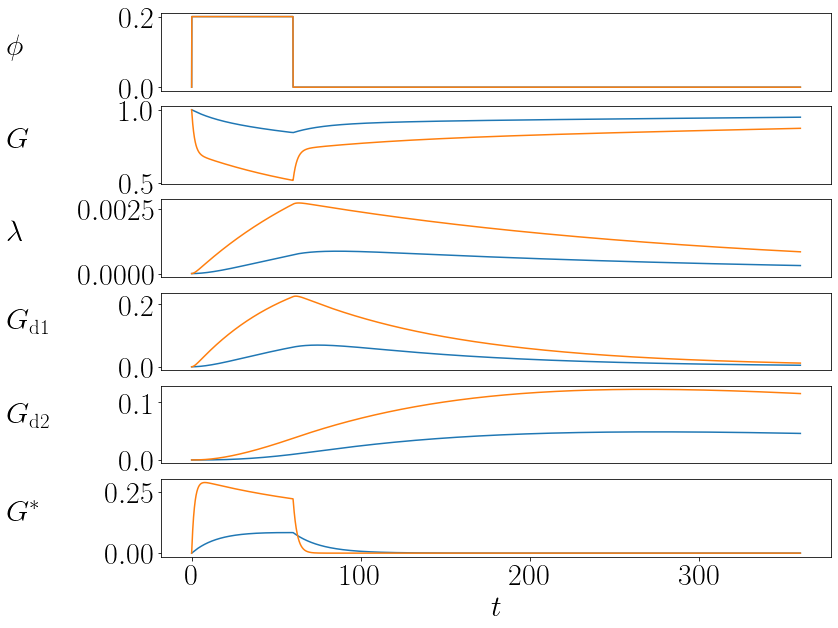

In [16]:
fig, ax = plt.subplots(6, 1, figsize=(12, 10))

cfg.input_max = 0.2
cfg.input_duration = 60
cfg.input_start = 0
sol = run_gpcr_experiment('pulse', t_f=360)
plot_experiment_plots(['glut', 'G', 'lamb', 'Gd1', 'Gd2', 'Gstar'], ax)

cfg.kp = cfg.kp * 30
cfg.km = cfg.km * 10
sol = run_gpcr_experiment('pulse', t_f=360)
plot_experiment_plots(['glut', 'G', 'lamb', 'Gd1', 'Gd2', 'Gstar'], ax)


cfg.kp = 0.03
cfg.km = 0.04


In [53]:
for i in results.index:
    row = results.loc[i]
    t = row['t']
    c = row['c']
    results.loc[i, 'response_type'] = calcium_response_classification(t, c, peak_priority=True)

In [55]:
results = pd.read_pickle('data/ip3_classification')

In [57]:
get_input_plot('curve')

(array([0.000e+00, 1.000e-01, 2.000e-01, ..., 3.997e+02, 3.998e+02,
        3.999e+02]),
 array([0.        , 0.0002598 , 0.00051779, ..., 0.00098549, 0.00098473,
        0.00098396]))

In [62]:
results.to_pickle('data/ip3_classification')

Text(1.5, -0.5, 'ip3')

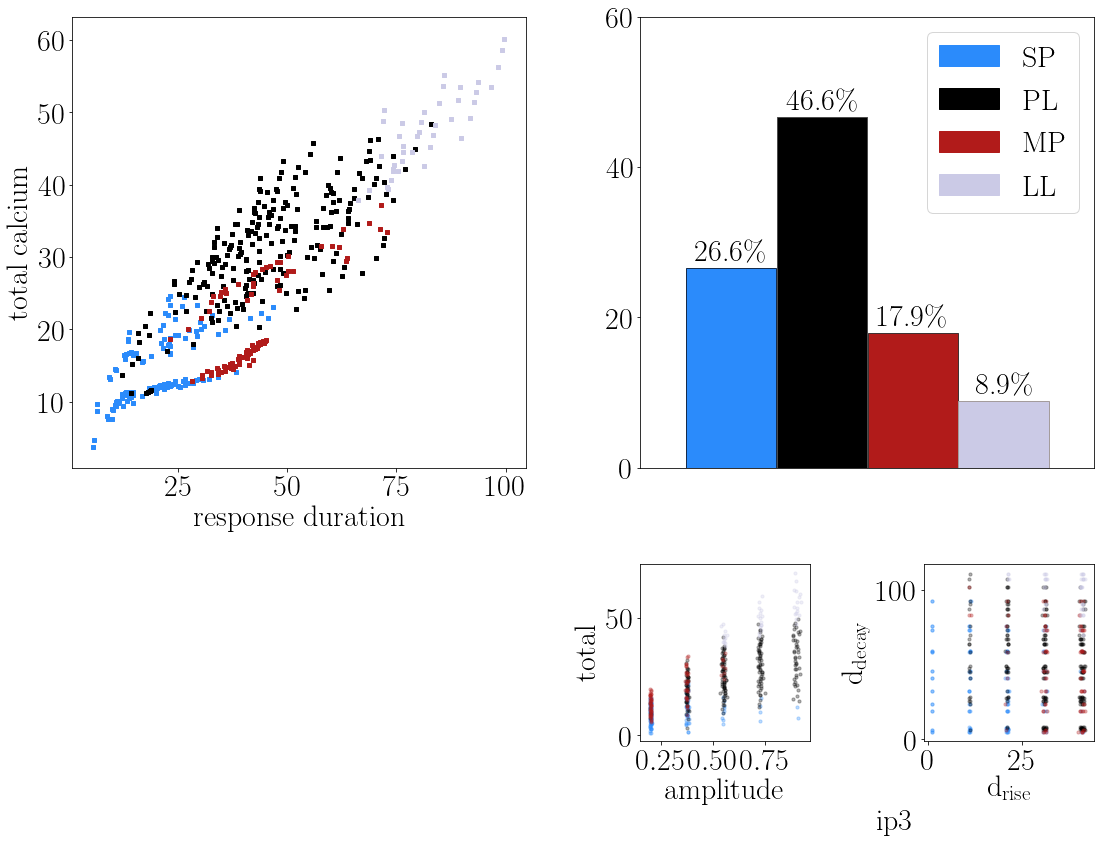

In [121]:
results = pd.read_pickle('data/ip3_classification')
fig = plt.figure(constrained_layout=False, figsize=(16, 12))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:2, :2])
diversity_dotplot(results, ax=ax, legend=False)
ax = fig.add_subplot(gs[:2, 2:])
diversity_barchart(results, ax=ax, legend=True)
subs = [('Gstar', 'size'), ('Gstar', 'shape'), ('ip3', 'size'), ('ip3', 'shape')]
xlabels = ['amplitude', 'd$_\mathrm{rise}$', 'amplitude', 'd$_\mathrm{rise}$']
ylabels = ['total', 'd$_\mathrm{decay}$', 'total', 'd$_\mathrm{decay}$']
axs = []
for i, plot in enumerate(subs):
    if i < 2:
        continue
    ax = fig.add_subplot(gs[2:, i])
    plot_intermediate_characteristics(results, plot[0], plot[1], ax, s=10, wiggle=True, alpha=0.3)
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])
    axs.append(ax)

plt.tight_layout()
axs[0].text(1.5, -0.5, 'ip3', ha='center', transform=axs[0].transAxes)



In [60]:
for i in tqdm(results.index):
    row = results.loc[i]
    cfg.A = row['A']
    cfg.d_decay = row['d_decay']
    cfg.d_rise = row['d_rise']
    cfg.r_rise = row['r_rise']
    cfg.r_decay = row['r_decay']
    
    t, p = get_input_plot('curve', max_step=0.5)
    amp, total, drise, ddecay = classify_ip3_response(t, p)
    results.loc[i, 'ip3_A'] = amp
    results.loc[i, 'ip3_total'] = total
    results.loc[i, 'ip3_drise'] = drise
    results.loc[i, 'ip3_ddecay'] = ddecay
    

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 78.22it/s]


In [61]:
results

A  d_decay  d_rise   r_decay  r_rise  response_type  response_duration  \
0    0.2       15       1  0.245925   0.002             SP                5.4   
1    0.2       56       1  0.065873   0.002             SP                8.8   
2    0.2       97       1  0.038030   0.002             SP               10.0   
3    0.2      138       1  0.026731   0.002             SP               10.6   
4    0.2      179       1  0.020608   0.002             SP               11.2   
..   ...      ...     ...       ...     ...            ...                ...   
595  0.9       56      41  0.092731   0.800  O (too large)               49.6   
596  0.9       97      41  0.053536   0.800  O (too large)               56.2   
597  0.9      138      41  0.037630   0.800  O (too large)               72.2   
598  0.9      179      41  0.029011   0.800  O (too large)               85.8   
599  0.9      220      41  0.023604   0.800  O (too large)               99.2   

       c_total                                                  t  \
0     3.749632  [0.0, 0.09461978238179451, 0.29461978238179454...   
1     7.677894  [0.0, 0.09461978238179451, 0.29461978238179454...   
2     8.895735  [0.0, 0.09461978238179451, 0.29461978238179454...   
3     9.492625  [0.0, 0.09461978238179451, 0.29461978238179454...   
4     9.881753  [0.0, 0.09461978238179451, 0.29461978238179454...   
..         ...                                                ...   
595  45.862083  [0.0, 0.08368829900610347, 0.2836882990061035,...   
596  48.352121  [0.0, 0.08368829900610347, 0.2836882990061035,...   
597  52.818416  [0.0, 0.08368829900610347, 0.2836882990061035,...   
598  57.571013  [0.0, 0.08368829900610347, 0.2836882990061035,...   
599  62.485087  [0.0, 0.08368829900610347, 0.2836882990061035,...   

                                                     c  ip3_A  ip3_total  \
0    [0.0951442, 0.09099850763573976, 0.08996877548...    0.2   0.914305   
1    [0.0951442, 0.09099850763573976, 0.08996877548...    0.2   3.136452   
2    [0.0951442, 0.09099850763573976, 0.08996877548...    0.2   5.359232   
3    [0.0951442, 0.09099850763573976, 0.08996877548...    0.2   7.581906   
4    [0.0951442, 0.09099850763573976, 0.08996877548...    0.2   9.802322   
..                                                 ...    ...        ...   
595  [0.0951442, 0.09266177659649476, 0.12773020833...    0.9  45.467232   
596  [0.0951442, 0.09266177659649476, 0.12773020833...    0.9  52.572275   
597  [0.0951442, 0.09266177659649476, 0.12773020833...    0.9  59.677722   
598  [0.0951442, 0.09266177659649476, 0.12773020833...    0.9  66.782428   
599  [0.0951442, 0.09266177659649476, 0.12773020833...    0.9  73.880992   

     ip3_drise  ip3_ddecay  
0          1.0         5.0  
1          1.0        19.0  
2          1.0        32.5  
3          1.0        46.0  
4          1.0        59.5  
..         ...         ...  
595       41.0        28.5  
596       41.0        49.0  
597       41.0        70.0  
598       41.0        90.5  
599       41.0       111.0  

[600 rows x 14 columns]

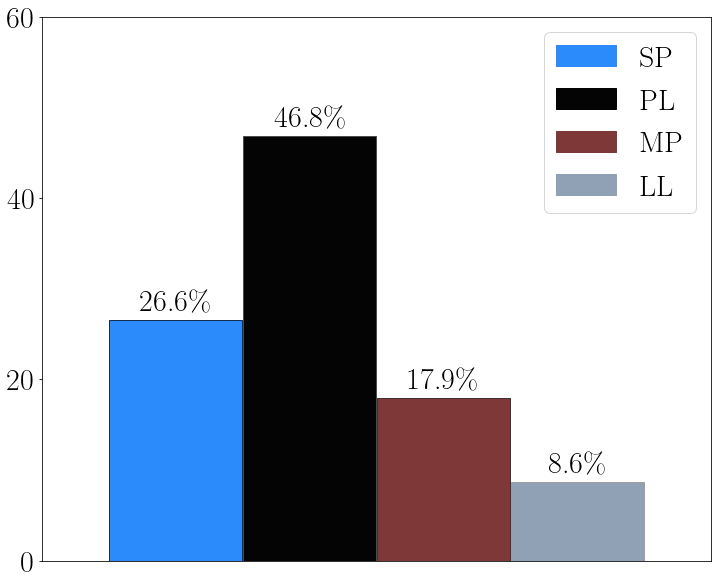

In [74]:
diversity_barchart(results)

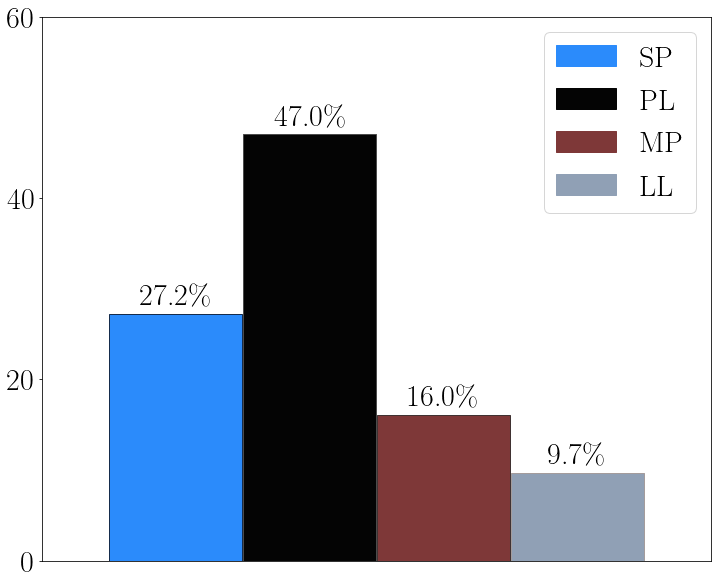

In [54]:
diversity_barchart(results)

In [79]:
results.to_pickle('data/ip3_classification')

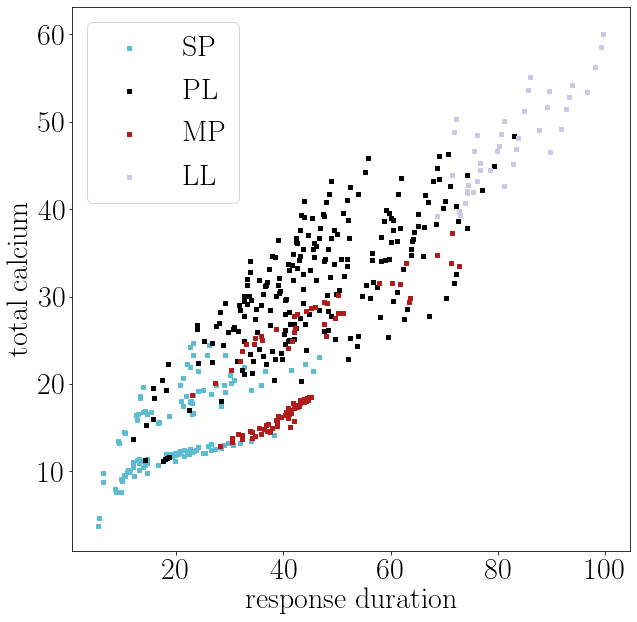

In [75]:
diversity_dotplot(results)

In [81]:
A_range = [0.2, 0.375, 0.55, 0.725, 0.9]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
#r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
    for r_rise in r_rise_range:
        for d_decay in d_decay_range:
            r_decay = compute_r_decay(A, d_decay)


In [93]:
defaults = {
    'A': 0.55,
    'd_decay': 56,
    'd_rise': 21,
    'r_rise': 0.15,
    'r_decay': compute_r_decay(0.55, 56)
}
ranges = {
    'A': [0.2, 0.375, 0.55, 0.725, 0.9],
    'd_decay': [15, 56, 97, 138, 179],
    'd_rise': [1, 11, 21, 31, 41],
    'r_rise': [0.003, 0.07, 0.15, 0.3, 0.8]
}

setting A0.2
setting A0.375
setting A0.55
setting A0.725
setting A0.9
setting d_decay15
setting d_decay56
setting d_decay97
setting d_decay138
setting d_decay179
setting d_rise1
setting d_rise11
setting d_rise21
setting d_rise31
setting d_rise41
setting r_rise0.003
setting r_rise0.07
setting r_rise0.15
setting r_rise0.3
setting r_rise0.8


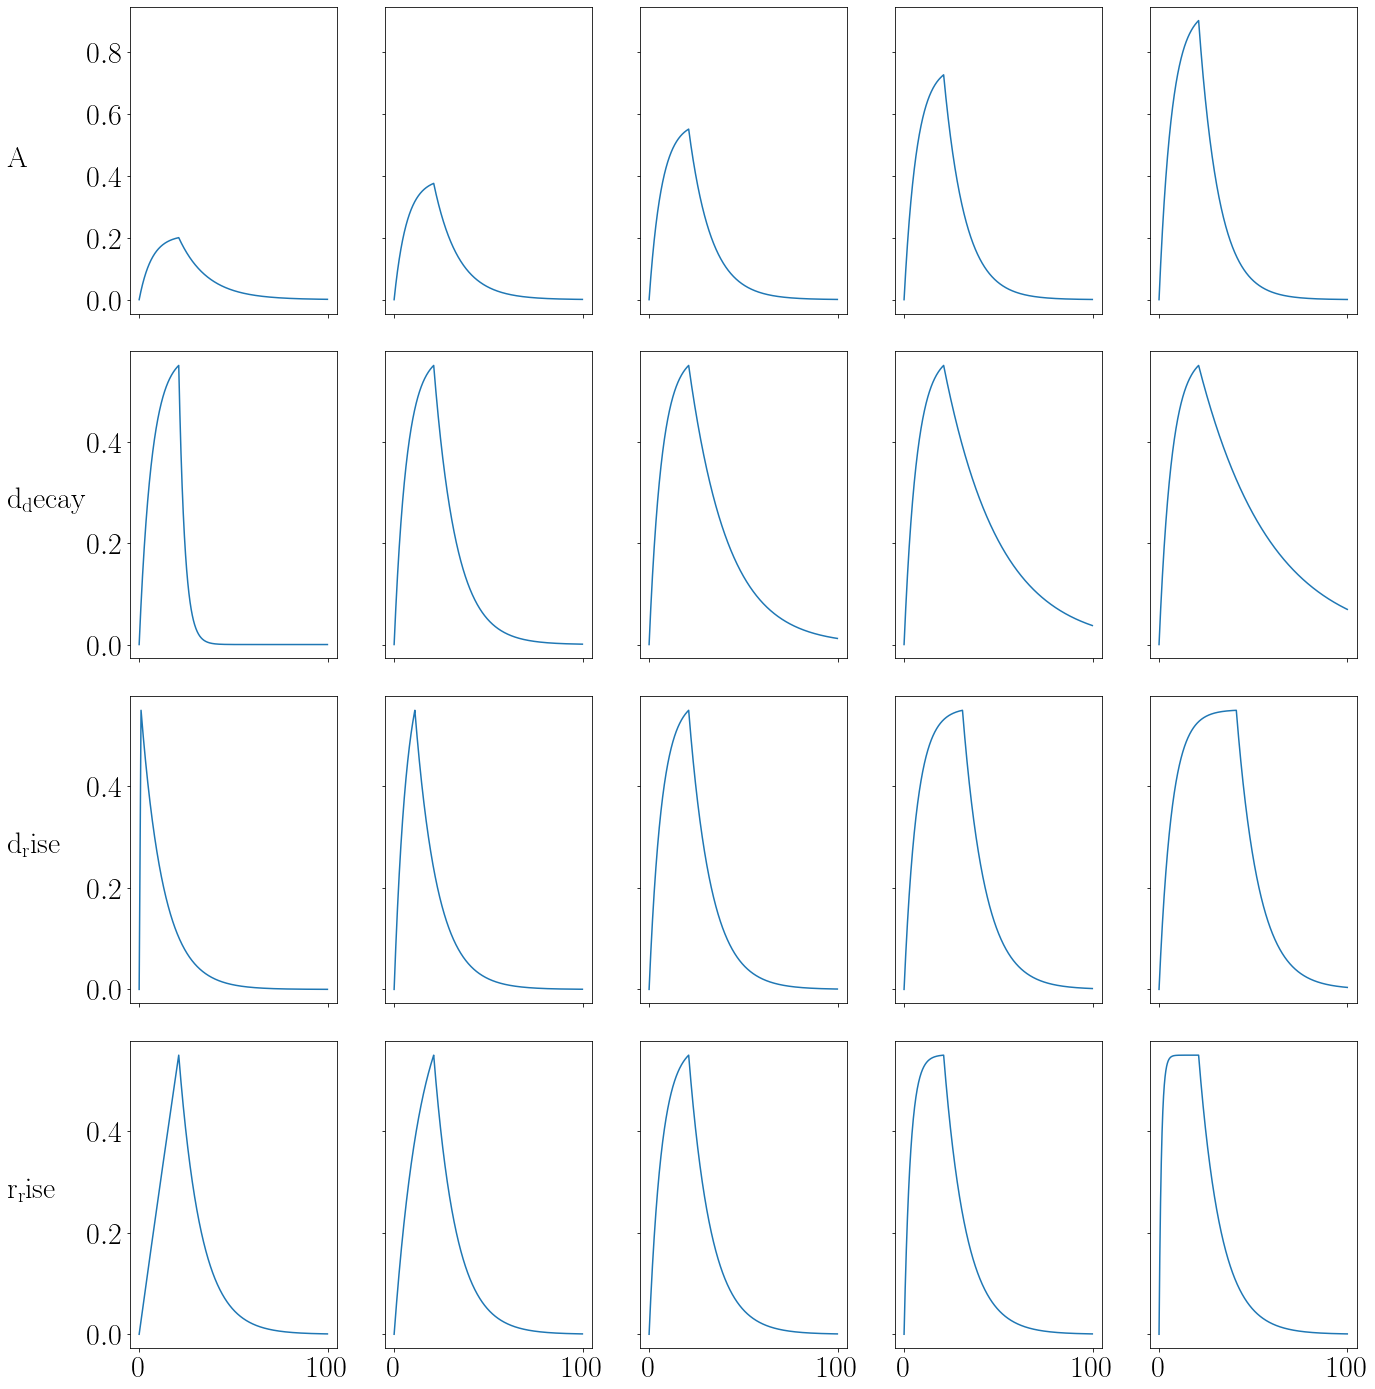

In [101]:
cfg.t_f = 100
fig, ax = plt.subplots(4, 5, figsize=(20,20), sharex=True, sharey='row')
for i, key in enumerate(ranges):
    for key2 in defaults:
        setattr(cfg, key2, defaults[key2])
        
    for j in range(5):
#         print('setting ' + key + str(ranges[key][j]) )
        setattr(cfg, key, ranges[key][j])
        cfg.r_decay = compute_r_decay(cfg.A, cfg.d_decay)
        t, p = get_input_plot('curve')
        ax[i, j].plot(t, p)
        
    ax[i, 0].set_ylabel('$\mathrm{' + key + '}$', rotation=0, ha='left', va='center', labelpad=80)
plt.tight_layout()

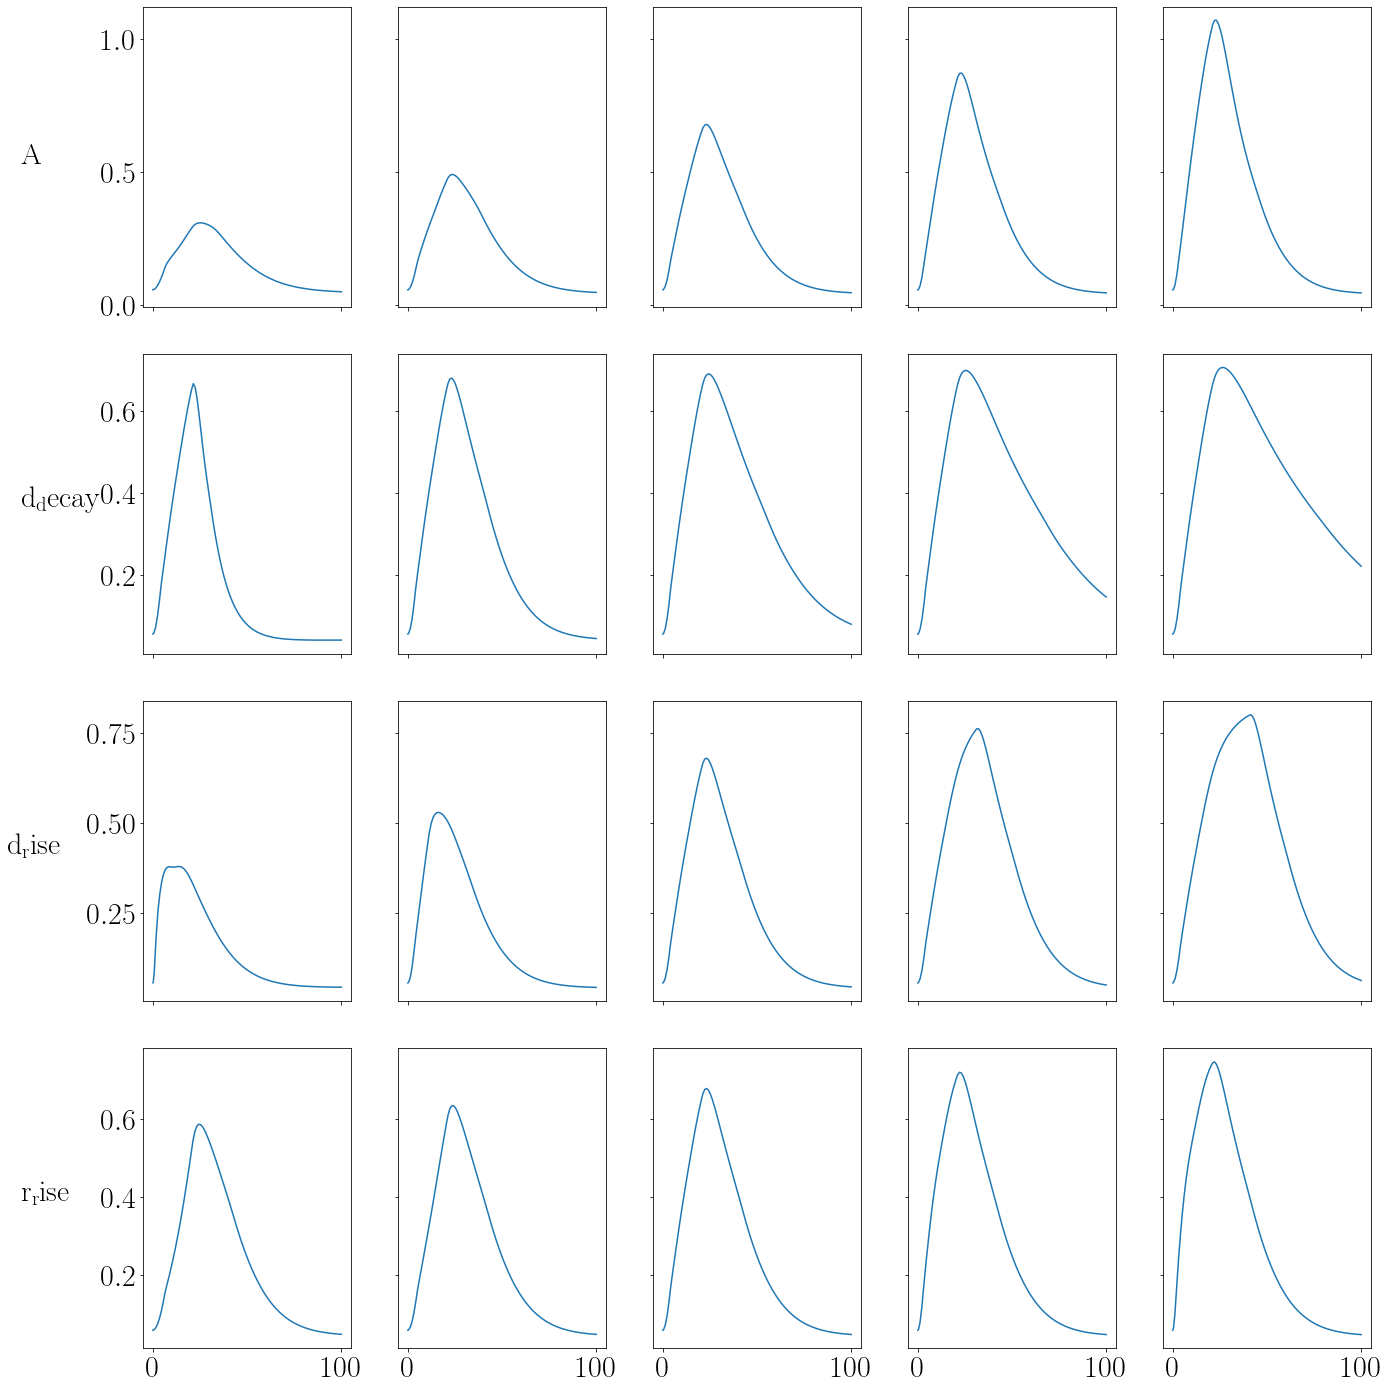

In [102]:
cfg.t_f = 100
fig, ax = plt.subplots(4, 5, figsize=(20,20), sharex=True, sharey='row')
for i, key in enumerate(ranges):
    for key2 in defaults:
        setattr(cfg, key2, defaults[key2])
        
    for j in range(5):
        setattr(cfg, key, ranges[key][j])
        cfg.r_decay = compute_r_decay(cfg.A, cfg.d_decay)
        run_Gstar_controlled_experiment('curve', t_f=100, max_step=1)
        
        ax[i, j].plot(cfg.t, cfg.p)
        
    ax[i, 0].set_ylabel('$\mathrm{' + key + '}$', rotation=0, ha='left', va='center', labelpad=80)
plt.tight_layout()

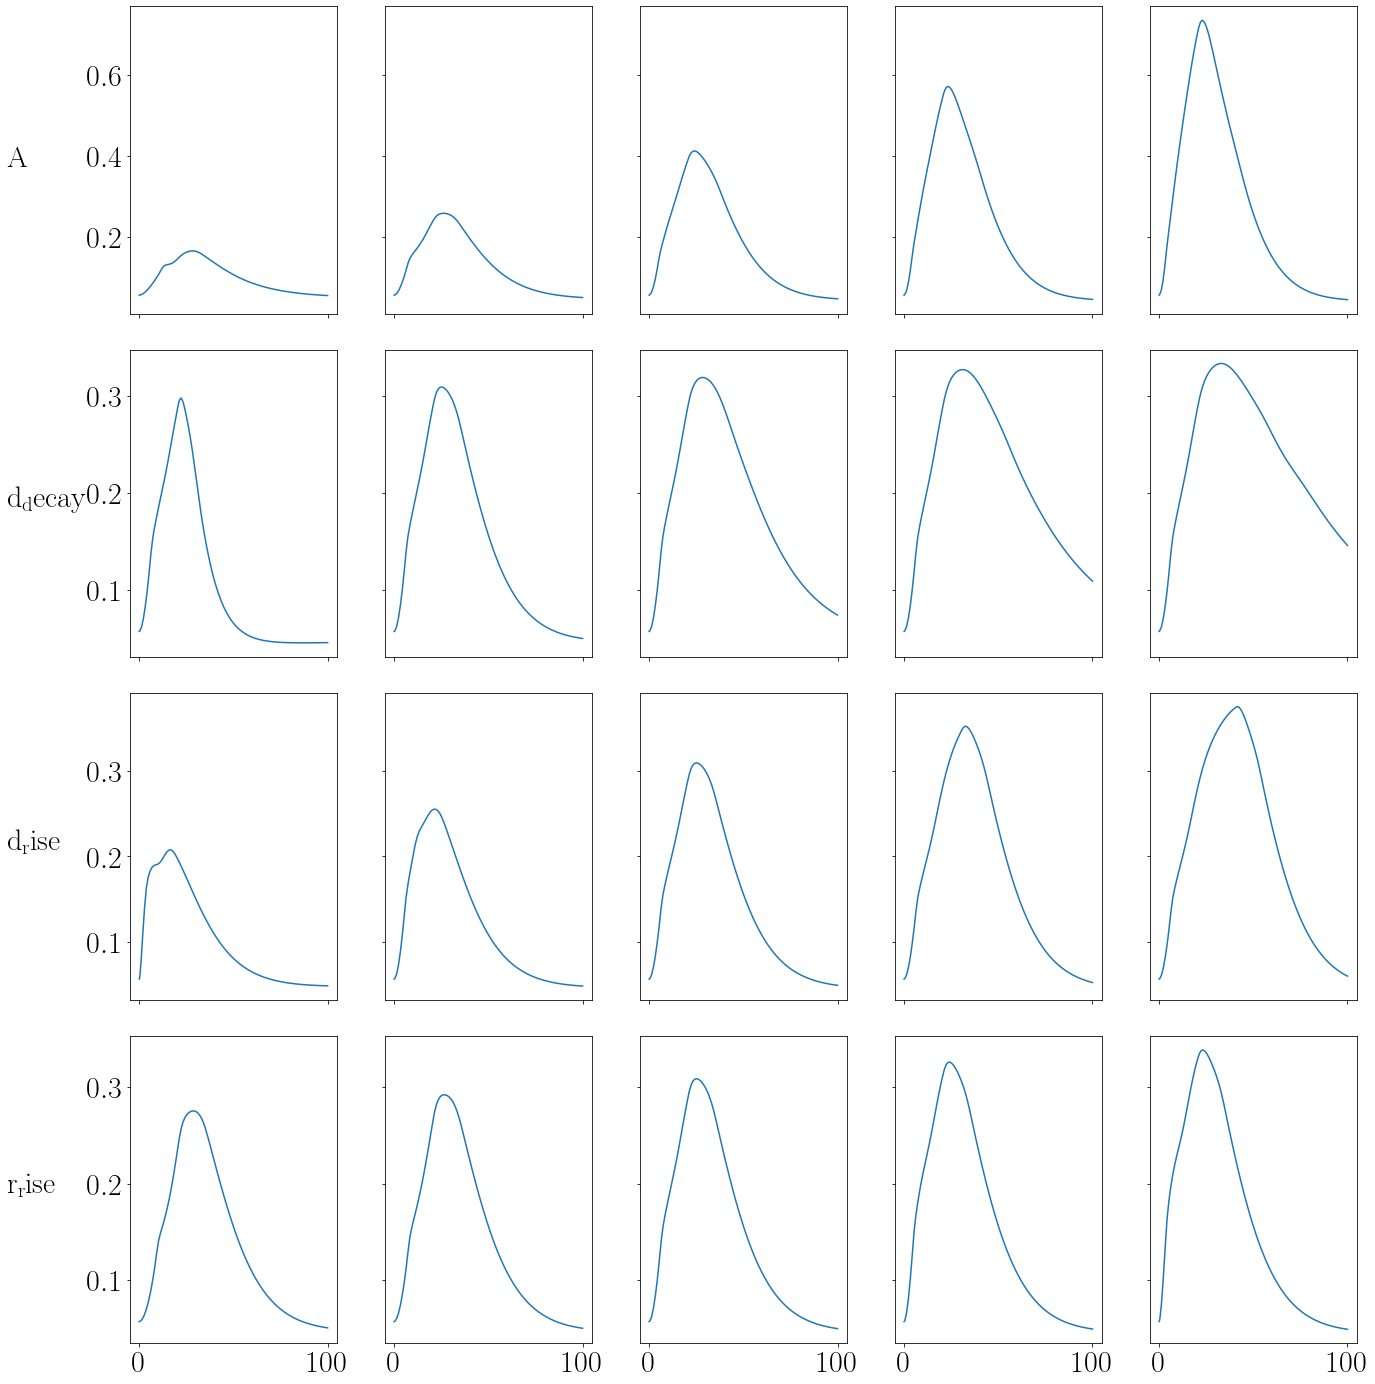

In [120]:
defaults = {
    'A': 0.2, 
    'd_decay': 56,
    'd_rise': 21,
    'r_rise': 0.15,
    'r_decay': compute_r_decay(0.55, 56)
}
ranges2 = {
    'A': np.array([0.02, 0.05, 0.1, 0.15, 0.2]) * 3,
    'd_decay': [15, 56, 97, 138, 179],
    'd_rise': [1, 11, 21, 31, 41],
    'r_rise': [0.003, 0.07, 0.15, 0.3, 0.8]
}

cfg.t_f = 100
v_beta = cfg.v_beta
r_5p = cfg.r_5p
kp = cfg.kp
km = cfg.km
# cfg.v_beta = v_beta * 5
# cfg.r_5p = r_5p * 5

cfg.kp = kp * 5
cfg.km = km * 5

fig, ax = plt.subplots(4, 5, figsize=(20,20), sharex=True, sharey='row')
for i, key in enumerate(ranges2):
    for key2 in defaults:
        setattr(cfg, key2, defaults[key2])
        
    for j in range(5):
        setattr(cfg, key, ranges2[key][j])
        cfg.r_decay = compute_r_decay(cfg.A, cfg.d_decay)
        run_Gstar_controlled_experiment('curve', t_f=100, max_step=1)
        
        ax[i, j].plot(cfg.t, cfg.p)
        
    ax[i, 0].set_ylabel('$\mathrm{' + key + '}$', rotation=0, ha='left', va='center', labelpad=80)
plt.tight_layout()

cfg.kp = kp
cfg.km = km
# cfg.v_beta = v_beta
# cfg.r_5p = r_5p

In [200]:
A_range = [0.2, 0.375, 0.55, 0.725, 0.9]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
#r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0
cfg.t_f = 400
results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
        if d_rise < 8:
            r_rise_range = [0.002, 12]
        elif d_rise < 15:
            r_rise_range = [0.002, 0.44, 1.6]
        elif d_rise < 30:
            r_rise_range = [0.002, 0.12, 0.3, 1]
        elif d_rise < 40:
            r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
        else:
            r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]
            
        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)
                cfg.A = A
                cfg.d_rise = d_rise
                cfg.r_rise = r_rise
                cfg.d_decay = d_decay
                cfg.r_decay = r_decay
                t, p = get_input_plot('curve')

                amp, total, drise, ddecay = classify_ip3_response(t, p, 0)
                results_rows.append({
                    'ip3_A': A,
                    'ip3_drise': drise,
                    'ip3_ddecay': ddecay,
                    'ip3_total': total
                })

results = pd.DataFrame(results_rows)
            

In [30]:

ranges = {
    'A': np.array([0.02, 0.05, 0.1, 0.15, 0.2]) * 3,
    'd_decay': [15, 56, 97, 138, 179],
    'd_rise': [1, 11, 21, 31, 41],
    'r_rise': [0.003, 0.07, 0.15, 0.3, 0.8]
}

cfg.t_f = 400
c_tot_default = cfg.all_init[1]
cfg.all_init[1] = 0.6 * c_tot_default
trial_count = 0
results_rows = []

# fig, ax = plt.subplots(4, 5, figsize=(20,20), sharex=True, sharey='row')
for A in ranges['A']:
    for d_decay in ranges['d_decay']:
        for d_rise in ranges['d_rise']:
            for r_rise in ranges['r_rise']:
                r_decay = compute_r_decay(A, d_decay)
                cfg.A = A
                cfg.d_rise = d_rise
                cfg.r_rise = r_rise
                cfg.d_decay = d_decay
                cfg.r_decay = r_decay
                
                sol = run_Gstar_controlled_experiment('curve', t_f=400, max_step=0.5)
                
                ip3_amp, ip3_total, ip3_drise, ip3_ddecay = classify_ip3_response()
                response_type = calcium_response_classification(cfg.t, cfg.c)
                peaks, troughs = calcium_peaks_and_troughs(cfg.t, cfg.c)
                response_characteristics = calcium_response_characteristics(cfg.t, cfg.c, peaks)
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': cfg.t,
                    'c': cfg.c,
                    'ip3_A': ip3_amp,
                    'ip3_drise': ip3_drise,
                    'ip3_ddecay': ip3_ddecay,
                    'ip3_total': ip3_total
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)
results.to_pickle('data/ca_diversity/Gstar_3_ct_0.6')

cfg.all_init[1] = c_tot_default
        

Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600


In [40]:
ranges = {
    'A': np.array([0.02, 0.05, 0.1, 0.15, 0.2]),
    'd_decay': [15, 56, 97, 138, 179],
    'd_rise': [1, 11, 21, 31, 41],
    'r_rise': [0.003, 0.07, 0.15, 0.3, 0.8]
}

cfg.t_f = 400
c_tot_default = cfg.all_init[1]
cfg.all_init[1] = 0.6 * c_tot_default

trial_count = 0
results_rows = []

# fig, ax = plt.subplots(4, 5, figsize=(20,20), sharex=True, sharey='row')
for A in ranges['A']:
    for d_decay in ranges['d_decay']:
        for d_rise in ranges['d_rise']:
            for r_rise in ranges['r_rise']:
                r_decay = compute_r_decay(A, d_decay)
                cfg.A = A
                cfg.d_rise = d_rise
                cfg.r_rise = r_rise
                cfg.d_decay = d_decay
                cfg.r_decay = r_decay
                
                sol = run_Gstar_controlled_experiment('curve', t_f=400, max_step=0.5)
                
                ip3_amp, ip3_total, ip3_drise, ip3_ddecay = classify_ip3_response()
                try:
                    response_type = calcium_response_classification(cfg.t, cfg.c)
                    peaks, troughs = calcium_peaks_and_troughs(cfg.t, cfg.c)
                    response_characteristics = calcium_response_characteristics(cfg.t, cfg.c, peaks)
                except:
                    response_type = 'O (too small)'
                    response_characteristics = [0, 0, 0, 0, 0, 0]
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': cfg.t,
                    'c': cfg.c,
                    'ip3_A': ip3_amp,
                    'ip3_drise': ip3_drise,
                    'ip3_ddecay': ip3_ddecay,
                    'ip3_total': ip3_total
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)
results.to_pickle('data/ca_diversity/Gstar_ct_0.6')
cfg.all_init[1] = c_tot_default


Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600


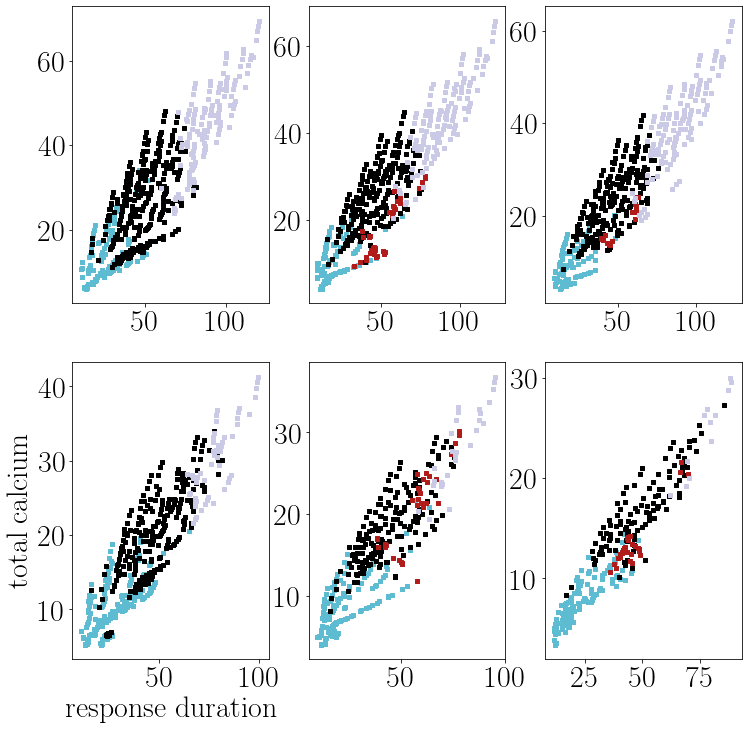

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(12,12))
files = ['Gstar_3', 'Gstar_3_ct_0.8', 'Gstar_3_ct_0.6', 'Gstar', 'Gstar_ct_0.8', 'Gstar_ct_0.6']
for n, file in enumerate(files):
    i = int(np.floor(n / 3))
    j = n % 3
    results = pd.read_pickle('data/ca_diversity/' + file)
    labels = False
    if i == 1 and j == 0:
        labels = True
    diversity_dotplot(results, ax=ax[i,j], legend=False, labels=labels)

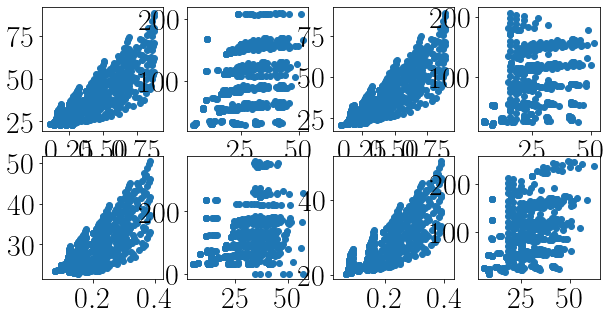

In [42]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
files = ['Gstar_3', 'Gstar_3_ct_0.8', 'Gstar', 'Gstar_ct_0.8']
for n, file in enumerate(files):
    i = int(np.floor(n / 2))
    j = n % 2 * 2
    results = pd.read_pickle('data/ca_diversity/' + file)
    ax[i, j].scatter(results['ip3_A'], results['ip3_total'])
    ax[i, j+1].scatter(results['ip3_drise'], results['ip3_ddecay'])

# ax[0].scatter(results['ip3_A'], results['ip3_total'])
# ax[1].scatter(results['ip3_drise'], results['ip3_ddecay'])

In [4]:
kp

0.03

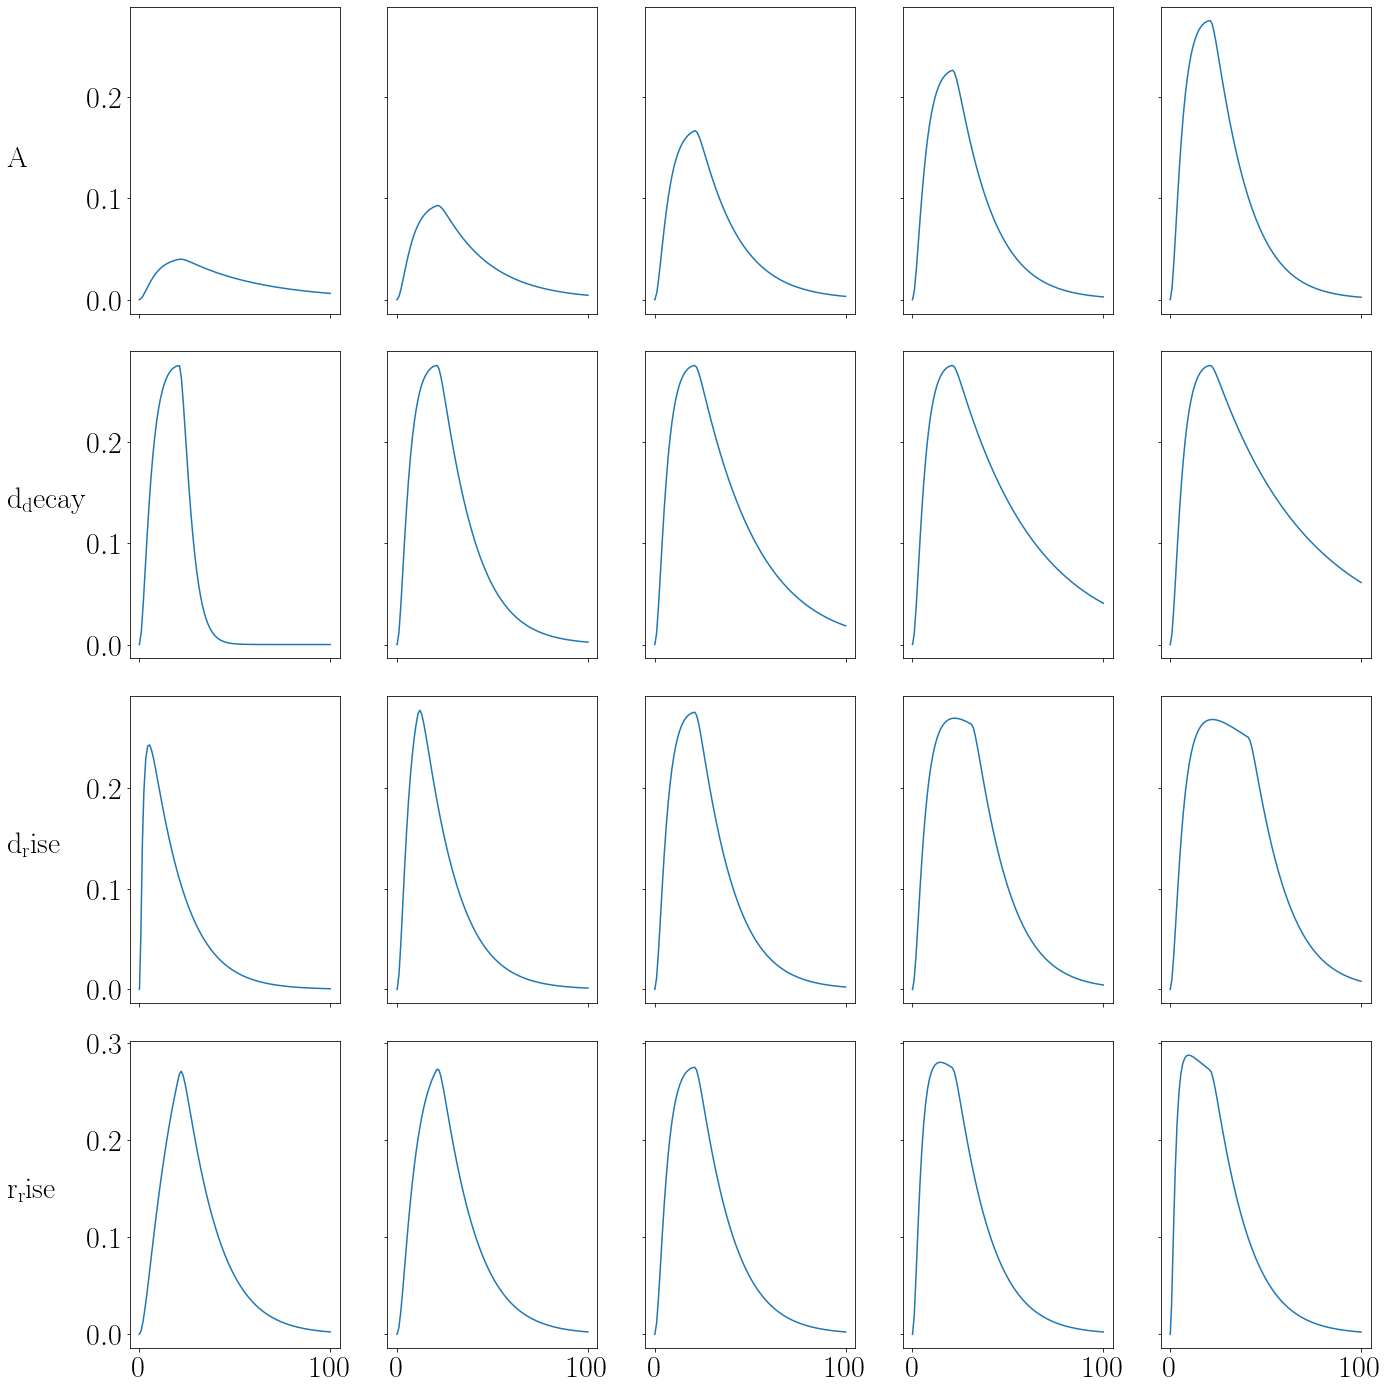

In [7]:
defaults = {
    'A': 0.2, 
    'd_decay': 56,
    'd_rise': 21,
    'r_rise': 0.15,
    'r_decay': compute_r_decay(0.55, 56)
}
ranges2 = {
    'A': np.array([0.02, 0.05, 0.1, 0.15, 0.2]),
    'd_decay': [15, 56, 97, 138, 179],
    'd_rise': [1, 11, 21, 31, 41],
    'r_rise': [0.003, 0.07, 0.15, 0.3, 0.8]
}

cfg.t_f = 100
v_beta = cfg.v_beta
r_5p = cfg.r_5p
kp = cfg.kp
km = cfg.km
# cfg.v_beta = v_beta * 5
# cfg.r_5p = r_5p * 5

cfg.kp = kp * 30
cfg.km = km * 10
# print(cfg.kp)
# print(cfg.km)

fig, ax = plt.subplots(4, 5, figsize=(20,20), sharex=True, sharey='row')
for i, key in enumerate(ranges2):
    for key2 in defaults:
        setattr(cfg, key2, defaults[key2])
        
    for j in range(5):
        setattr(cfg, key, ranges2[key][j])
        cfg.r_decay = compute_r_decay(cfg.A, cfg.d_decay)
        run_experiment('curve', t_f=100, max_step=1)
        
        ax[i, j].plot(cfg.t, cfg.Gstar)
        
    ax[i, 0].set_ylabel('$\mathrm{' + key + '}$', rotation=0, ha='left', va='center', labelpad=80)
plt.tight_layout()

cfg.kp = kp
cfg.km = km
# cfg.v_beta = v_beta
# cfg.r_5p = r_5p

In [25]:
cfg.input_max = 0

In [77]:
cfg.input_duration = 9000
sol = run_experiment('pulse', t_f=9000, max_step=10)

In [80]:
all_init = cfg.all_init

In [78]:
cfg.all_init = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]


In [108]:
ranges = {
    'A': np.array([0.02, 0.04, 0.07, 0.1, 0.2]),
    'd_decay': [15, 56, 97, 138, 179],
    'd_rise': [1, 11, 21, 31, 41],
    'r_rise': [0.003, 0.07, 0.15, 0.3, 0.8]
    
#     'A': np.array([0.02, 0.05, 0.2]),
#     'd_decay': [15, 56, 138],
#     'd_rise': [1, 21, 41],
#     'r_rise': [0.003, 0.15, 0.8]
}

t_f = 250
# cfg.kp = 1.5
# cfg.kd2 = 1.2
# cfg.v_delta = 0.005
# cfg.v_pmca = 5

# cfg.all_init[1] = c_tot_default * 0.8

trial_count = 0
results_rows = []

# fig, ax = plt.subplots(4, 5, figsize=(20,20), sharex=True, sharey='row')
for A in ranges['A']:
    for d_decay in ranges['d_decay']:
        for d_rise in ranges['d_rise']:
            for r_rise in ranges['r_rise']:
                r_decay = compute_r_decay(A, d_decay)
                cfg.A = A
                cfg.d_rise = d_rise
                cfg.r_rise = r_rise
                cfg.d_decay = d_decay
                cfg.r_decay = r_decay
                
                sol = run_experiment('curve', t_f=t_f, max_step=0.5)
                
                try:
                    ip3_amp, ip3_total, ip3_drise, ip3_ddecay = classify_ip3_response()
                    Gstar_amp, Gstar_total, Gstar_drise, Gstar_ddecay = classify_ip3_response(cfg.t, cfg.Gstar)
                    response_type = calcium_response_classification(cfg.t, cfg.c)
                    peaks, troughs = calcium_peaks_and_troughs(cfg.t, cfg.c)
                    response_characteristics = calcium_response_characteristics(cfg.t, cfg.c, peaks)
                except:
                    response_type = 'O (too small)'
                    ip3_amp, ip3_total, ip3_drise, ip3_ddecay = [0,0,0,0]
                    Gstar_amp, Gstar_total, Gstar_drise, Gstar_ddecay = [0,0,0,0]
                    response_characteristics = [0,0,0,0,0,0]
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': cfg.t,
                    'c': cfg.c,
                    'ip3_A': ip3_amp,
                    'ip3_drise': ip3_drise,
                    'ip3_ddecay': ip3_ddecay,
                    'ip3_total': ip3_total,
                    'Gstar_A': Gstar_amp,
                    'Gstar_drise': Gstar_drise,
                    'Gstar_ddecay': Gstar_ddecay,
                    'Gstar_total': Gstar_total
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)
# results.to_pickle('data/ca_diversity/kp_1.5_kd2_1.2_vdelta_0.005_vpmca_0')
# cfg.all_init[1] = c_tot_default
# set_init()

Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600


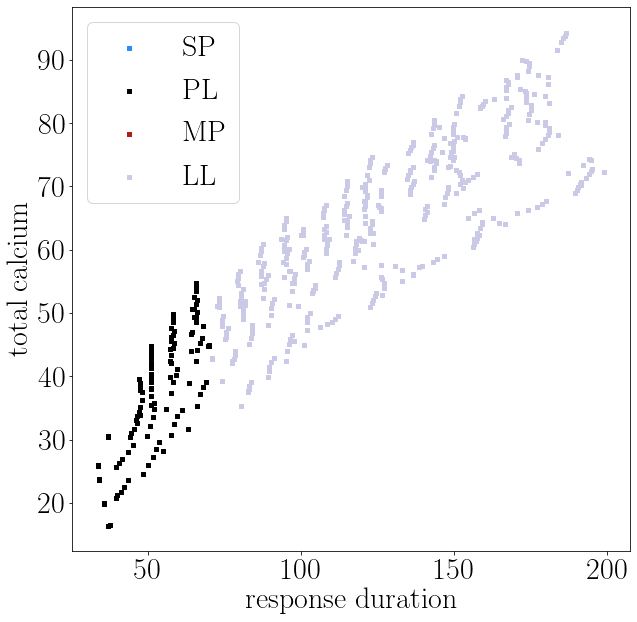

In [109]:
diversity_dotplot(results)

In [83]:
cfg.all_init

[0.09120489224350624,
 37.46713000685549,
 0.6516701788023139,
 0.028079273932201262,
 0.0,
 0.0,
 0.0,
 0.0]

In [60]:
counter = 0

In [95]:
results

A  d_decay  d_rise   r_decay  r_rise  response_type  response_duration  \
0   0.02       15       1  0.092420   0.003             PL               40.0   
1   0.02       15       1  0.092420   0.150             PL               40.0   
2   0.02       15       1  0.092420   0.800             PL               40.0   
3   0.02       15      21  0.092420   0.003             MP               48.5   
4   0.02       15      21  0.092420   0.150             MP               54.5   
..   ...      ...     ...       ...     ...            ...                ...   
76  0.20      138      21  0.026731   0.150  O (too large)              133.5   
77  0.20      138      21  0.026731   0.800  O (too large)              133.5   
78  0.20      138      41  0.026731   0.003             LL              151.0   
79  0.20      138      41  0.026731   0.150  O (too large)              153.0   
80  0.20      138      41  0.026731   0.800  O (too large)              154.0   

      c_total                                                  t  \
0   17.703332  [0.0, 0.1251451914672588, 0.6251451914672588, ...   
1   17.715785  [0.0, 0.1251451914672588, 0.6251451914672588, ...   
2   17.770336  [0.0, 0.1251451914672588, 0.6251451914672588, ...   
3   27.051708  [0.0, 0.11432757754558608, 0.6143275775455861,...   
4   30.151441  [0.0, 0.10522531913603789, 0.6052253191360379,...   
..        ...                                                ...   
76  86.650944  [0.0, 0.0663927595471545, 0.5663927595471545, ...   
77  87.545016  [0.0, 0.06456007244826341, 0.5645600724482635,...   
78  93.101662  [0.0, 0.08197842602997607, 0.5819784260299761,...   
79  95.703052  [0.0, 0.06694827664405516, 0.5669482766440551,...   
80  96.719161  [0.0, 0.06456007310116335, 0.5645600731011633,...   

                                                    c     ip3_A  ip3_drise  \
0   [0.09120489224350624, 0.09121968785044363, 0.0...  0.203100  27.125145   
1   [0.09120489224350624, 0.09121969133650007, 0.0...  0.203255  27.125145   
2   [0.09120489224350624, 0.09121970848146915, 0.0...  0.203944  26.625145   
3   [0.09120489224350624, 0.0912186612605682, 0.09...  0.316760  36.614328   
4   [0.09120489224350624, 0.09121780252744952, 0.0...  0.356095  32.105225   
..                                                ...       ...        ...   
76  [0.09120489224350624, 0.09121371955222561, 0.0...  0.924701  24.066393   
77  [0.09120489224350624, 0.09121353142938324, 0.0...  0.967637  22.564560   
78  [0.09120489224350624, 0.09121543946711815, 0.0...  0.760311  30.581978   
79  [0.09120489224350624, 0.09121378298859557, 0.0...  0.918462  24.066948   
80  [0.09120489224350624, 0.09121353142945825, 0.0...  0.967719  22.564560   

    ip3_ddecay  ip3_total   Gstar_A  Gstar_drise  Gstar_ddecay  Gstar_total  
0         80.5  14.784944  0.136445    13.125145          39.5     4.968795  
1         80.5  14.791921  0.136574    13.125145          39.5     4.973408  
2         81.0  14.822425  0.137137    13.125145          39.5     4.993581  
3         84.5  19.819240  0.216008    26.614328          47.5     8.550169  
4         87.5  21.808105  0.246508    24.605225          49.5     9.968627  
..         ...        ...       ...          ...           ...          ...  
76         0.0  73.008736  0.709257    15.066393         165.5    46.266189  
77         0.0  74.375513  0.741344    10.564560         169.0    46.990828  
78         0.0  76.111938  0.614550    28.081978         172.0    48.763107  
79         0.0  79.409724  0.703206    15.566948         182.5    50.733499  
80         0.0  80.744085  0.741344    10.564560         186.5    51.466670  

[81 rows x 18 columns]

In [ ]:
counter = 0

A: 0.02 	 d_rise: 31 	 d_decay: 15
No valid troughs that were <50% height of neighboring peaks
First response lasted for 18.0
Remaining durations is 39.49999999999999
PL


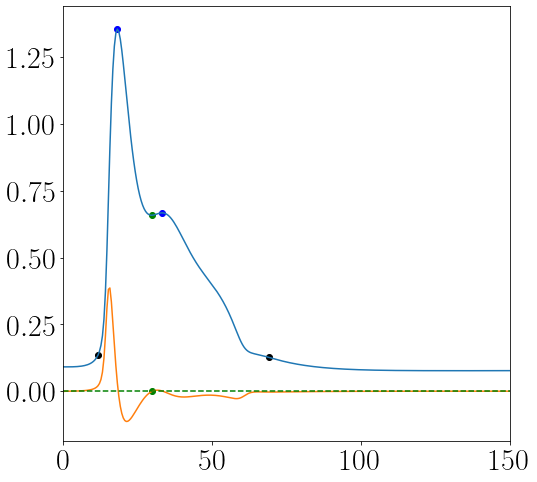

In [127]:
counter += 1
row = results.iloc[counter]
print('A: {} \t d_rise: {} \t d_decay: {}'.format(row['A'], row['d_rise'], row['d_decay']))
t = results.iloc[counter]['t']
c = results.iloc[counter]['c']

fig, ax = 
visualize_classification(t, c, peak_priority=False)

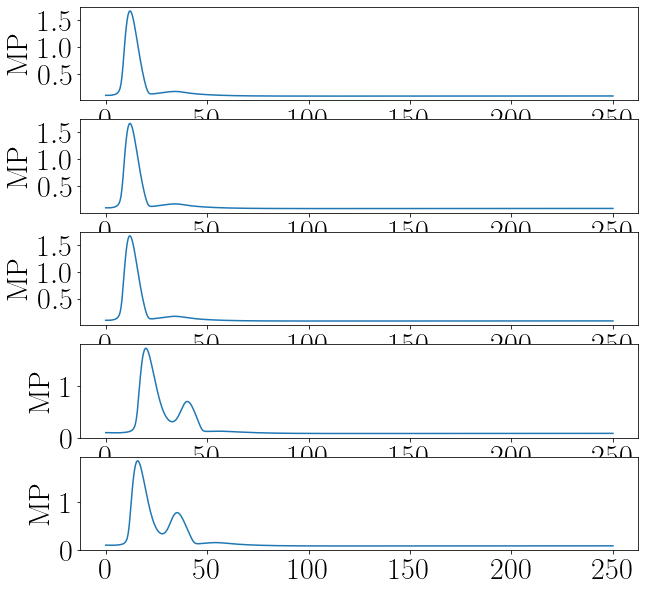

In [58]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))
for i in range(5):
    ax[i].plot(results.iloc[counter+i]['t'], results.iloc[counter+i]['c'])
    ax[i].set_ylabel(results.iloc[counter+i]['response_type'])
# counter += 5

In [3]:
kp = 0.03
km = 0.04
c_tot_default = 34.841184
all_init = cfg.all_init.copy()
# load_experiment('poisson/rate_0.2_conc_10')
# cfg.all_init = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]

ranges = {
    'A': np.array([0.02, 0.05, 0.1, 0.15, 0.2]),
    'd_decay': [15, 56, 97, 138, 179],
    'd_rise': [1, 11, 21, 31, 41],
    'r_rise': [0.003, 0.07, 0.15, 0.3, 0.8]
}

cfg.t_f = 400

cfg.kp = kp * 30
cfg.km = km * 10
# cfg.v_delta = 0
cfg.v_3k = 0
cfg.kd1 = 0.04
# cfg.all_init[1] = c_tot_default * 0.8

trial_count = 0
results_rows = []

print(cfg.kp)
print(cfg.km)
print(cfg.v_delta)
print(cfg.v_3k)
# fig, ax = plt.subplots(4, 5, figsize=(20,20), sharex=True, sharey='row')
for A in ranges['A']:
    for d_decay in ranges['d_decay']:
        for d_rise in ranges['d_rise']:
            for r_rise in ranges['r_rise']:
                r_decay = compute_r_decay(A, d_decay)
                cfg.A = A
                cfg.d_rise = d_rise
                cfg.r_rise = r_rise
                cfg.d_decay = d_decay
                cfg.r_decay = r_decay
                
                sol = run_experiment('curve', t_f=400, max_step=0.5)
                
                try:
                    ip3_amp, ip3_total, ip3_drise, ip3_ddecay = classify_ip3_response()
                    Gstar_amp, Gstar_total, Gstar_drise, Gstar_ddecay = classify_ip3_response(cfg.t, cfg.Gstar)
                    response_type = calcium_response_classification(cfg.t, cfg.c)
                    peaks, troughs = calcium_peaks_and_troughs(cfg.t, cfg.c)
                    response_characteristics = calcium_response_characteristics(cfg.t, cfg.c, peaks)
                except:
                    response_type = 'O (too small)'
                    ip3_amp, ip3_total, ip3_drise, ip3_ddecay = [0,0,0,0]
                    Gstar_amp, Gstar_total, Gstar_drise, Gstar_ddecay = [0,0,0,0]
                    response_characteristics = [0,0,0,0,0,0]
                
                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': cfg.t,
                    'c': cfg.c,
                    'ip3_A': ip3_amp,
                    'ip3_drise': ip3_drise,
                    'ip3_ddecay': ip3_ddecay,
                    'ip3_total': ip3_total,
                    'Gstar_A': Gstar_amp,
                    'Gstar_drise': Gstar_drise,
                    'Gstar_ddecay': Gstar_ddecay,
                    'Gstar_total': Gstar_total
                })
                
                trial_count += 1
                
                if(trial_count % 50 == 0):
                    print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)
results.to_pickle('data/ca_diversity/kd1_0.04')
cfg.all_init[1] = c_tot_default
# cfg.all_init = all_init
cfg.v_3k = 0.1
cfg.v_delta = 0.01
cfg.kp = kp
cfg.km = km

0.8999999999999999
0.4
0.01
0
Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600


No valid troughs that were <50% height of neighboring peaks
First response lasted for 64.0
Remaining durations is -46.0
SP


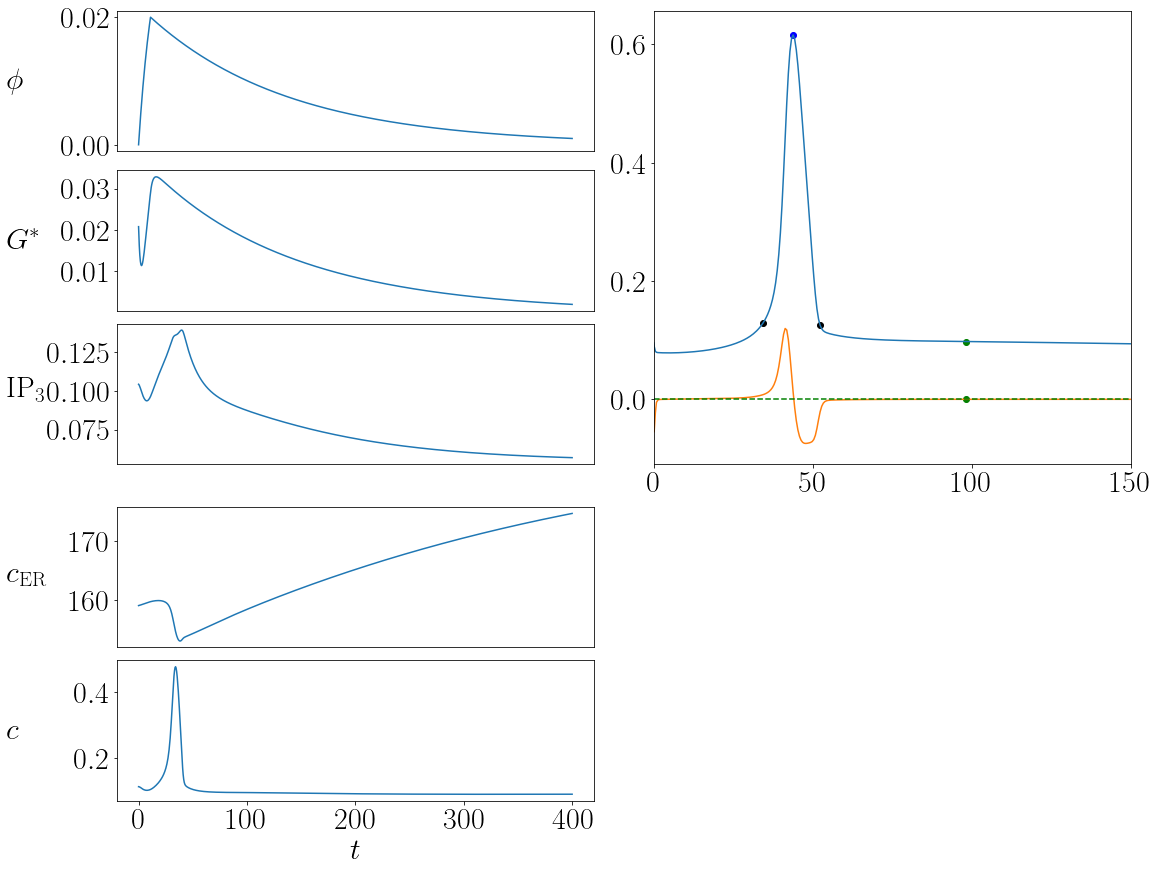

In [31]:
row = r.iloc[counter]
# classification_simulation_with_row(row, poisson_start=True, kpkm=[30,10], max_step=0.5)
# fig, ax = plt.subplots(5, 2, figsize=)
fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = fig.add_gridspec(5, 2)
axs = [fig.add_subplot(gs[i, 0]) for i in range(5)]

plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], axs)

ax = fig.add_subplot(gs[:3, 1])
vis_dict = visualize_classification(row['t'], row['c'], ax=ax, ret=True, peak_priority=True)

counter += 1

In [43]:
responses = []
for idx in results.index:
    row = results.loc[idx]
    results.loc[idx, 'response_type'] = calcium_response_classification(row['t'], row['c'], peak_priority=True)
# responses = np.array(responses)

In [7]:
results

A  d_decay  d_rise   r_decay  r_rise  response_type  \
0    0.02       15       1  0.092420   0.003  O (too small)   
1    0.02       15       1  0.092420   0.070  O (too small)   
2    0.02       15       1  0.092420   0.150  O (too small)   
3    0.02       15       1  0.092420   0.300  O (too small)   
4    0.02       15       1  0.092420   0.800  O (too small)   
..    ...      ...     ...       ...     ...            ...   
620  0.20      179      41  0.020608   0.003  O (too small)   
621  0.20      179      41  0.020608   0.070  O (too small)   
622  0.20      179      41  0.020608   0.150  O (too small)   
623  0.20      179      41  0.020608   0.300  O (too small)   
624  0.20      179      41  0.020608   0.800  O (too small)   

     response_duration  c_total  \
0                    0        0   
1                    0        0   
2                    0        0   
3                    0        0   
4                    0        0   
..                 ...      ...   
620                  0        0   
621                  0        0   
622                  0        0   
623                  0        0   
624                  0        0   

                                                     t  \
0    [0.0, 0.11693576985042209, 0.6169357698504221,...   
1    [0.0, 0.11630785445354024, 0.6163078544535402,...   
2    [0.0, 0.11556889049096726, 0.6155688904909673,...   
3    [0.0, 0.11421524838674599, 0.614215248386746, ...   
4    [0.0, 0.11000601507297612, 0.6100060150729761,...   
..                                                 ...   
620  [0.0, 0.14324452590314157, 0.6432445259031416,...   
621  [0.0, 0.12305396589969211, 0.6230539658996921,...   
622  [0.0, 0.10890950467498645, 0.6089095046749864,...   
623  [0.0, 0.09585422673607595, 0.5958542267360759,...   
624  [0.0, 0.07952700322766902, 0.579527003227669, ...   

                                                     c  ip3_A  ip3_drise  \
0    [0.11237913458369991, 0.11225355751266881, 0.1...      0          0   
1    [0.11237913458369991, 0.11225457335945198, 0.1...      0          0   
2    [0.11237913458369991, 0.11225576445229495, 0.1...      0          0   
3    [0.11237913458369991, 0.11225793392737754, 0.1...      0          0   
4    [0.11237913458369991, 0.11226457738320293, 0.1...      0          0   
..                                                 ...    ...        ...   
620  [0.11237913458369991, 0.1122079439488313, 0.11...      0          0   
621  [0.11237913458369991, 0.11224348041427362, 0.1...      0          0   
622  [0.11237913458369991, 0.11226628146783002, 0.1...      0          0   
623  [0.11237913458369991, 0.11228575851513045, 0.1...      0          0   
624  [0.11237913458369991, 0.11230795273747528, 0.1...      0          0   

     ip3_ddecay  ip3_total  Gstar_A  Gstar_drise  Gstar_ddecay  Gstar_total  
0             0          0        0            0             0            0  
1             0          0        0            0             0            0  
2             0          0        0            0             0            0  
3             0          0        0            0             0            0  
4             0          0        0            0             0            0  
..          ...        ...      ...          ...           ...          ...  
620           0          0        0            0             0            0  
621           0          0        0            0             0            0  
622           0          0        0            0             0            0  
623           0          0        0            0             0            0  
624           0          0        0            0             0            0  

[625 rows x 18 columns]

Text(1.3, -0.5, 'ip3')

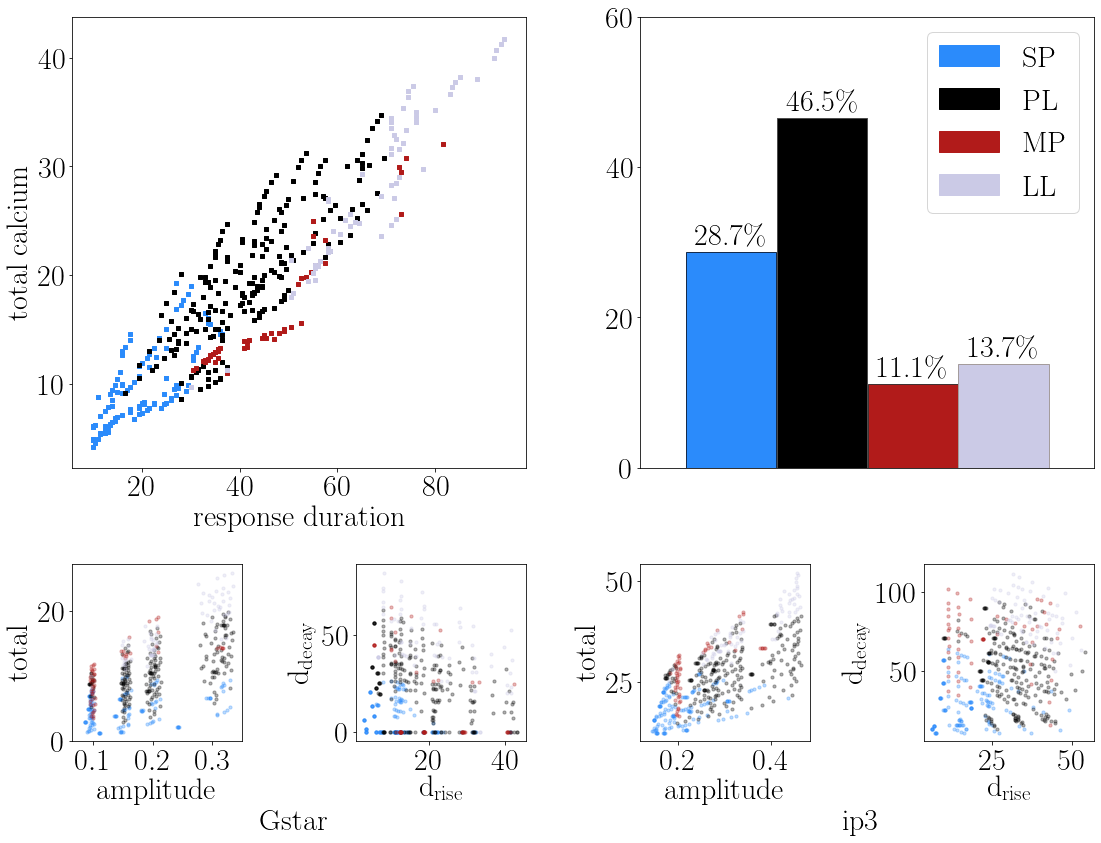

In [10]:
results = pd.read_pickle('data/ca_diversity/kp_1.5_kd2_1.2_vdelta_0.005')
fig = plt.figure(constrained_layout=False, figsize=(16, 12))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:2, :2])
diversity_dotplot(results, ax=ax, legend=False)
ax = fig.add_subplot(gs[:2, 2:])
diversity_barchart(results, ax=ax, legend=True)
subs = [('Gstar', 'size'), ('Gstar', 'shape'), ('ip3', 'size'), ('ip3', 'shape')]
xlabels = ['amplitude', 'd$_\mathrm{rise}$', 'amplitude', 'd$_\mathrm{rise}$']
ylabels = ['total', 'd$_\mathrm{decay}$', 'total', 'd$_\mathrm{decay}$']
axs = []
for i, plot in enumerate(subs):
#     if i < 2:
#         continue
    ax = fig.add_subplot(gs[2:, i])
    plot_intermediate_characteristics(results, plot[0], plot[1], ax, s=10, wiggle=True, alpha=0.3)
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])
    axs.append(ax)

plt.tight_layout()
axs[0].text(1.3, -0.5, 'Gstar', ha='center', transform=axs[0].transAxes)
axs[2].text(1.3, -0.5, 'ip3', ha='center', transform=axs[2].transAxes)



Text(1.3, -0.5, 'ip3')

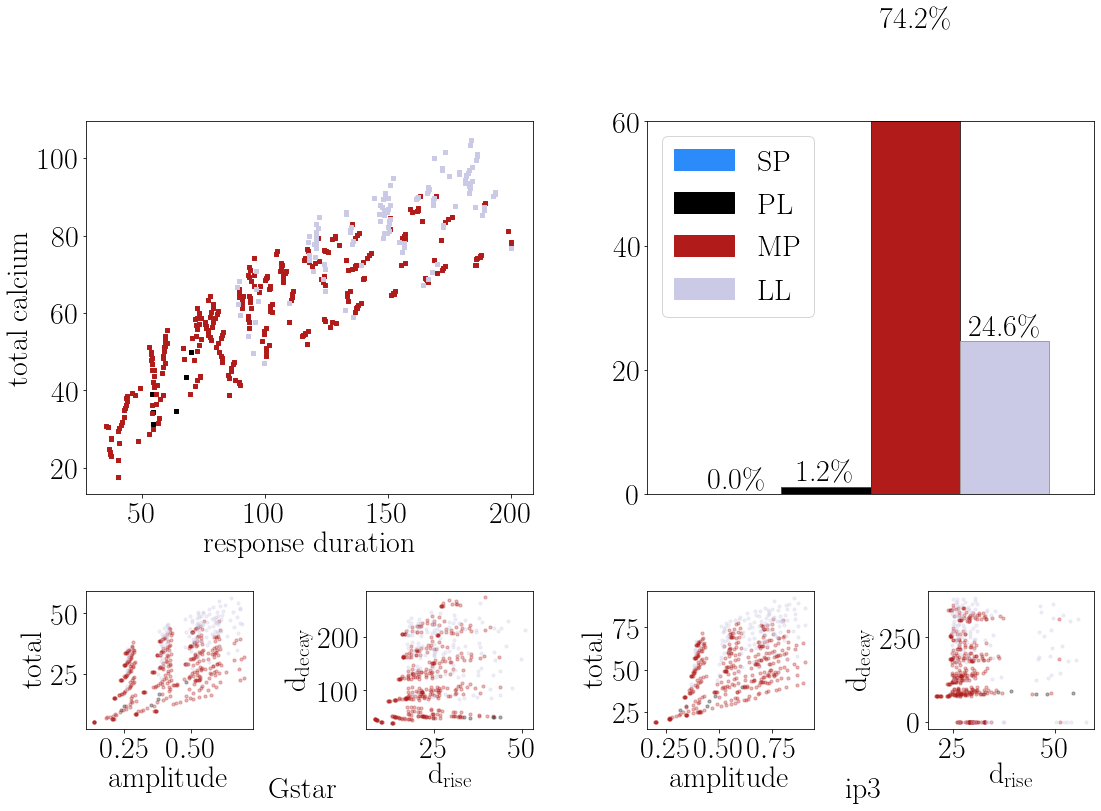

In [34]:
results = pd.read_pickle('data/ca_diversity/kp_1.5_kd2_1.2_vdelta_0.005_vpmca_0')
fig = plt.figure(constrained_layout=False, figsize=(16, 12))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:2, :2])
diversity_dotplot(results, ax=ax, legend=False)
ax = fig.add_subplot(gs[:2, 2:])
diversity_barchart(results, ax=ax, legend=True)
subs = [('Gstar', 'size'), ('Gstar', 'shape'), ('ip3', 'size'), ('ip3', 'shape')]
xlabels = ['amplitude', 'd$_\mathrm{rise}$', 'amplitude', 'd$_\mathrm{rise}$']
ylabels = ['total', 'd$_\mathrm{decay}$', 'total', 'd$_\mathrm{decay}$']
axs = []
for i, plot in enumerate(subs):
#     if i < 2:
#         continue
    ax = fig.add_subplot(gs[2:, i])
    plot_intermediate_characteristics(results, plot[0], plot[1], ax, s=10, wiggle=True, alpha=0.3)
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])
    axs.append(ax)

plt.tight_layout()
axs[0].text(1.3, -0.5, 'Gstar', ha='center', transform=axs[0].transAxes)
axs[2].text(1.3, -0.5, 'ip3', ha='center', transform=axs[2].transAxes)



In [35]:
counter = 0

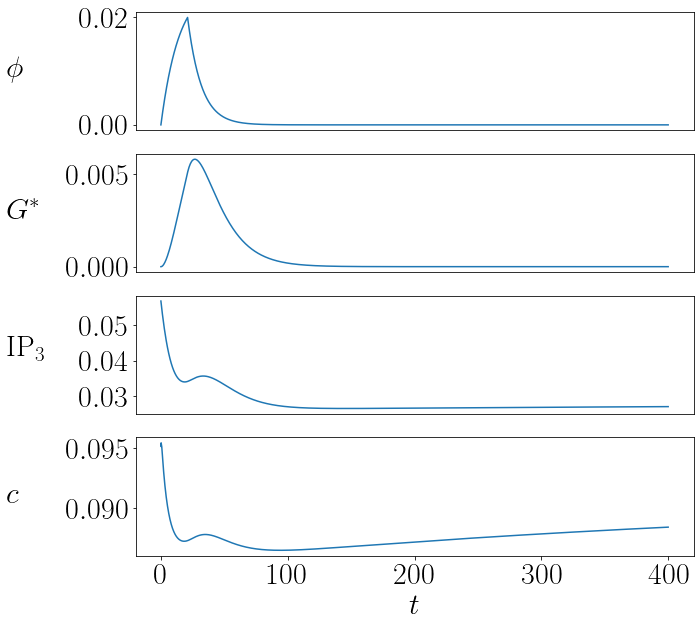

In [51]:
classification_simulation_with_row(row, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c'])

At least 2 valid peaks
MP


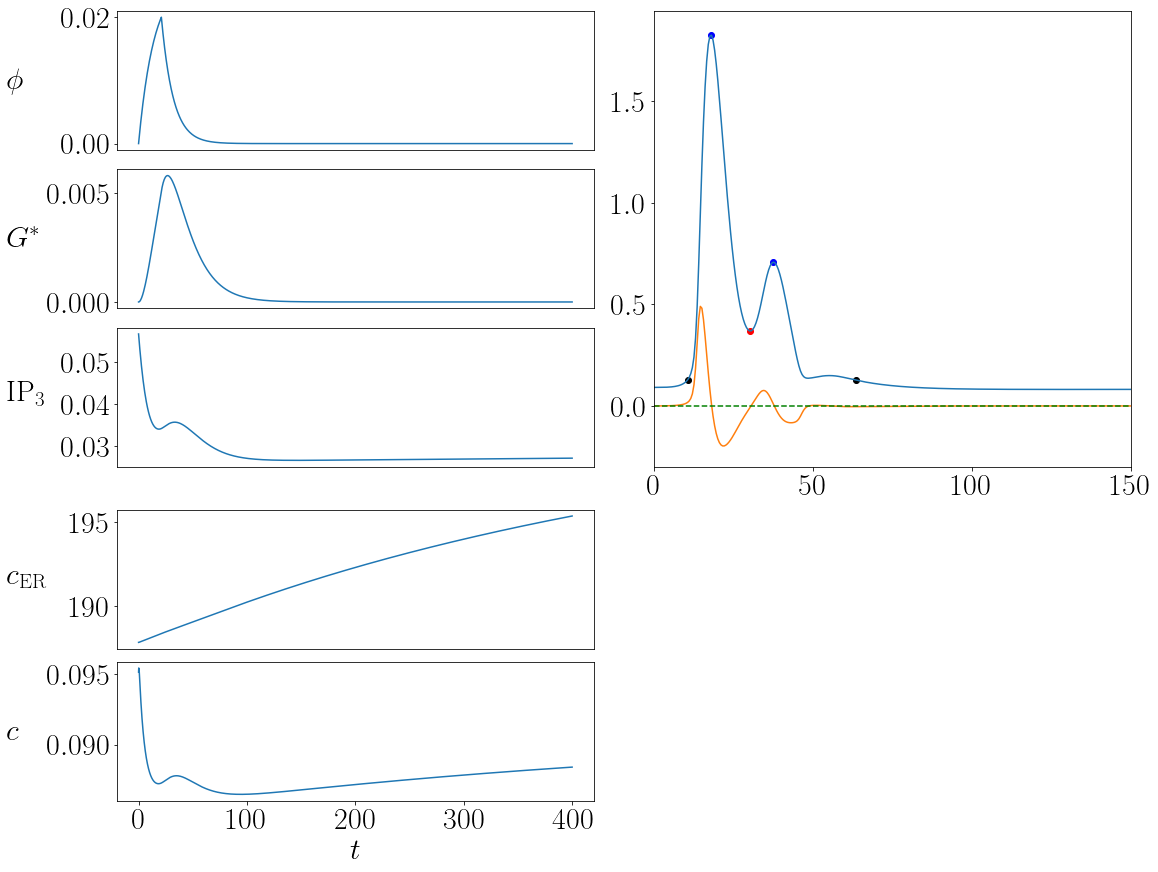

In [49]:
row = results[results['response_type']=='MP'].iloc[counter]

classification_simulation_with_row(row, max_step=0.5)
# fig, ax = plt.subplots(5, 2, figsize=)
fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = fig.add_gridspec(5, 2)
axs = [fig.add_subplot(gs[i, 0]) for i in range(5)]

plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], axs)

ax = fig.add_subplot(gs[:3, 1])
vis_dict = visualize_classification(row['t'], row['c'], ax=ax, ret=True, peak_priority=True)

cfg.all_init[1] = c_tot_default
counter += 1

Text(1.3, -0.5, 'ip3')

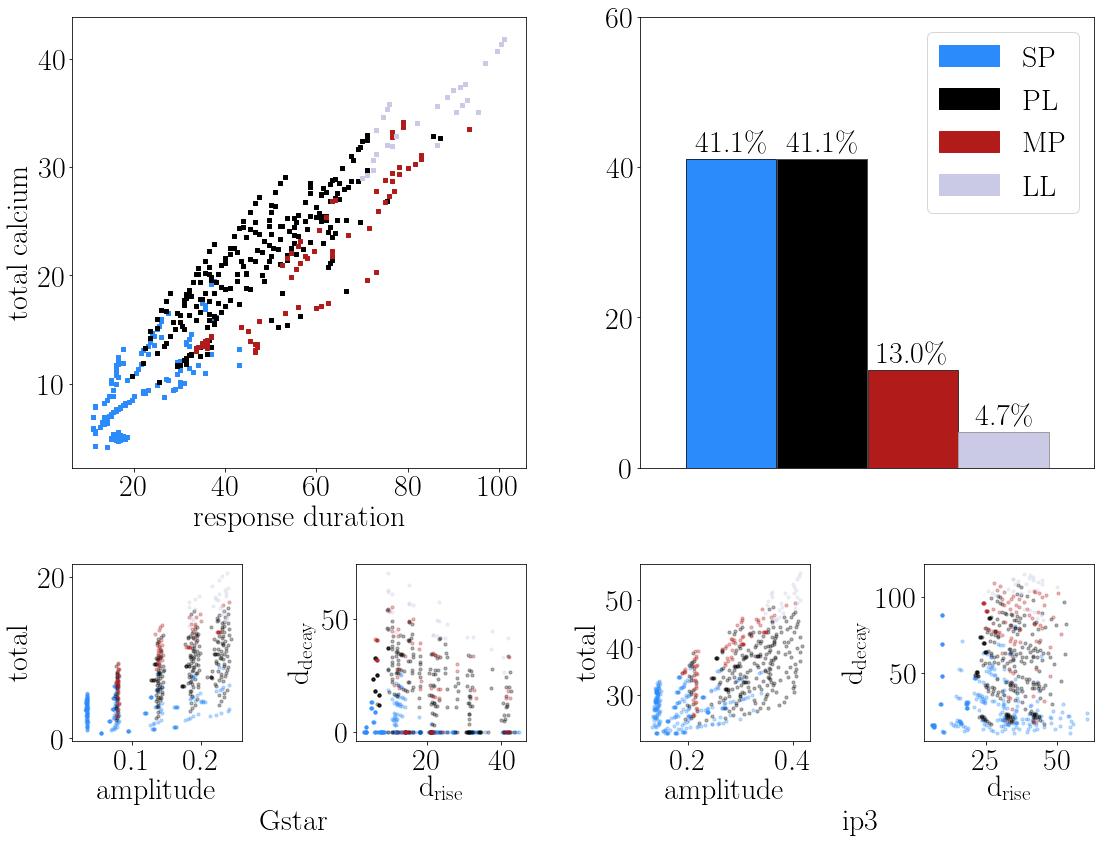

In [123]:
results = pd.read_pickle('data/ca_diversity/glut_kp30_km10_poisson_start')
fig = plt.figure(constrained_layout=False, figsize=(16, 12))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:2, :2])
diversity_dotplot(results, ax=ax, legend=False)
ax = fig.add_subplot(gs[:2, 2:])
diversity_barchart(results, ax=ax, legend=True)
subs = [('Gstar', 'size'), ('Gstar', 'shape'), ('ip3', 'size'), ('ip3', 'shape')]
xlabels = ['amplitude', 'd$_\mathrm{rise}$', 'amplitude', 'd$_\mathrm{rise}$']
ylabels = ['total', 'd$_\mathrm{decay}$', 'total', 'd$_\mathrm{decay}$']
axs = []
for i, plot in enumerate(subs):
#     if i < 2:
#         continue
    ax = fig.add_subplot(gs[2:, i])
    plot_intermediate_characteristics(results, plot[0], plot[1], ax, s=10, wiggle=True, alpha=0.3)
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])
    axs.append(ax)

plt.tight_layout()
axs[0].text(1.3, -0.5, 'Gstar', ha='center', transform=axs[0].transAxes)
axs[2].text(1.3, -0.5, 'ip3', ha='center', transform=axs[2].transAxes)



Text(1.3, -0.5, 'ip3')

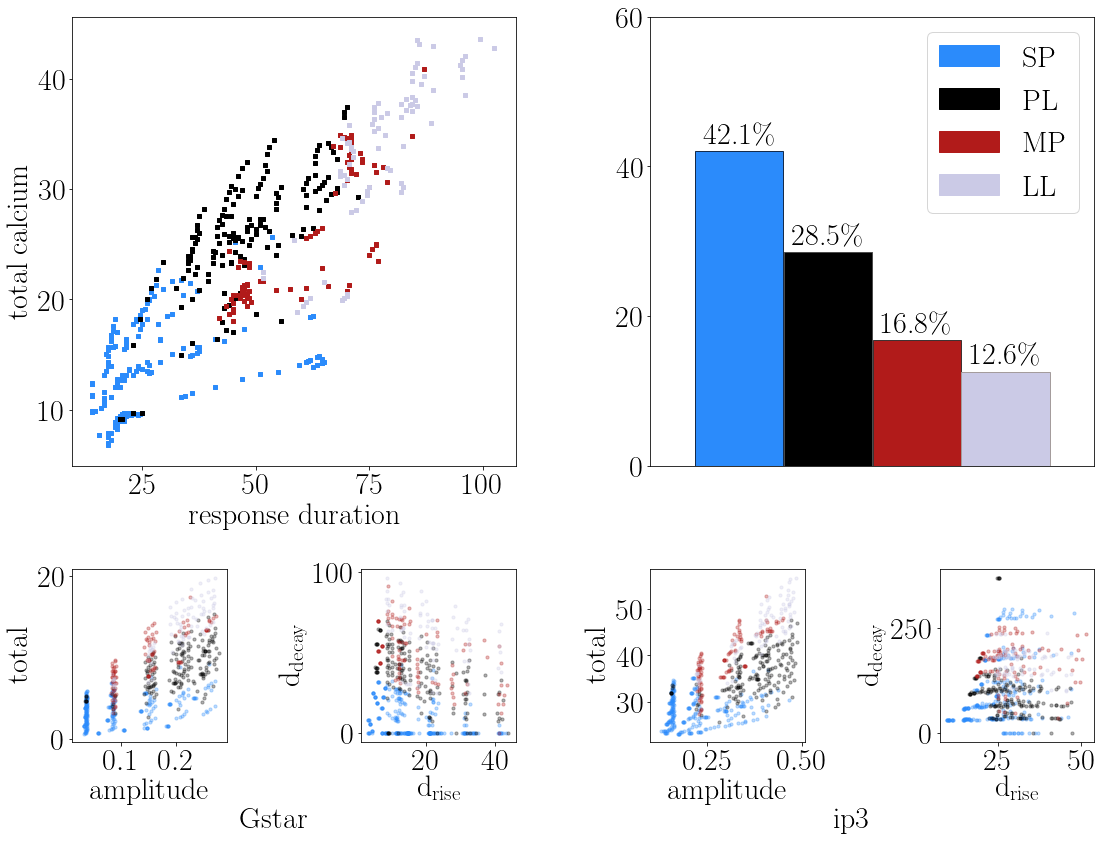

In [4]:
results = pd.read_pickle('data/ca_diversity/kd1_0.04')
fig = plt.figure(constrained_layout=False, figsize=(16, 12))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:2, :2])
diversity_dotplot(results, ax=ax, legend=False)
ax = fig.add_subplot(gs[:2, 2:])
diversity_barchart(results, ax=ax, legend=True)
subs = [('Gstar', 'size'), ('Gstar', 'shape'), ('ip3', 'size'), ('ip3', 'shape')]
xlabels = ['amplitude', 'd$_\mathrm{rise}$', 'amplitude', 'd$_\mathrm{rise}$']
ylabels = ['total', 'd$_\mathrm{decay}$', 'total', 'd$_\mathrm{decay}$']
axs = []
for i, plot in enumerate(subs):
#     if i < 2:
#         continue
    ax = fig.add_subplot(gs[2:, i])
    plot_intermediate_characteristics(results, plot[0], plot[1], ax, s=10, wiggle=True, alpha=0.3)
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])
    axs.append(ax)

plt.tight_layout()
axs[0].text(1.3, -0.5, 'Gstar', ha='center', transform=axs[0].transAxes)
axs[2].text(1.3, -0.5, 'ip3', ha='center', transform=axs[2].transAxes)



Text(1.3, -0.5, 'ip3')

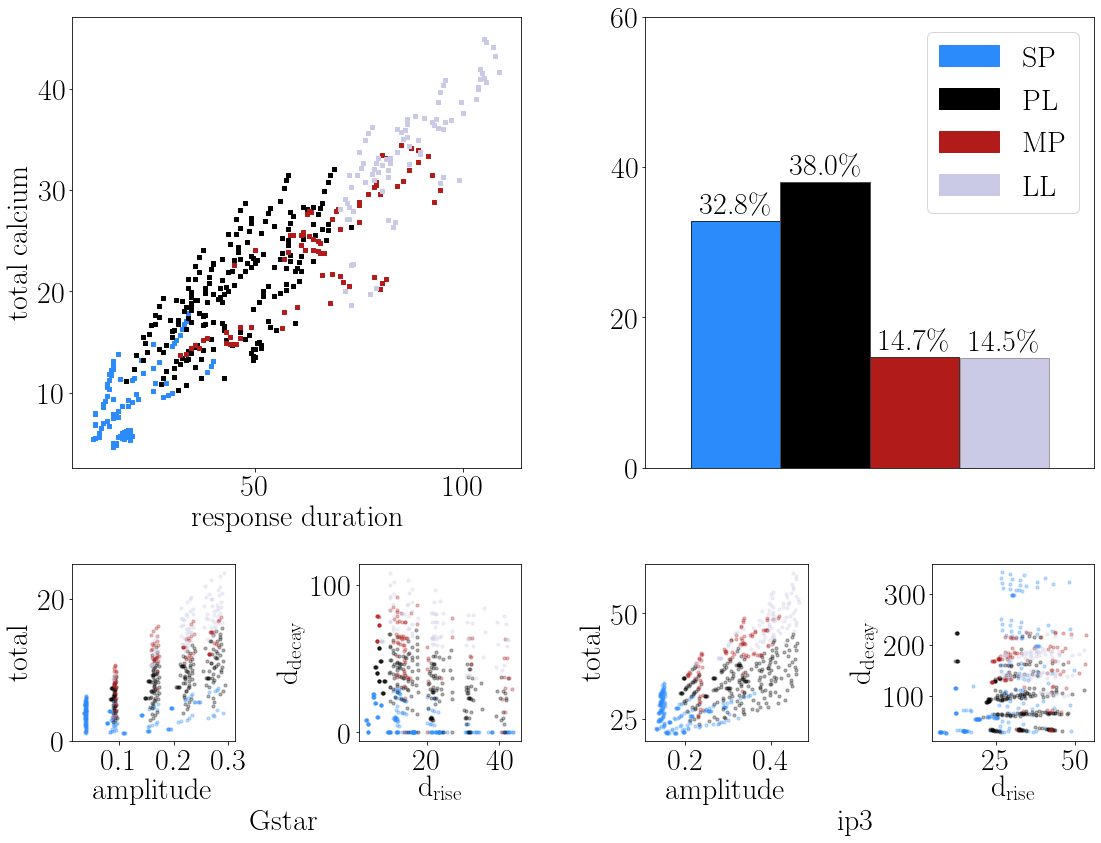

In [39]:
results = pd.read_pickle('data/ca_diversity/glut_kp30_km10_ct_0.8')
fig = plt.figure(constrained_layout=False, figsize=(16, 12))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:2, :2])
diversity_dotplot(results, ax=ax, legend=False)
ax = fig.add_subplot(gs[:2, 2:])
diversity_barchart(results, ax=ax, legend=True)
subs = [('Gstar', 'size'), ('Gstar', 'shape'), ('ip3', 'size'), ('ip3', 'shape')]
xlabels = ['amplitude', 'd$_\mathrm{rise}$', 'amplitude', 'd$_\mathrm{rise}$']
ylabels = ['total', 'd$_\mathrm{decay}$', 'total', 'd$_\mathrm{decay}$']
axs = []
for i, plot in enumerate(subs):
#     if i < 2:
#         continue
    ax = fig.add_subplot(gs[2:, i])
    plot_intermediate_characteristics(results, plot[0], plot[1], ax, s=10, wiggle=True, alpha=0.3)
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])
    axs.append(ax)

plt.tight_layout()
axs[0].text(1.3, -0.5, 'Gstar', ha='center', transform=axs[0].transAxes)
axs[2].text(1.3, -0.5, 'ip3', ha='center', transform=axs[2].transAxes)



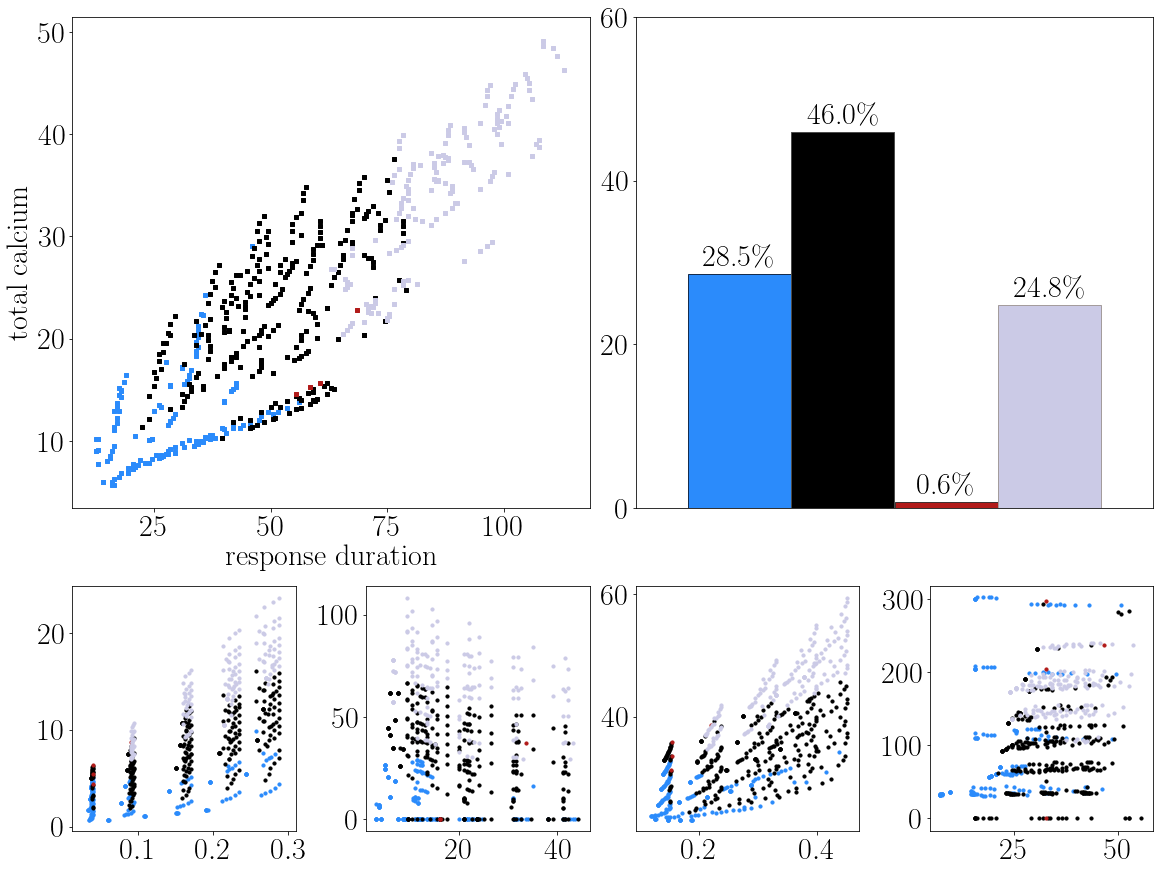

In [4]:
results = pd.read_pickle('data/ca_diversity/glut_kp30_km10')
fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:2, :2])
diversity_dotplot(results, ax=ax, legend=False)
ax = fig.add_subplot(gs[:2, 2:])
diversity_barchart(results, ax=ax, legend=False)
subs = [('Gstar', 'size'), ('Gstar', 'shape'), ('ip3', 'size'), ('ip3', 'shape')]
for i, plot in enumerate(subs):
    ax = fig.add_subplot(gs[2:, i])
    plot_intermediate_characteristics(results, plot[0], plot[1], ax, s=10)

In [41]:
r = results[results['ip3_ddecay'] > 300]
counter = 0

In [70]:
r = results[results['d_decay'] == 179]

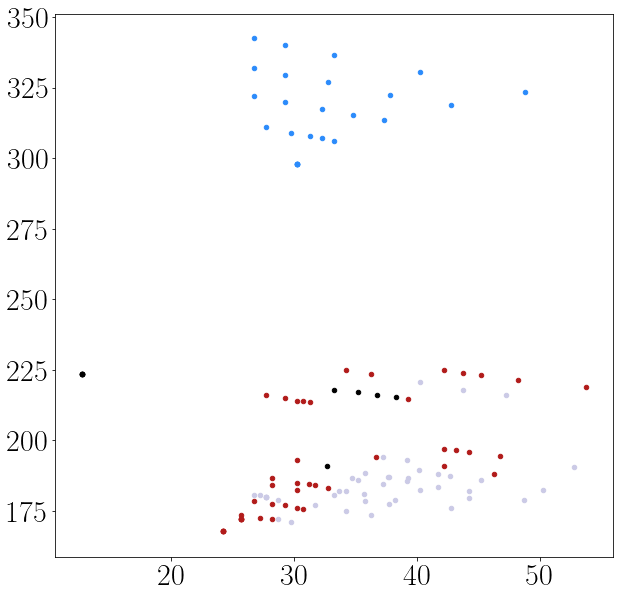

In [73]:
plot_intermediate_characteristics(r, typ='shape')

In [3]:
results = pd.read_pickle('data/ca_diversity/glut_kp30_km10_ct_0.8')

Text(0, 0.5, 'response duration')

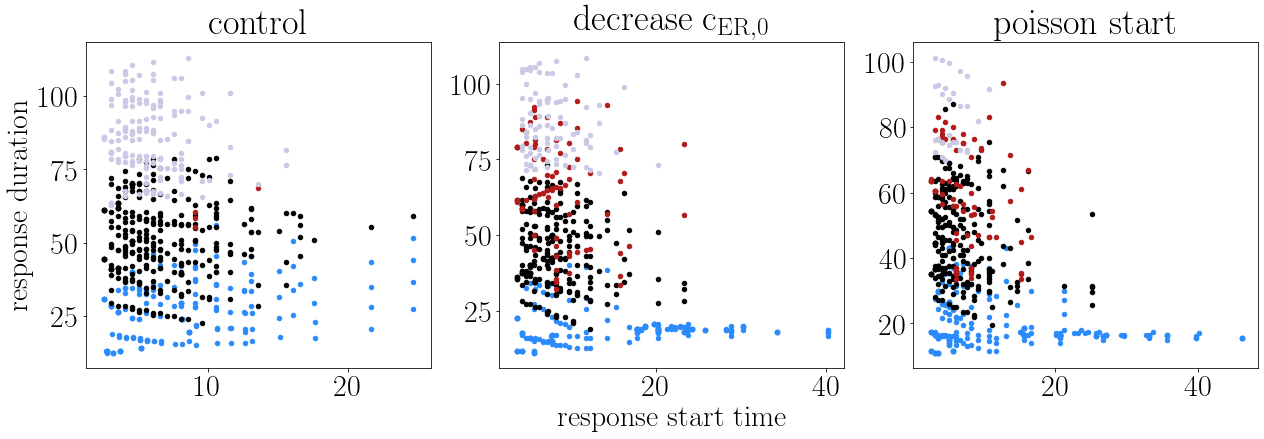

In [14]:
files = ['glut_kp30_km10', 'glut_kp30_km10_ct_0.8', 'glut_kp30_km10_poisson_start']
titles = ['control', 'decreased c$_\mathrm{ER,0}$', 'poisson start']
fig, ax = plt.subplots(1, 3, figsize=(21, 6))

for i, file in enumerate(files):
    results = pd.read_pickle('data/ca_diversity/' + file)
    for idx in results.index:
        row = results.loc[idx]
        peaks, troughs = calcium_peaks_and_troughs(row['t'], row['c'])
        response_start_index, _, duration,_,_,_ = calcium_response_characteristics(row['t'], row['c'], peaks)
        start = row['t'][response_start_index]
        results.loc[idx, 'start'] = start
        results.loc[idx, 'duration'] = duration
    plot_intermediate_characteristics(results, typ='time', ax=ax[i])
    ax[i].set_title(titles[i])

ax[1].set_xlabel('response start time')
ax[0].set_ylabel('response duration')
    

Text(0, 0.5, 'response duration')

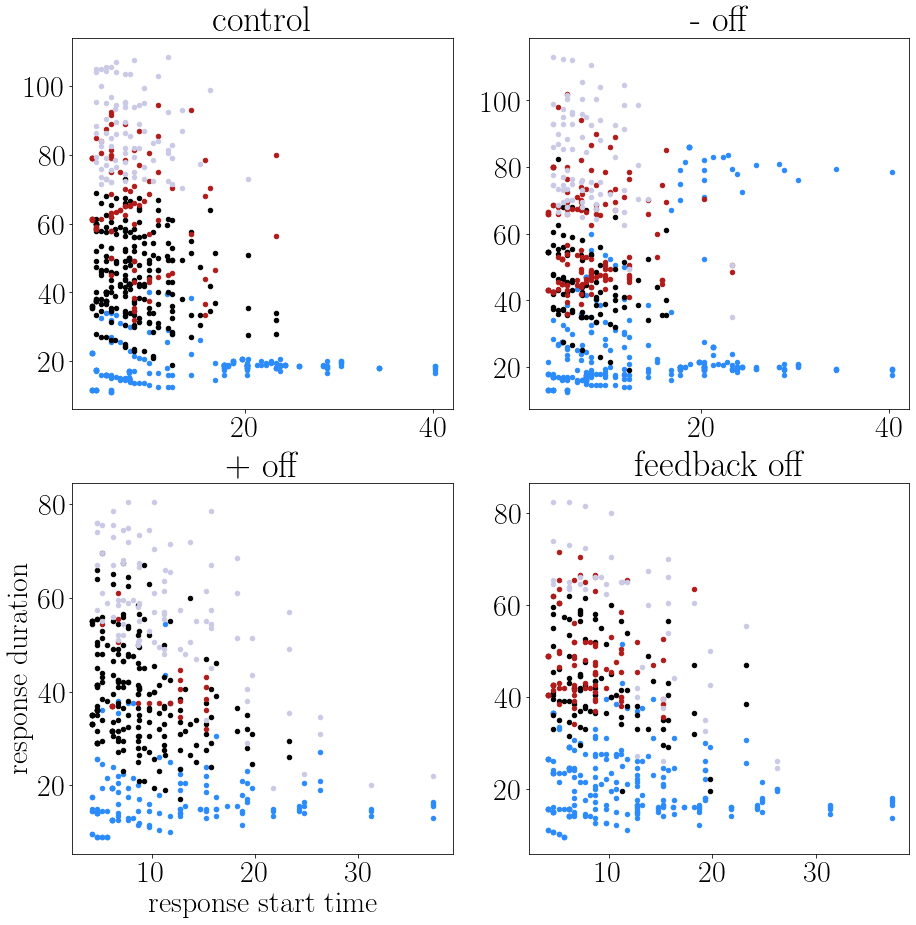

In [16]:
files = ['glut_kp30_km10_ct_0.8', 'glut_kp30_km10_ct_0.8_posoff', 'glut_kp30_km10_ct_0.8_negoff', 'glut_kp30_km10_ct_0.8_feedback_off']
titles = ['control', '+ off', '- off', 'feedback off']
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

for i, file in enumerate(files):
    x = i % 2
    y = int(np.floor(i / 2))
    results = pd.read_pickle('data/ca_diversity/' + file)
    for idx in results.index:
        row = results.loc[idx]
        peaks, troughs = calcium_peaks_and_troughs(row['t'], row['c'])
        response_start_index, _, duration,_,_,_ = calcium_response_characteristics(row['t'], row['c'], peaks)
        start = row['t'][response_start_index]
        results.loc[idx, 'start'] = start
        results.loc[idx, 'duration'] = duration
    plot_intermediate_characteristics(results, typ='time', ax=ax[x,y])
    ax[x,y].set_title(titles[i])

ax[1,0].set_xlabel('response start time')
ax[1,0].set_ylabel('response duration')
    

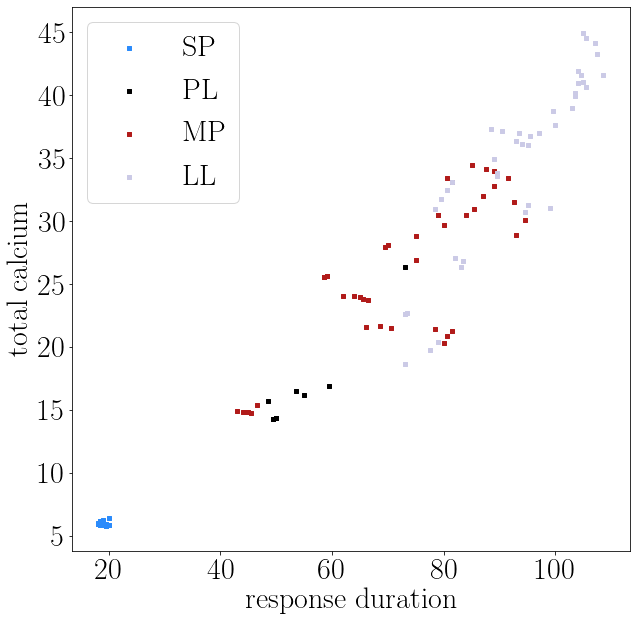

In [71]:
diversity_dotplot(r)

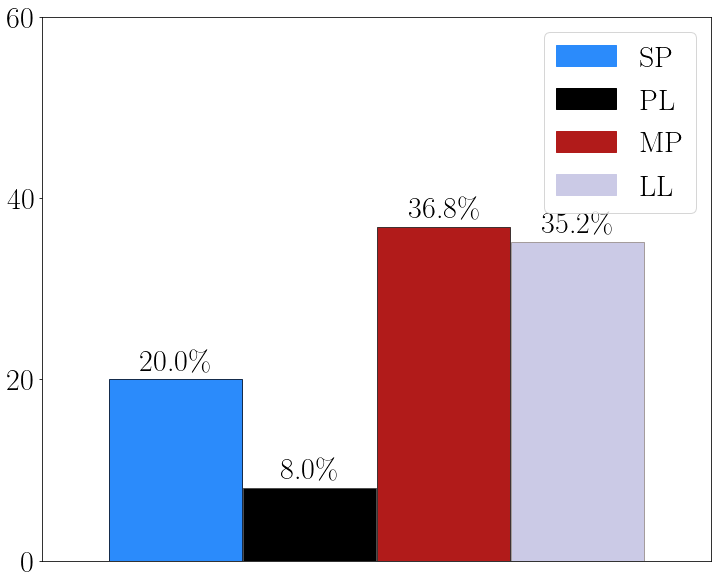

In [72]:
diversity_barchart(r)

In [75]:
np.random.choice(r[r['response_type'] == 'SP'].index)

110

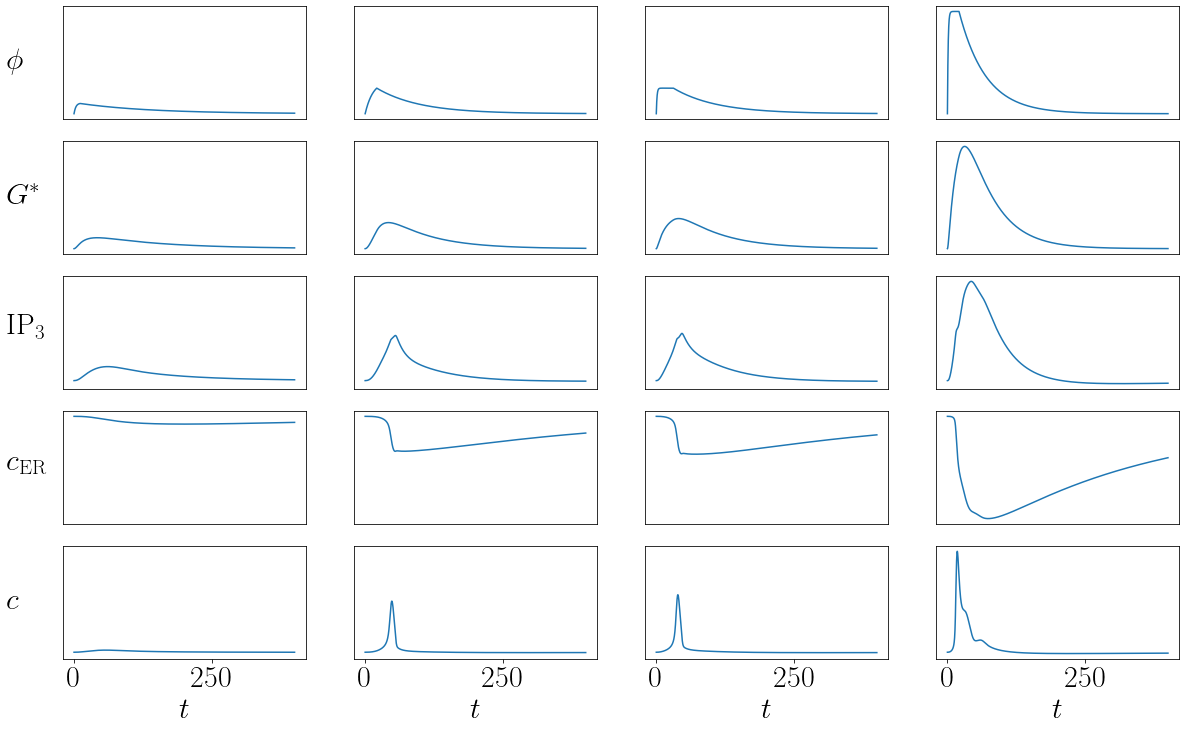

In [79]:
fig, ax = plt.subplots(5, 4, figsize=(20, 12), sharey='row')
for i, typ in enumerate(['SP', 'PL', 'MP', 'LL']):
    #get a random row from the results in each of the categories
    d = r[r['response_type'] == typ]
    idx = np.random.choice(d.index)
    row = d.loc[idx]
    
    remove_yticks = bool(i != 0)
    
    classification_simulation_with_row(row)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax[:,i], remove_yticks=remove_yticks, add_ylabels=(not remove_yticks))
    

In [17]:
results = pd.read_pickle('data/ca_diversity/glut_kp30_km10_ct_0.8_negoff')
for idx in results.index:
    row = results.loc[idx]
    peaks, troughs = calcium_peaks_and_troughs(row['t'], row['c'])
    response_start_index, _, duration,_,_,_ = calcium_response_characteristics(row['t'], row['c'], peaks)
    start = row['t'][response_start_index]
    results.loc[idx, 'start'] = start
    results.loc[idx, 'duration'] = duration
r = results[(results['response_type'] == 'SP') & (results['duration'] > 60)]

In [18]:
counter = 0

In [34]:
r

A  d_decay  d_rise   r_decay  r_rise response_type  response_duration  \
100  0.02      179       1  0.007745   0.003            SP               86.0   
101  0.02      179       1  0.007745   0.070            SP               86.0   
102  0.02      179       1  0.007745   0.150            SP               86.0   
103  0.02      179       1  0.007745   0.300            SP               86.0   
104  0.02      179       1  0.007745   0.800            SP               86.0   
105  0.02      179      11  0.007745   0.003            SP               83.5   
106  0.02      179      11  0.007745   0.070            SP               83.0   
107  0.02      179      11  0.007745   0.150            SP               83.0   
108  0.02      179      11  0.007745   0.300            SP               82.0   
109  0.02      179      11  0.007745   0.800            SP               81.5   
110  0.02      179      21  0.007745   0.003            SP               81.0   
111  0.02      179      21  0.007745   0.070            SP               80.5   
112  0.02      179      21  0.007745   0.150            SP               79.5   
113  0.02      179      21  0.007745   0.300            SP               79.0   
114  0.02      179      21  0.007745   0.800            SP               79.0   
115  0.02      179      31  0.007745   0.003            SP               79.5   
116  0.02      179      31  0.007745   0.070            SP               79.0   
117  0.02      179      31  0.007745   0.150            SP               78.0   
118  0.02      179      31  0.007745   0.300            SP               76.0   
119  0.02      179      31  0.007745   0.800            SP               75.0   
120  0.02      179      41  0.007745   0.003            SP               78.5   
121  0.02      179      41  0.007745   0.070            SP               76.0   
122  0.02      179      41  0.007745   0.150            SP               72.5   
123  0.02      179      41  0.007745   0.300            SP               71.0   
124  0.02      179      41  0.007745   0.800            SP               70.0   
235  0.05      179      21  0.012864   0.003            SP               67.0   

       c_total                                                  t  \
100  13.023481  [0.0, 0.06889748358845363, 0.4172828741755087,...   
101  13.023366  [0.0, 0.06846246136465295, 0.41674081534797996...   
102  13.023227  [0.0, 0.06795243902950714, 0.41610555174083114...   
103  13.022965  [0.0, 0.0670234265089876, 0.4149491339647149, ...   
104  13.022077  [0.0, 0.06417456156274812, 0.41140963130786057...   
105  13.083696  [0.0, 0.09803165053726294, 0.4539104311776918,...   
106  13.043155  [0.0, 0.09564515342419423, 0.45088957434666654...   
107  13.064385  [0.0, 0.0921536989143887, 0.44647553281068547,...   
108  12.985794  [0.0, 0.08553629371402059, 0.43812951087023544...   
109  12.978478  [0.0, 0.07213574925750178, 0.42132061951889, 0...   
110  13.093546  [0.0, 0.10028621356377586, 0.456766325795633, ...   
111  13.094098  [0.0, 0.09812785771749014, 0.45403224107938733...   
112  13.048394  [0.0, 0.09396048862088806, 0.44875886919191954...   
113  13.064197  [0.0, 0.08603382230931855, 0.4387560319581223,...   
114  13.114387  [0.0, 0.07213785086345194, 0.42132324432277823...   
115  13.169562  [0.0, 0.10083434349035318, 0.4574605957434625,...   
116  13.226680  [0.0, 0.09881633610435595, 0.45490422957662446...   
117  13.232095  [0.0, 0.09429690399606643, 0.4491842216299353,...   
118  13.089719  [0.0, 0.08605803421732594, 0.4387865253412249,...   
119  13.011437  [0.0, 0.07213785156841579, 0.42132324520284775...   
120  13.274792  [0.0, 0.10104497275919562, 0.45772723605500515...   
121  13.196828  [0.0, 0.09908182270083453, 0.4552405253474582,...   
122  12.902762  [0.0, 0.09436911790659717, 0.44927553478949545...   
123  12.779358  [0.0, 0.08605923830110056, 0.43878804181941566...   
124  12.681445  [0.0, 0.07213785156865227, 0.42132324520372577...   
235  17.166955  [0.0, 0.09

No valid troughs that were <50% height of neighboring peaks
First response lasted for 53.00000000000001
Remaining durations is -33.50000000000001
SP


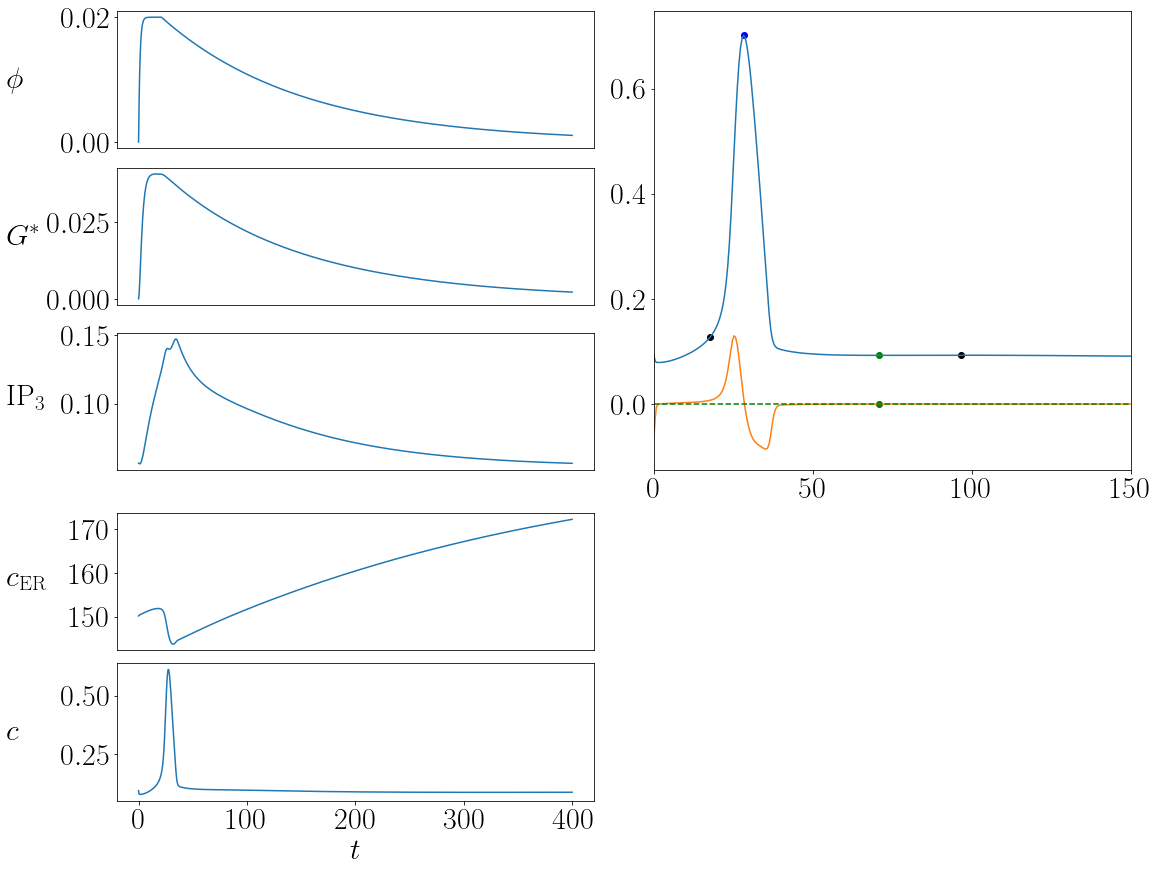

In [33]:
# row = r[r['response_type']=='MP'].iloc[counter]
row = r.iloc[counter]
c_tot_default = cfg.all_init[1]
cfg.all_init[1] = c_tot_default * 0.8
classification_simulation_with_row(row, kpkm=[30,10], max_step=0.5)
# fig, ax = plt.subplots(5, 2, figsize=)
fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = fig.add_gridspec(5, 2)
axs = [fig.add_subplot(gs[i, 0]) for i in range(5)]

plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], axs)

ax = fig.add_subplot(gs[:3, 1])
vis_dict = visualize_classification(row['t'], row['c'], ax=ax, ret=True, peak_priority=True)

cfg.all_init[1] = c_tot_default
counter += 1

# Without feedbacks

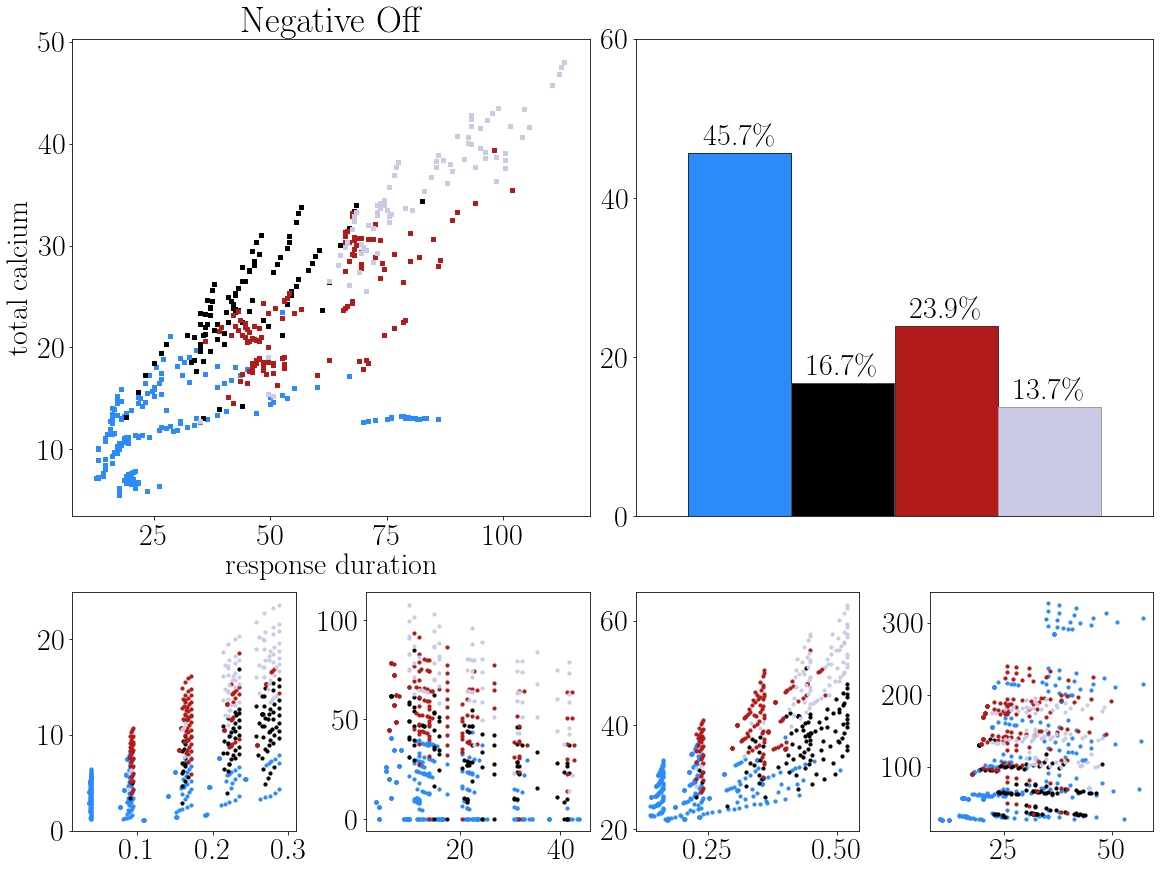

In [29]:
results = pd.read_pickle('data/ca_diversity/glut_kp30_km10_ct_0.8_negoff')
fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:2, :2])
ax.set_title('Negative Off')
diversity_dotplot(results, ax=ax, legend=False)
ax = fig.add_subplot(gs[:2, 2:])
diversity_barchart(results, ax=ax, legend=False)
subs = [('Gstar', 'size'), ('Gstar', 'shape'), ('ip3', 'size'), ('ip3', 'shape')]
for i, plot in enumerate(subs):
    ax = fig.add_subplot(gs[2:, i])
    plot_intermediate_characteristics(results, plot[0], plot[1], ax, s=10)

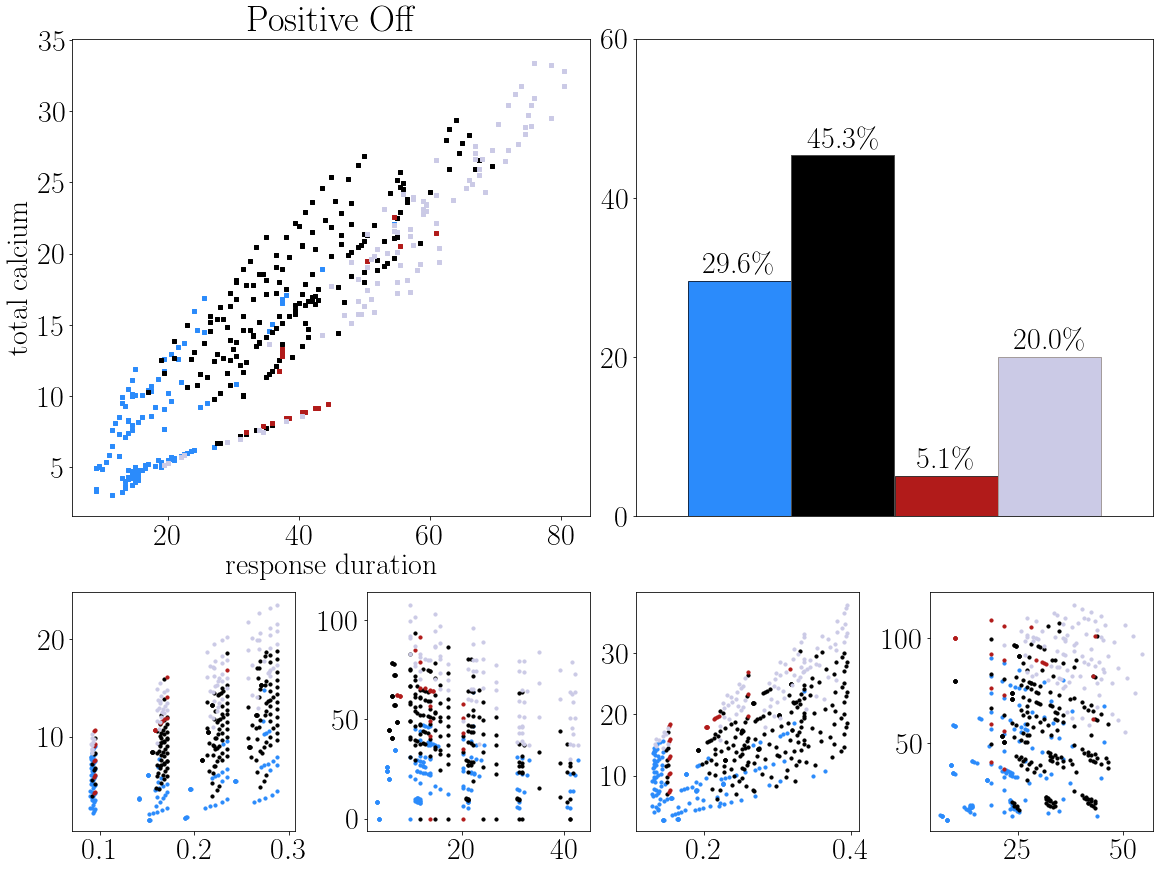

In [30]:
results = pd.read_pickle('data/ca_diversity/glut_kp30_km10_ct_0.8_posoff')
fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:2, :2])
ax.set_title('Positive Off')
diversity_dotplot(results, ax=ax, legend=False)
ax = fig.add_subplot(gs[:2, 2:])
diversity_barchart(results, ax=ax, legend=False)
subs = [('Gstar', 'size'), ('Gstar', 'shape'), ('ip3', 'size'), ('ip3', 'shape')]
for i, plot in enumerate(subs):
    ax = fig.add_subplot(gs[2:, i])
    plot_intermediate_characteristics(results, plot[0], plot[1], ax, s=10)

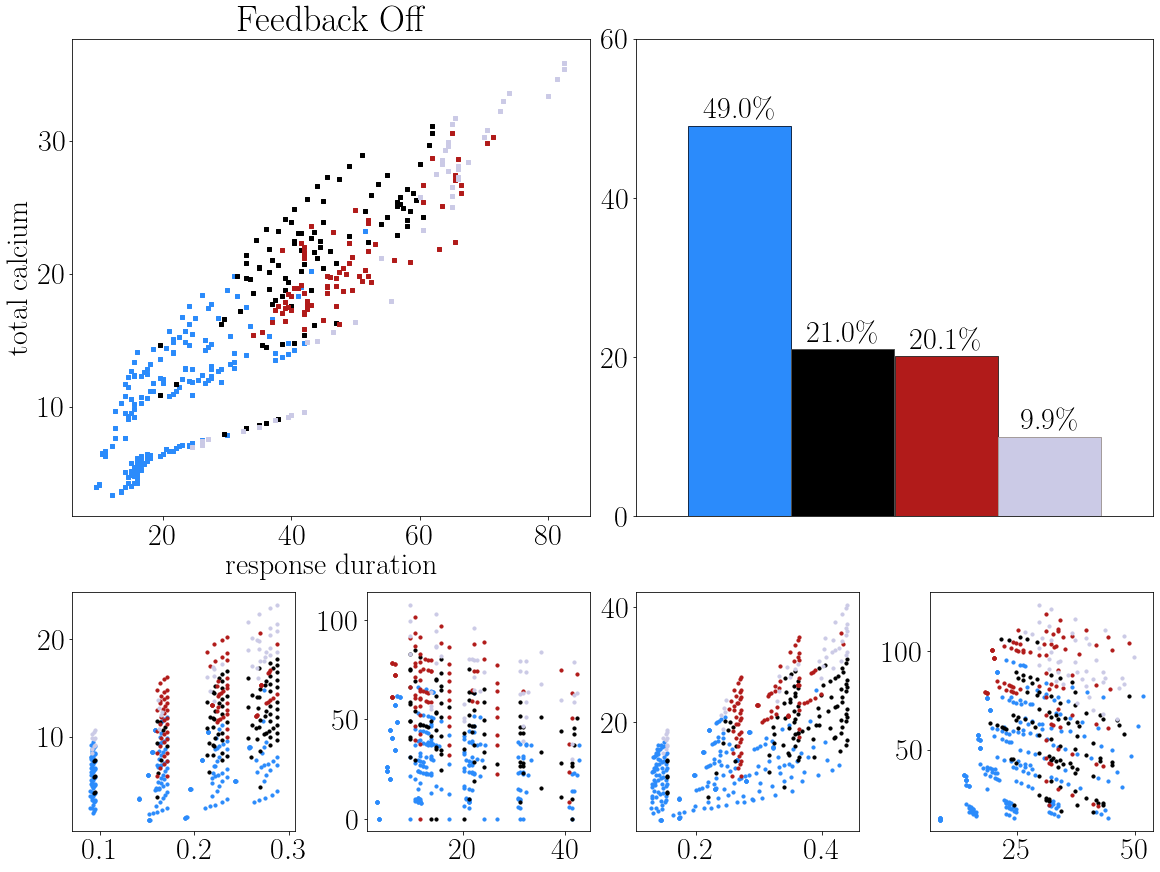

In [31]:
results = pd.read_pickle('data/ca_diversity/glut_kp30_km10_ct_0.8_feedback_off')
fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:2, :2])
ax.set_title('Feedback Off')
diversity_dotplot(results, ax=ax, legend=False)
ax = fig.add_subplot(gs[:2, 2:])
diversity_barchart(results, ax=ax, legend=False)
subs = [('Gstar', 'size'), ('Gstar', 'shape'), ('ip3', 'size'), ('ip3', 'shape')]
for i, plot in enumerate(subs):
    ax = fig.add_subplot(gs[2:, i])
    plot_intermediate_characteristics(results, plot[0], plot[1], ax, s=10)

# Explorations of calcium signal falloff

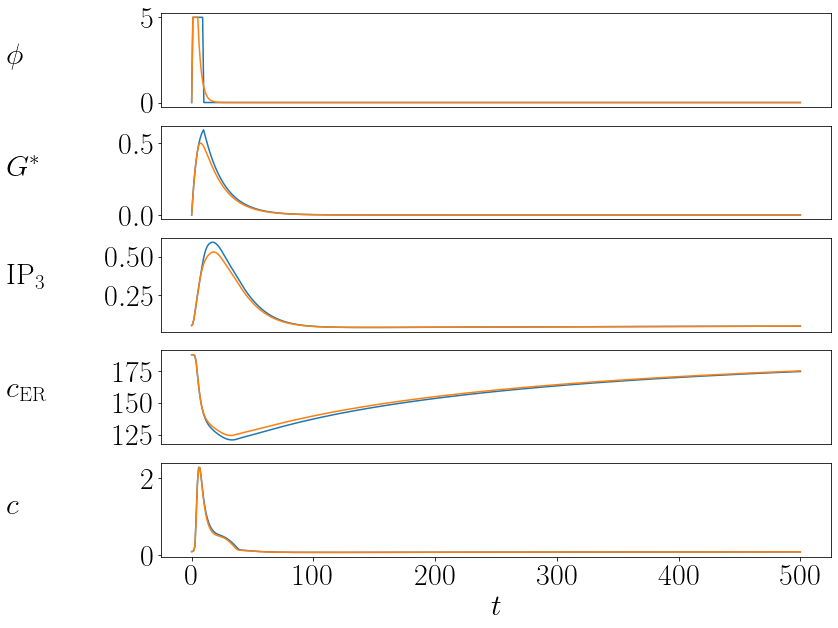

In [48]:
# cfg.v_delta = 0.00
cfg.input_start = 0
cfg.input_max = 5
cfg.input_duration = 10
cfg.A = 5
cfg.d_rise = 5
cfg.r_rise = 20
cfg.d_decay = 20
cfg.r_decay = compute_r_decay(5, cfg.d_decay)

fig, ax = plt.subplots(5, 1, figsize=(12, 10))
sol = run_experiment('pulse', t_f=500, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
# cfg.v_delta = 0.01
sol = run_experiment('curve', t_f=500, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

cfg.v_delta = 0.01

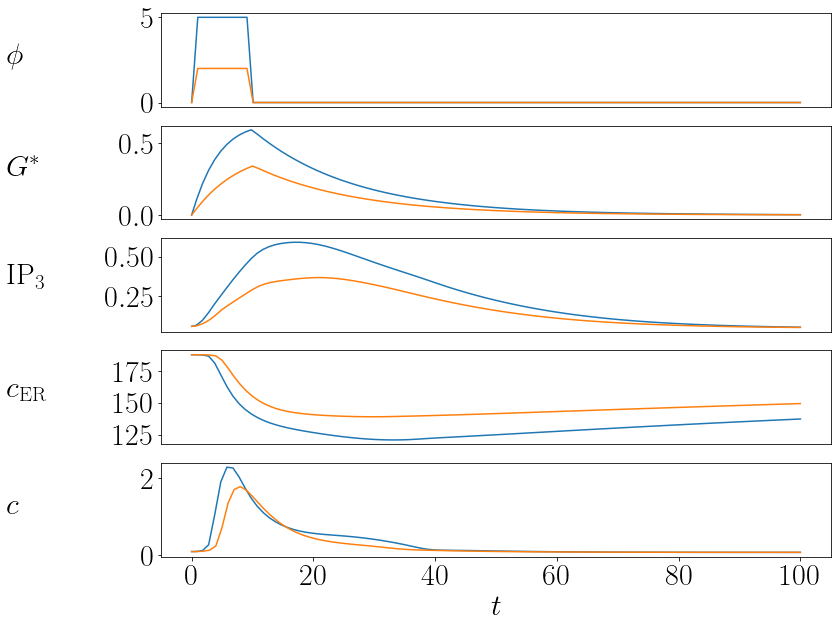

In [54]:
# cfg.v_3k = 0.00
cfg.input_start = 0
cfg.input_max = 5
cfg.input_duration = 10
cfg.A = 5
cfg.d_rise = 5
cfg.r_rise = 20
cfg.d_decay = 20
cfg.r_decay = compute_r_decay(5, cfg.d_decay)

fig, ax = plt.subplots(5, 1, figsize=(12, 10))
sol = run_experiment('pulse', t_f=100, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
# cfg.v_3k = 0.1
cfg.input_max = 2
sol = run_experiment('pulse', t_f=100, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

# cfg.v_delta = 0.01

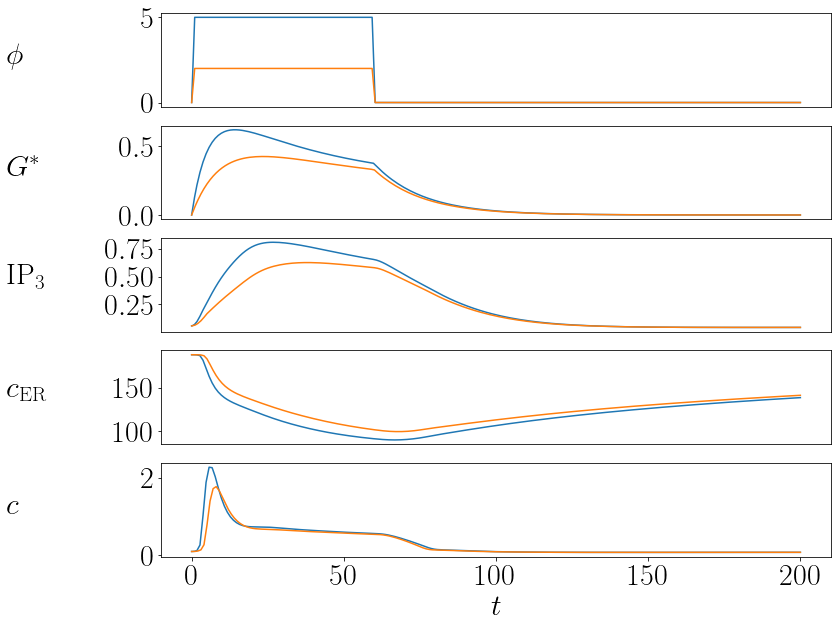

In [55]:
# cfg.v_3k = 0.00
cfg.input_start = 0
cfg.input_max = 5
cfg.input_duration = 60
cfg.A = 5
cfg.d_rise = 5
cfg.r_rise = 20
cfg.d_decay = 20
cfg.r_decay = compute_r_decay(5, cfg.d_decay)

fig, ax = plt.subplots(5, 1, figsize=(12, 10))
sol = run_experiment('pulse', t_f=200, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
# cfg.v_3k = 0.1
cfg.input_max = 2
sol = run_experiment('pulse', t_f=200, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

# cfg.v_delta = 0.01

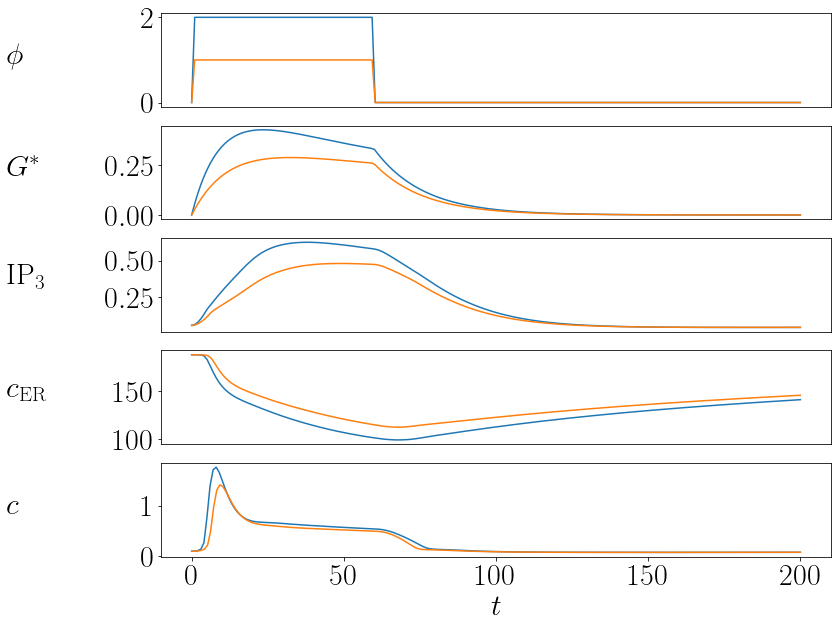

In [56]:
# cfg.v_3k = 0.00
cfg.input_start = 0
cfg.input_max = 2
cfg.input_duration = 60
cfg.A = 5
cfg.d_rise = 5
cfg.r_rise = 20
cfg.d_decay = 20
cfg.r_decay = compute_r_decay(5, cfg.d_decay)

fig, ax = plt.subplots(5, 1, figsize=(12, 10))
sol = run_experiment('pulse', t_f=200, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
# cfg.v_3k = 0.1
cfg.input_max = 1
sol = run_experiment('pulse', t_f=200, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

# cfg.v_delta = 0.01

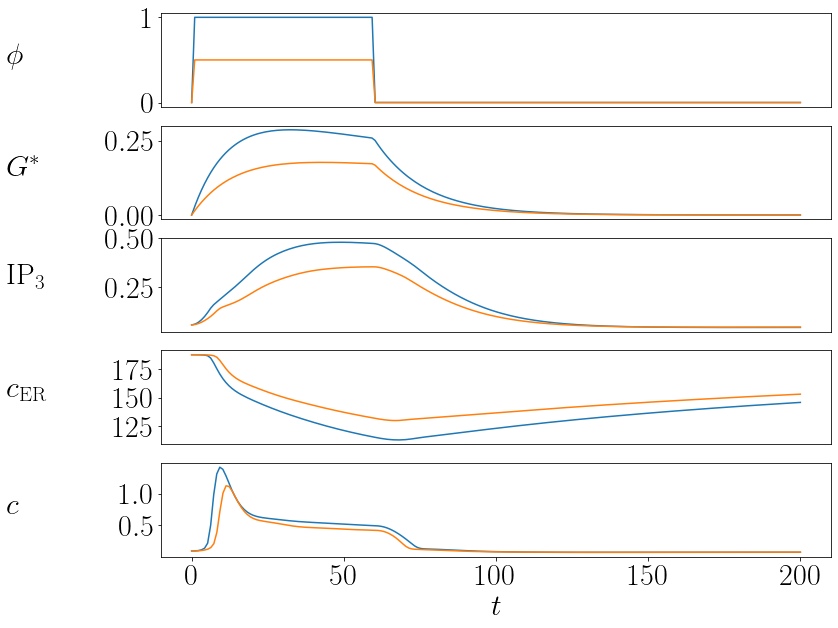

In [57]:
# cfg.v_3k = 0.00
cfg.input_start = 0
cfg.input_max = 1
cfg.input_duration = 60
cfg.A = 5
cfg.d_rise = 5
cfg.r_rise = 20
cfg.d_decay = 20
cfg.r_decay = compute_r_decay(5, cfg.d_decay)

fig, ax = plt.subplots(5, 1, figsize=(12, 10))
sol = run_experiment('pulse', t_f=200, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
# cfg.v_3k = 0.1
cfg.input_max = 0.5
sol = run_experiment('pulse', t_f=200, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

# cfg.v_delta = 0.01

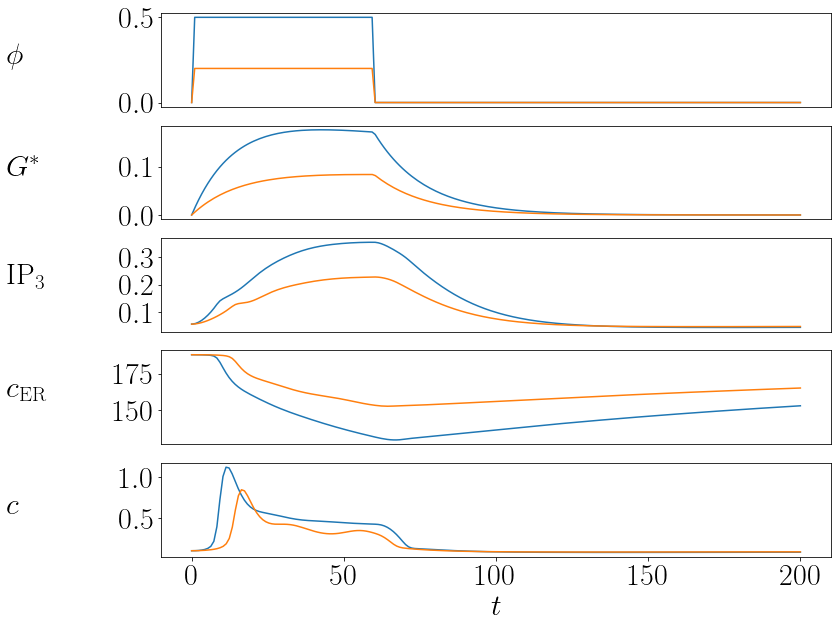

In [58]:
# cfg.v_3k = 0.00
cfg.input_start = 0
cfg.input_max = 0.5
cfg.input_duration = 60
cfg.A = 5
cfg.d_rise = 5
cfg.r_rise = 20
cfg.d_decay = 20
cfg.r_decay = compute_r_decay(5, cfg.d_decay)

fig, ax = plt.subplots(5, 1, figsize=(12, 10))
sol = run_experiment('pulse', t_f=200, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
# cfg.v_3k = 0.1
cfg.input_max = 0.2
sol = run_experiment('pulse', t_f=200, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

# cfg.v_delta = 0.01

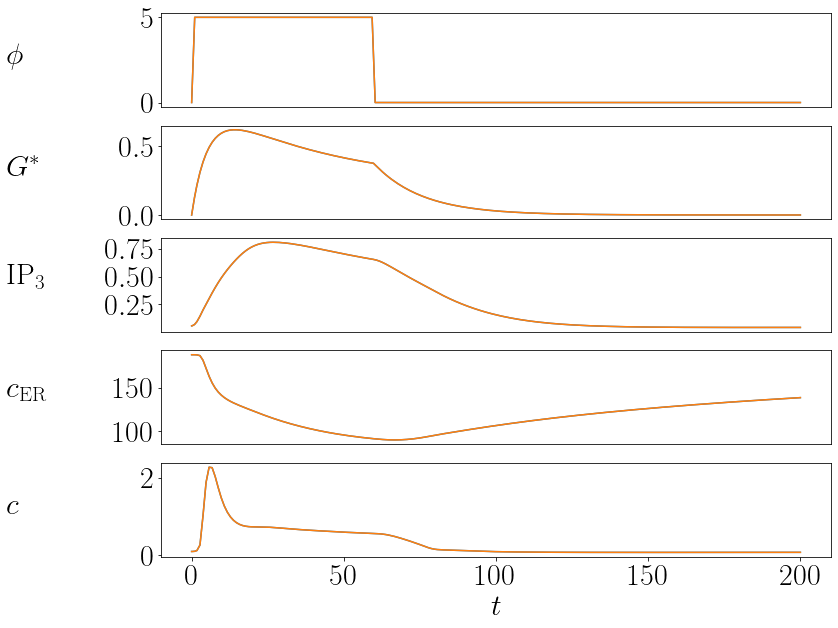

In [76]:
# cfg.v_3k = 0.00
cfg.input_start = 0
cfg.input_max = 5
cfg.input_duration = 60
cfg.A = 5
cfg.d_rise = 5
cfg.r_rise = 20
cfg.d_decay = 20
cfg.r_decay = compute_r_decay(5, cfg.d_decay)

fig, ax = plt.subplots(5, 1, figsize=(12, 10))
sol = run_experiment('pulse', t_f=200, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
# cfg.v_3k = 0.1
# cfg.input_max = 0.3
sol = run_experiment('pulse', t_f=200, max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

# cfg.v_delta = 0.01

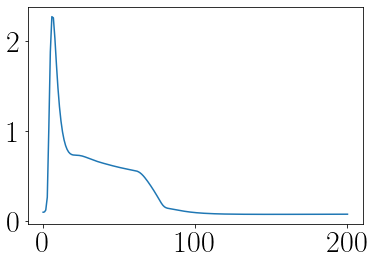

In [77]:
plt.plot(cfg.t, cfg.c)

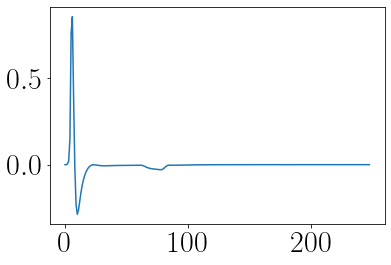

In [78]:
deriv = plt.plot(np.diff(cfg.c))

NameError: name 'deriv' is not defined

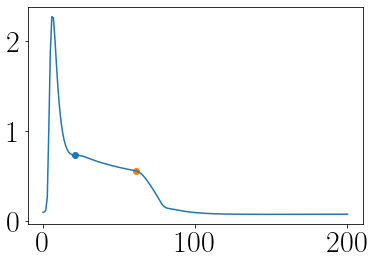

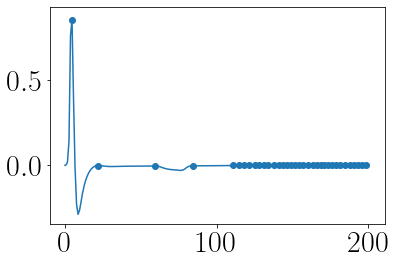

In [81]:
plt.plot(cfg.t[1:], deriv)
plt.scatter(cfg.t[1:][deriv_peaks], deriv[deriv_peaks])

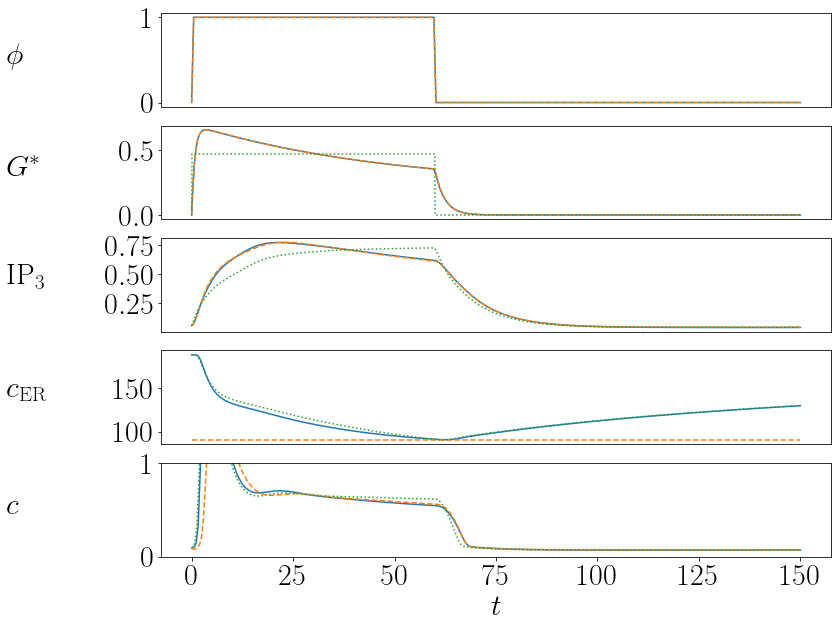

In [76]:
cfg.input_start = 0
cfg.input_duration = 60
cfg.input_max = 1
fig, ax = plt.subplots(5, 1, figsize=(12, 10))
sol = run_experiment('pulse', t_f=150, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
c_decay, c_decay_perc, c_er_avg = get_decays()
c_er_min = np.min(cfg.c_er)
sol = run_experiment('pulse', t_f=150, fix_c_er=c_er_min, max_step=0.5)
cfg.c_er[0] = c_er_min
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax, linestyle='--')
ax[4].set_ylim([0,1])

end_stimulus = np.argmax(cfg.t > cfg.input_duration)
cfg.input_max = np.mean(cfg.Gstar[:end_stimulus])
sol = run_Gstar_controlled_experiment('pulse', t_f=150, max_step=0.5)
plot_experiment_plots(['Gstar', 'p', 'c_er', 'c'], ax[1:], linestyle=':')


(0, 1)

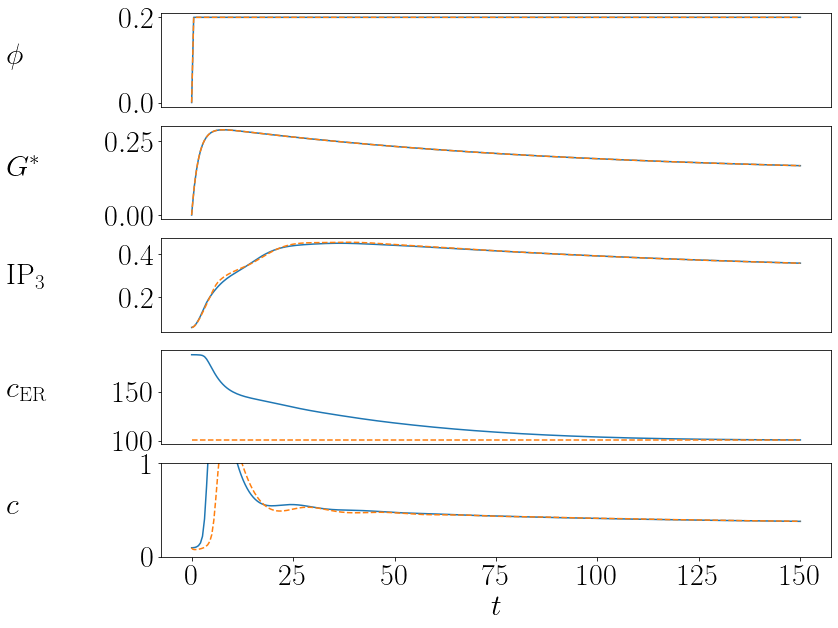

In [59]:
cfg.input_start = 0
cfg.input_duration = 600
cfg.input_max = 0.2
fig, ax = plt.subplots(5, 1, figsize=(12, 10))
sol = run_experiment('pulse', t_f=150, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
c_decay, c_decay_perc, c_er_avg = get_decays()
c_er_min = np.min(cfg.c_er)
sol = run_experiment('pulse', t_f=150, fix_c_er=c_er_min, max_step=0.5)
cfg.c_er[0] = c_er_min
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax, linestyle='--')
ax[4].set_ylim([0,1])


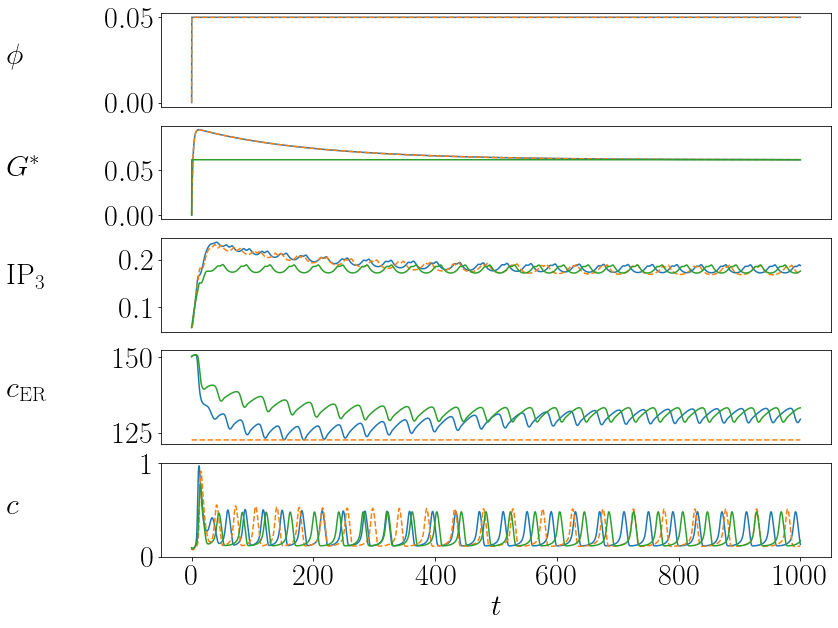

In [75]:
cfg.input_start = 0
cfg.input_duration = 1000
cfg.input_max = 0.05
c_tot_default = cfg.all_init[1]
cfg.all_init[1] = c_tot_default * 0.8
fig, ax = plt.subplots(5, 1, figsize=(12, 10))
sol = run_experiment('pulse', t_f=1000, max_step=0.1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)
c_decay, c_decay_perc, c_er_avg = get_decays()
c_er_min = np.min(cfg.c_er)

sol = run_experiment('pulse', t_f=1000, fix_c_er=c_er_min, max_step=0.1)
cfg.c_er[0] = c_er_min
plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax, linestyle='--')

cfg.input_max = cfg.Gstar[-1]
sol = run_Gstar_controlled_experiment('pulse', max_step=0.1)
plot_experiment_plots(['Gstar', 'p', 'c_er', 'c'], ax[1:])
ax[4].set_ylim([0,1])

cfg.all_init[1] = c_tot_default

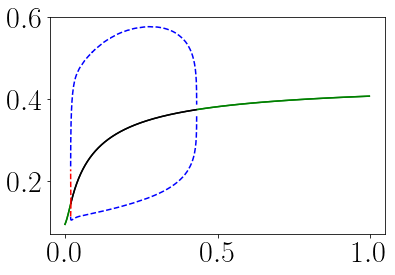

In [76]:
plot_bifurcation('glut_kp_0.9_km_0.4.dat')

In [28]:
base_c = cfg.c[0]
c_peaks = scipy.signal.find_peaks(cfg.c)[0]
deriv = np.diff(cfg.c)
deriv_peaks = scipy.signal.find_peaks(deriv[c_peaks[0]:])[0] + c_peaks[0]
end_first_response = deriv_peaks[0]
start_stimulus = np.argmax(cfg.t > cfg.input_start)
end_stimulus = np.argmax(cfg.t > (cfg.input_duration + cfg.input_start))
end_response = np.argmax(cfg.c[end_stimulus:] < base_c * 1.05) + end_stimulus

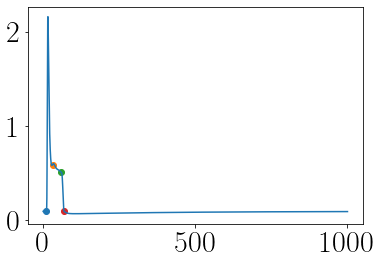

In [29]:
plt.plot(cfg.t, cfg.c)
plt.scatter(cfg.t[start_stimulus], cfg.c[start_stimulus])
plt.scatter(cfg.t[end_first_response], cfg.c[end_first_response])
plt.scatter(cfg.t[end_stimulus], cfg.c[end_stimulus])
plt.scatter(cfg.t[end_response], cfg.c[end_response])


In [30]:
np.mean(cfg.c_er[start_stimulus:end_response + 1])

129.58271895255714

In [56]:
np.arange(0.01, 1.01, 0.1)

array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91])

In [67]:
cfg.input_duration = 60
cfg.input_start = 0
gluts = np.arange(0.4, 5, 0.2)
c_er_factors = np.arange(0.1, 1.01, 0.1)
base_c_er = 187.8

decays = {}

for c_er_factor in c_er_factors:
    decays[str(c_er_factor)+'decay'] = []
    decays[str(c_er_factor)+'decayperc'] = []
    decays[str(c_er_factor)+'glut'] = []

for c_er_factor in c_er_factors:
    for glut in tqdm(gluts):
        cfg.input_max = glut
        
        sol = run_experiment('pulse', t_f=120, max_step=0.1, fix_c_er=c_er_factor * base_c_er)
        
        try:
            base_c = cfg.c[0]
            c_peaks = scipy.signal.find_peaks(cfg.c)[0]
            deriv = np.diff(cfg.c)
            deriv_peaks = scipy.signal.find_peaks(deriv[c_peaks[0]:])[0] + c_peaks[0]
            end_first_response = deriv_peaks[0]
            start_stimulus = np.argmax(cfg.t > cfg.input_start)
            end_stimulus = np.argmax(cfg.t > (cfg.input_duration + cfg.input_start))
            end_response = np.argmax(cfg.c[end_stimulus:] < base_c * 1.05) + end_stimulus

            c_end_first_response = cfg.c[end_first_response]
            c_end_stimulus = cfg.c[end_stimulus]
            decay = c_end_first_response - c_end_stimulus
            perc_decay = decay / c_end_first_response

            decays[str(c_er_factor)+'decay'].append(decay)
            decays[str(c_er_factor)+'decayperc'].append(perc_decay)
            decays[str(c_er_factor)+'glut'].append(glut)
        except:
            pass
        
        

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:15<00:00,  1.50it/s]


In [68]:
pickle.dump(decays, open('data/plot_data/4.3_decay_amounts_fixed_cers', 'wb'))

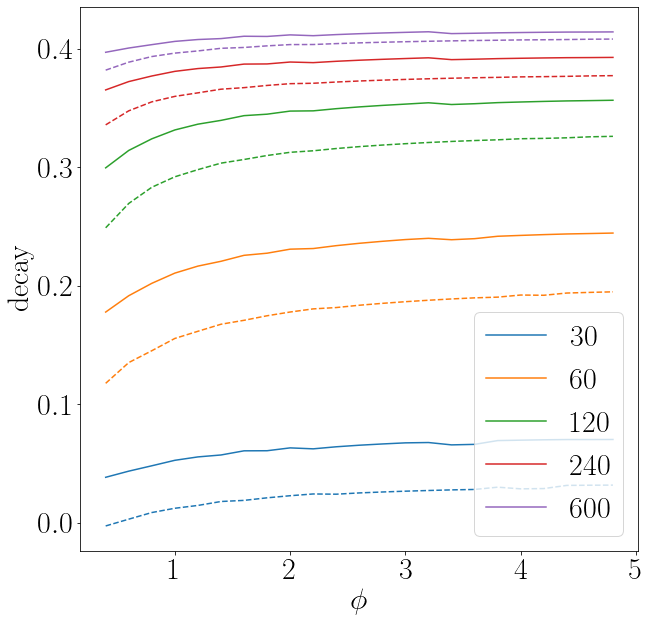

In [48]:
plt.figure(figsize=(10,10))
gluts = np.arange(0.4, 5, 0.2)
for i, dur in enumerate(durations):
    plt.plot(gluts, decays[str(dur)+'decayperc'], '-', label=str(dur), c=color_cycle[i])
    plt.plot(gluts, decays[str(dur)+'fixed_decayperc'], '--', c=color_cycle[i])

plt.xlabel('$\phi$')
plt.ylabel('decay')
plt.legend()

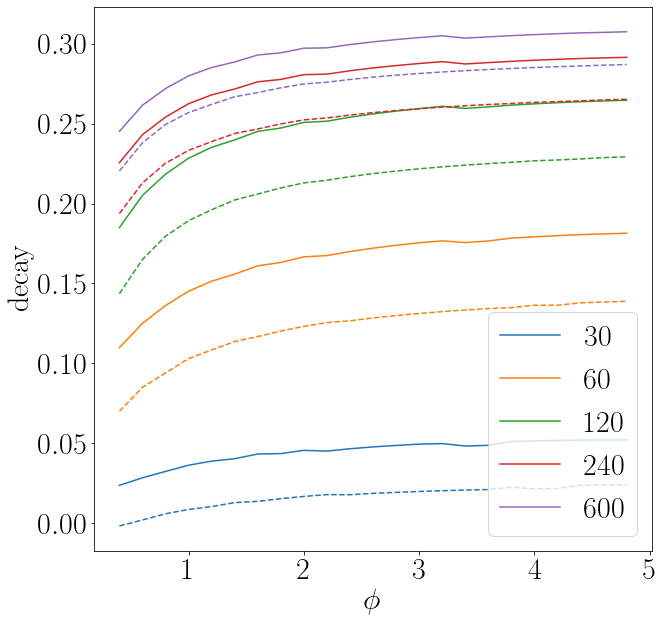

In [47]:
plt.figure(figsize=(10,10))
gluts = np.arange(0.4, 5, 0.2)
for i, dur in enumerate(durations):
    plt.plot(gluts, decays[str(dur)+'decay'], '-', label=str(dur), c=color_cycle[i])
    plt.plot(gluts, decays[str(dur)+'fixed_decay'], '--', c=color_cycle[i])

plt.xlabel('$\phi$')
plt.ylabel('decay')
plt.legend()

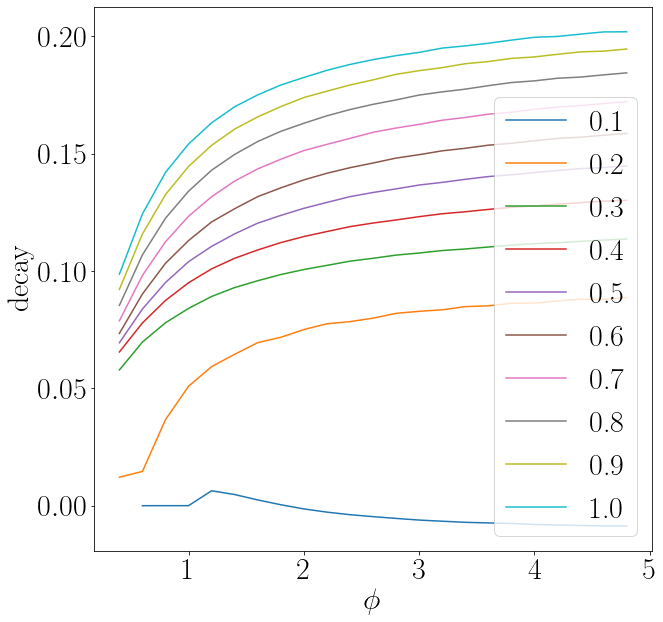

In [75]:
decays = pickle.load(open('data/plot_data/4.3_decay_amounts_fixed_cers', 'rb'))
plt.figure(figsize=(10,10))
c_er_factors = np.arange(0.1, 1.01, 0.1)

for i, factor in enumerate(c_er_factors):
    plt.plot(decays[str(factor)+'glut'], decays[str(factor)+'decay'], '-', label=str(round(factor,1)), c=color_cycle[i])

plt.xlabel('$\phi$')
plt.ylabel('decay')
plt.legend()

In [45]:
cfg.kp = 0.9
cfg.km = 0.4

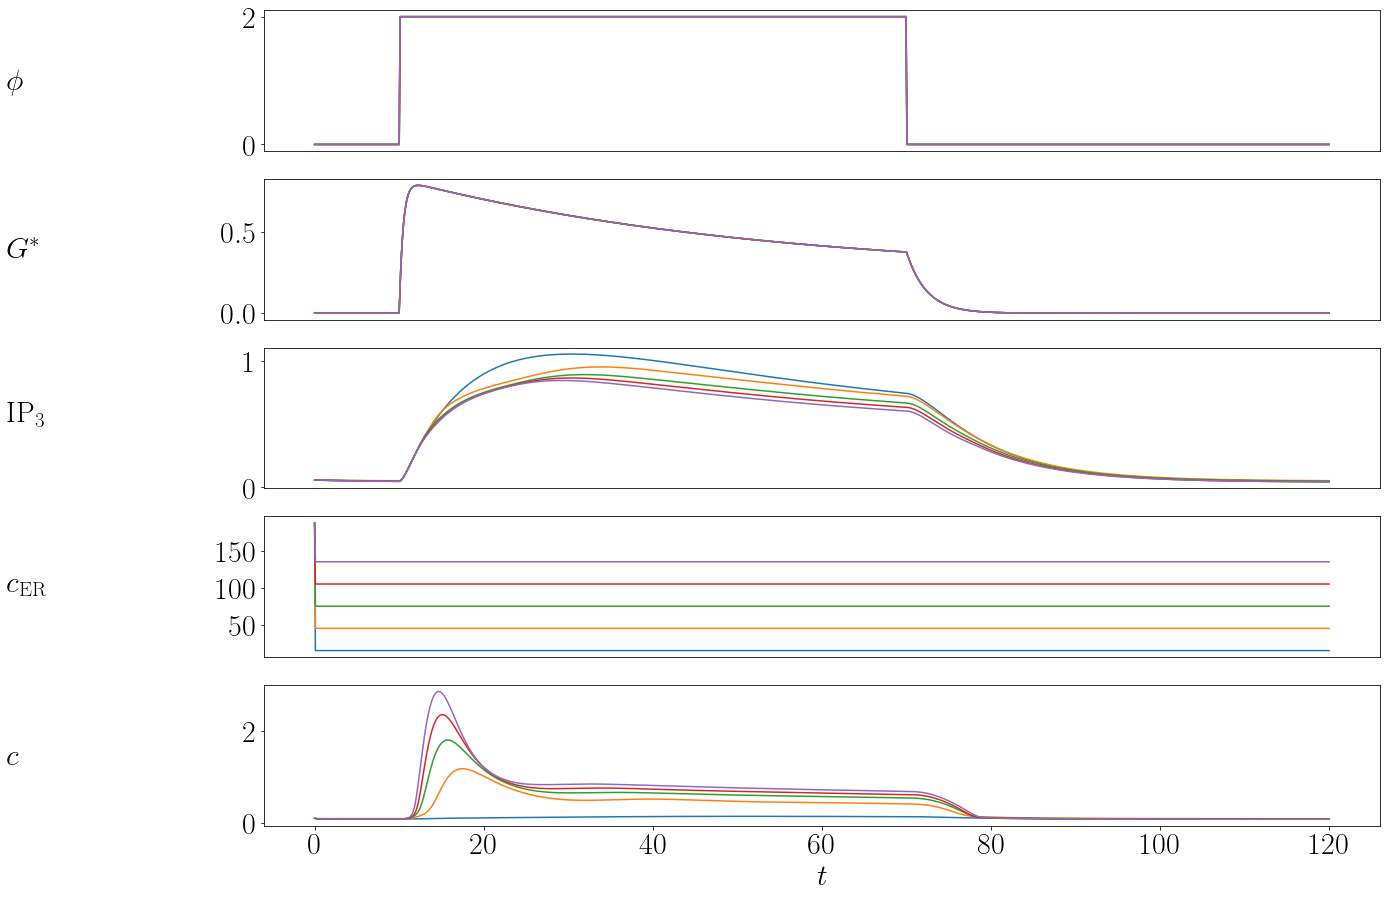

In [46]:
fig, ax = plt.subplots(5, 1, figsize=(20,15))
c_er_default = 150
cfg.input_duration = 60
cfg.input_max = 2
for factor in np.arange(0.1, 1, 0.2):
    c_er = c_er_default * factor
    sol = run_experiment(t_f=120, fix_c_er=c_er)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

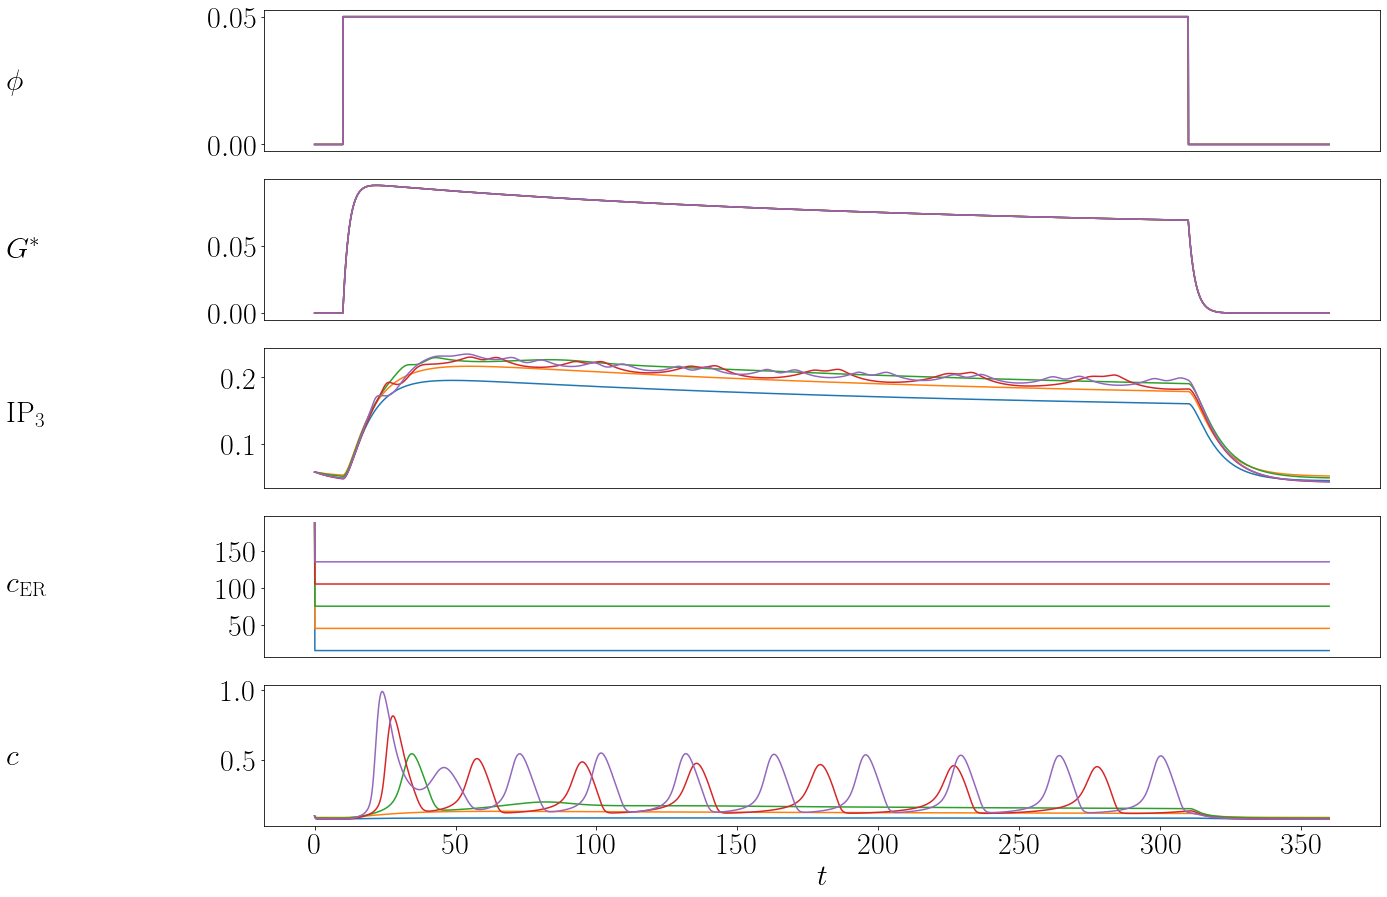

In [48]:
fig, ax = plt.subplots(5, 1, figsize=(20,15))
c_er_default = 150
cfg.input_duration = 300
cfg.input_max = 0.05
for factor in np.arange(0.1, 1, 0.2):
    c_er = c_er_default * factor
    sol = run_experiment(t_f=360, fix_c_er=c_er)
    plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

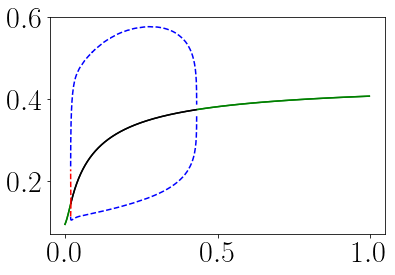

In [62]:
plot_bifurcation('glut_kp_0.9_km_0.4.dat')

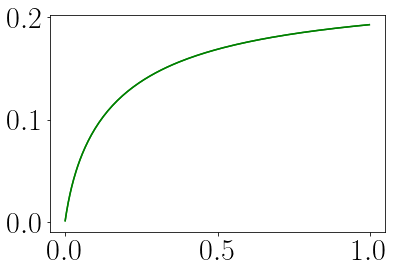

In [64]:
plot_bifurcation('gpcr_kp_0.9_km_0.4.dat')

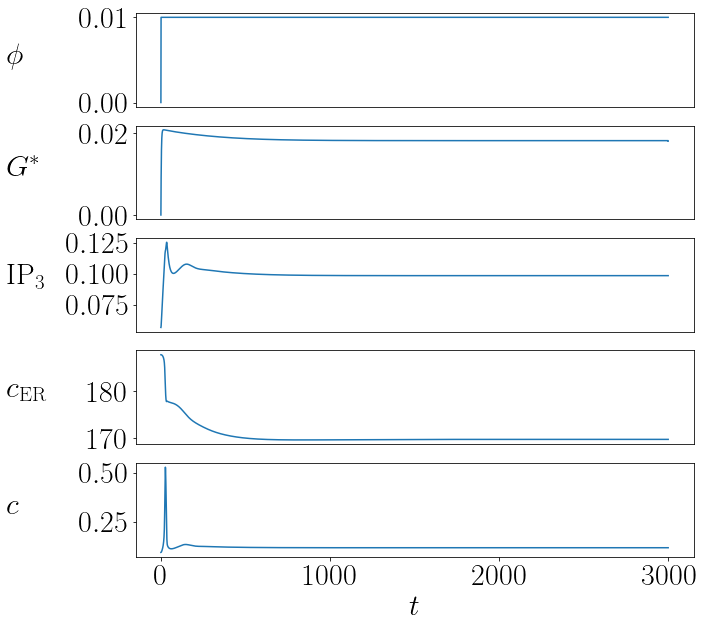

In [77]:
cfg.input_duration = 3000
cfg.input_max = 0.01
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

sol = run_experiment('pulse', t_f=3000, max_step=1)

plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

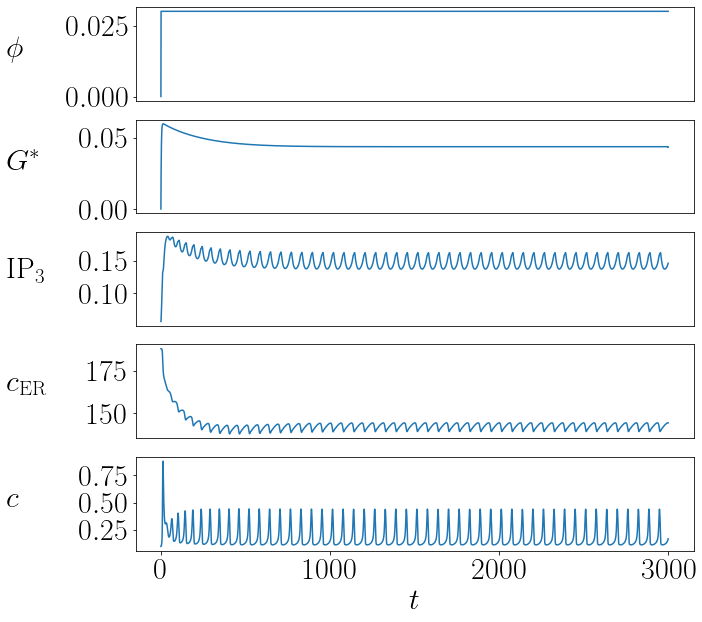

In [78]:
cfg.input_duration = 3000
cfg.input_max = 0.03
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

sol = run_experiment('pulse', t_f=3000, max_step=1)

plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

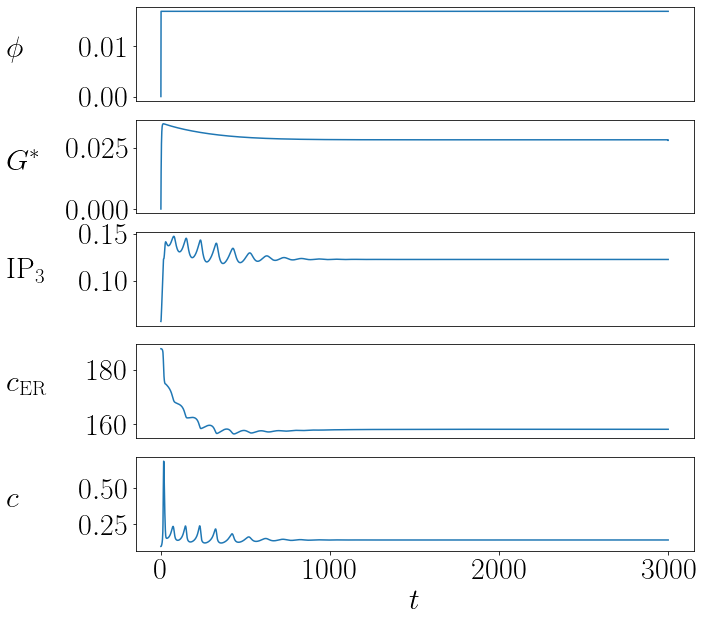

In [83]:
cfg.input_duration = 3000
cfg.input_max = 0.017
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

sol = run_experiment('pulse', t_f=3000, max_step=1)

plot_experiment_plots(['glut', 'Gstar', 'p', 'c_er', 'c'], ax)

In [128]:
cfg.kp

1.5

In [147]:
cfg.v_delta

0.005

In [154]:
cfg.v_ip3r

0.222

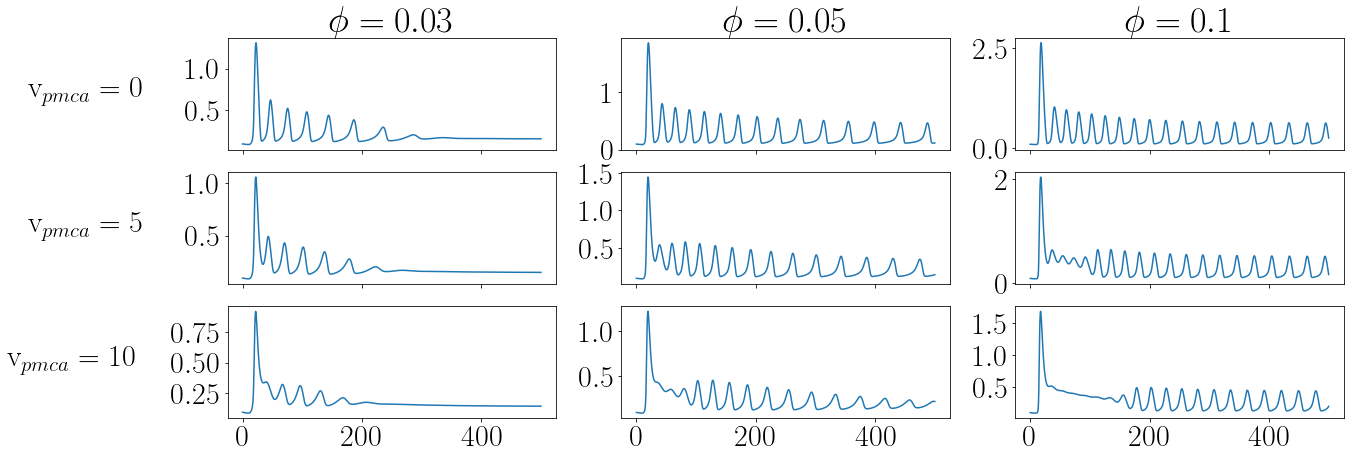

In [13]:
v_pmcas = [0, 5, 10]
gluts = [0.03, 0.05, 0.1]
fig, ax = plt.subplots(3, 3, figsize=(20, 7), sharex=True)
cfg.kp = 1.5
cfg.kd2 = 1.2
cfg.v_delta = 0.005
cfg.input_max = 0.05
cfg.input_duration = 500
for i, v_pmca in enumerate(v_pmcas):
    for j, glut in enumerate(gluts):
        cfg.input_max = glut
        cfg.v_pmca = v_pmca
        run_experiment(t_f=500, max_step=0.5)
        ax[i, j].plot(cfg.t, cfg.c)
        ax[i, 0].set_ylabel('v$_{pmca}='  + str(v_pmca) + '$', rotation=0, ha='center', va='center', labelpad=100)
        ax[0, j].set_title('$\phi=' + str(glut) + '$')
    
plt.savefig('figures/vpmca_examples', bbox_inches='tight')
# ax[1].set_yticks([0, 2.5])

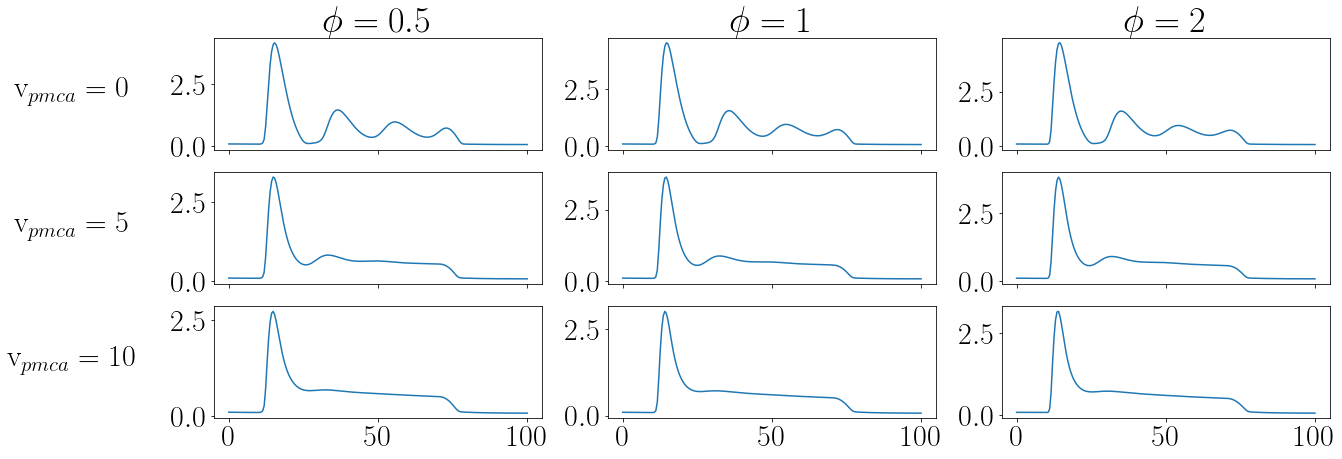

In [19]:
v_pmcas = [0, 5, 10]
gluts = [0.5, 1, 2]
fig, ax = plt.subplots(3, 3, figsize=(20, 7), sharex=True)
cfg.kp = 1.5
cfg.kd2 = 1.2
cfg.v_delta = 0.005
cfg.input_max = 0.05
cfg.input_duration = 60
for i, v_pmca in enumerate(v_pmcas):
    for j, glut in enumerate(gluts):
        cfg.input_max = glut
        cfg.v_pmca = v_pmca
        run_experiment(t_f=100, max_step=0.5)
        ax[i, j].plot(cfg.t, cfg.c)
        ax[i, 0].set_ylabel('v$_{pmca}='  + str(v_pmca) + '$', rotation=0, ha='center', va='center', labelpad=100)
        ax[0, j].set_title('$\phi=' + str(glut) + '$')
    
plt.savefig('figures/vpmca_plateau_examples', bbox_inches='tight')
# ax[1].set_yticks([0, 2.5])